In [1]:
import sys
import time
import numba
import pathlib
import math
import numpy as np
import numpy.typing as npt
import typing as t
import pandas as pd
import scipy.constants as const
import numexpr as ne
from scipy.integrate import quad, simpson, cumulative_simpson
from scipy.special import voigt_profile, wofz, erf, roots_hermite
from scipy.stats import norm, gaussian_kde
from scipy.optimize import minimize
from functools import partial
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as ac

from scipy.optimize import lsq_linear
from linelisttools.format import output_data
from linelisttools.plot import get_vibrant_colors


def microns_to_wavenumbers(microns: float) -> float:
    if microns == 0:
        return microns
    else:
        return 1e4 / microns


ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B
ac_2_hc = 2 * ac.h * ac.c.cgs

ac_4_pi_c = 4 * np.pi * ac.c.cgs
ac_8_pi_c = 2 * ac_4_pi_c
ac_8_pi_five_halves_c = ac_8_pi_c * (np.pi ** 1.5)
ac_16_pi_c = 2 * ac_8_pi_c

ac_h_c_on_4_pi = ac.h.cgs * ac.c.cgs / (4 * np.pi)
ac_h_c_on_4_pi_five_halves = ac_h_c_on_4_pi / (np.pi ** 1.5)
ac_h_c_on_8_pi = ac_h_c_on_4_pi / 2.0

ac_sqrt_NA_kB_on_c = (np.sqrt(ac.N_A * ac.k_B.cgs) / ac.c.cgs).to(u.kg ** 0.5 / (u.K ** 0.5 * u.mol ** 0.5),
                                                                  equivalencies=u.spectral())
ac_sqrt_2_NA_kB_log2_on_c = ac_sqrt_NA_kB_on_c * np.sqrt(2 * np.log(2))

ac_2_h_on_c_sq = 2 * ac.h / ac.c ** 2
ac_h_on_kB = ac.h / ac.k_B

# Dimensionless version for numba
const_h_c_on_kB = ac_h_c_on_kB.value
const_2_hc = ac_2_hc.value
const_4_pi_c = ac_4_pi_c.value
const_8_pi_c = ac_8_pi_c.value
const_16_pi_c = ac_16_pi_c.value
const_8_pi_five_halves_c = ac_8_pi_five_halves_c.value
const_h_c_on_4_pi = ac_h_c_on_4_pi.value
const_h_c_on_4_pi_five_halves = ac_h_c_on_4_pi_five_halves.value
const_h_c_on_8_pi = ac_h_c_on_8_pi.value
const_sqrt_NA_kB_on_c = ac_sqrt_NA_kB_on_c.value
const_sqrt_2_NA_kB_log2_on_c = ac_sqrt_2_NA_kB_log2_on_c.value
const_2_h_on_c_sq = ac_2_h_on_c_sq.value
const_h_on_kB = ac_h_on_kB.value
const_2_pi_h_c_sq_on_sigma_sba = (2 * np.pi * ac.h * ac.c.cgs ** 2 / ac.sigma_sb).to(u.K ** 4 * u.cm ** 4,
                                                                                     equivalencies=u.spectral()).value

_DEFAULT_CHUNK_SIZE = 10000000
_N_GH_QUAD_POINTS = 30

%load_ext autoreload
%autoreload 2

In [ ]:
def spoof_collisions(rates, temperature, states, n_density=1.0):
    n_states = rates.shape[0]
    state_permutations = [(upper, lower) for upper in range(n_states) for lower in range(n_states) if
                          upper != lower and upper > lower]
    # print(state_permutations)
    col_rates = [(3 ** (1 - (upper / 10))) * 10 ** (1 - upper + lower) for upper, lower in state_permutations]
    # print(col_rates)
    col_matrix = np.zeros_like(rates)
    for idx, state_permutation in enumerate(state_permutations):
        rate = col_rates[idx]
        trans_energy = states.loc[states["state"] == state_permutation[0], "energy"].values[0] - \
                       states.loc[states["state"] == state_permutation[1], "energy"].values[0]
        trans_energy = (trans_energy << u.k).to(1 / u.m, equivalencies=u.spectral())
        rate_inv = rate * np.exp(-ac.h * ac.c * trans_energy / (ac.k_B * temperature))
        # print(rate, rate_inv)
        col_matrix[state_permutation[0], state_permutation[1]] += rate_inv
        col_matrix[state_permutation[1], state_permutation[0]] += rate
        col_matrix[state_permutation[0], state_permutation[0]] -= rate
        col_matrix[state_permutation[1], state_permutation[1]] -= rate_inv
    return col_matrix * n_density

# state_idxs = np.array(range(y_matrix_reduced.shape[0]))
# states = pd.DataFrame(data=zip(state_idxs, state_idxs * 2000), columns=["state", "energy"])
# 
# temperature = 1471.7 << u.K
# n_density = 10 ** 6
# col_matrix = spoof_collisions(y_matrix_reduced, temperature, states, n_density)
# y_new = y_matrix_reduced + col_matrix
# y_new
# 
# y_new[-1, :] = 1.0
# b_matrix = np.zeros(y_new.shape[0])
# b_matrix[-1] = 1.0
# np.linalg.solve(y_new, b_matrix)

In [ ]:
vals = np.random.rand(10000)
x_vals = np.linspace(0, 100, 10000)
x_edges = np.arange(0, 100, 7.5)
x_centers = 3.75 + np.arange(0, 100, 7.5)[:-1]
binned_vals = np.zeros_like(x_centers)

yy, xx = np.histogram(x_vals, bins=x_edges, weights=vals, density=False)

for idx, x_val in enumerate(x_vals):
    binned_vals[np.argmin(abs(x_val - x_centers))] += vals[idx]

print(simpson(vals, x=x_vals), sum(vals))
print(simpson(binned_vals, x=x_centers), sum(binned_vals))
print(simpson(yy / 7.5, x=x_centers), sum(yy / 7.5))
# print(yy, x_centers)

plt.plot(x_vals, vals)
plt.plot(x_centers, binned_vals)
plt.plot(x_centers, yy / 7.5)
plt.show()

# Binned Voigt implementation

In [ ]:
broad_dict = {
    "H": (0.089, 0.5),
    "He": (0.015, 0.5),
}
n_layers = 10
chemistry_profile = {
    "H": np.zeros(n_layers) + 0.8,
    "He": np.zeros(n_layers) + 0.15,
}


def weight_broadening_parameters(broadening_dict: t.Dict, chemistry_profile) -> t.Tuple[npt.NDArray[np.float64]]:
    broad_n = []
    broad_gamma = []
    for species_idx, species in enumerate(broadening_dict.keys()):
        species_vmr = chemistry_profile[species]
        species_broad = broadening_dict[species]
        # broad_out.append((species_gamma * species_vmr, broadening_dict[species][1]))
        broad_gamma.append(species_broad[0] * species_vmr)
        broad_n.append(species_broad[1])
    return np.array(broad_gamma), np.array(broad_n)


broadening_params = weight_broadening_parameters(broad_dict, chemistry_profile)

temp = 1000
t_ref = 296
pressure = 5
p_ref = 1

layer_idx = 4

broad_n = broadening_params[1]
broad_gamma = broadening_params[0][:, layer_idx]

# print((temp / t_ref))
# print((temp / t_ref) ** broad_n)
print(broadening_params[0])
print(broad_gamma * pressure * (t_ref / temp) ** broad_n / p_ref)

for idx in range(len(broad_n)):
    print(broad_gamma[idx] * pressure * (t_ref / temp) ** broad_n[idx] / p_ref)


In [ ]:
gh_roots, gh_weights = roots_hermite(30)

num_trans = 2
sigma = np.random.rand(num_trans)
abs_coef = np.random.rand(num_trans)
emi_coef = np.random.rand(num_trans)
energy_fi = np.random.uniform(low=0, high=1000, size=num_trans)
wn_grid = np.linspace(0, 1000, 1001)
half_bin_width = abs(wn_grid[0] - wn_grid[1]) / 2.0
gamma = 0.03


# @numba.njit(parallel=True)
def test_loop(num_trans, gh_roots, gh_weights, sigma, wn_grid, energy_fi, half_bin_width, gamma, abs_coef, emi_coef):
    _abs_xsec = np.zeros(wn_grid.shape[0])
    _emi_xsec = np.zeros(wn_grid.shape[0])
    # for i in numba.prange(num_trans):
    for i in range(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]

        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - energy_fi[i]) / gamma) -
                np.arctan((start_sigma - energy_fi[i]) / gamma)
        )
        for j in range(len(wn_grid)):
            wn_shift = wn_grid[j] - energy_fi[i]
            if abs(wn_shift) <= 25:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + half_bin_width) / gamma) -
                        np.arctan((shift_sigma - half_bin_width) / gamma)
                ))
                print(bin_term)
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


# @numba.njit(parallel=True)
def test_vec(num_trans: int, gh_roots: npt.NDArray[np.float64], gh_weights: npt.NDArray[np.float64],
             sigma: npt.NDArray[np.float64], wn_grid: npt.NDArray[np.float64], energy_fi: npt.NDArray[np.float64],
             half_bin_width: float, gamma: float, abs_coef: npt.NDArray[np.float64], emi_coef: npt.NDArray[np.float64]):
    _abs_xsec = np.zeros(wn_grid.shape[0])
    _emi_xsec = np.zeros(wn_grid.shape[0])
    # for i in numba.prange(num_trans):
    for i in range(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        wn_shift = wn_grid - energy_fi[i]
        wn_logic = np.abs(wn_shift) <= 25
        wn_cut = wn_shift[wn_logic]
        start_idx = np.argmax(wn_logic)
        # print(wn_cut.shape)
        shift_sigma = wn_cut[:, None] - gh_roots_sigma
        print(shift_sigma, shift_sigma.shape)
        bin_terms = np.sum(gh_weights * (
                np.arctan((shift_sigma + half_bin_width) / gamma) -
                np.arctan((shift_sigma - half_bin_width) / gamma)
        ), axis=1)
        # print(bin_terms, bin_terms.shape)
        _abs_xsec[start_idx:start_idx + len(wn_cut)] += abs_coef[i] * bin_terms
        _emi_xsec[start_idx:start_idx + len(wn_cut)] += emi_coef[i] * bin_terms

    return _abs_xsec, _emi_xsec


start_time = time.perf_counter()
abs1, emi1 = test_loop(num_trans, gh_roots, gh_weights, sigma, wn_grid, energy_fi, half_bin_width, gamma, abs_coef,
                       emi_coef)
print(f"Loop duration = {time.perf_counter() - start_time}")

# start_time = time.perf_counter()
# abs2, emi2 = test_vec(num_trans, gh_roots, gh_weights, sigma, wn_grid, energy_fi, half_bin_width, gamma, abs_coef,
#                       emi_coef)
# print(f"Vectorised duration = {time.perf_counter() - start_time}")



In [ ]:
import numba


@numba.njit()
def test(shape1, shape2):
    alpha = np.random.rand(shape1, shape2)
    beta = np.random.rand(shape1, shape2)
    gamma = np.random.rand(shape1, shape2)

    return np.stack((alpha, beta, gamma), axis=1)


coefs = test(10, 5)

print(coefs.shape)
# print(coefs[0])

s_func = np.random.rand(10, 5)

layer_idx = 5

delta_s = (coefs[layer_idx, 0] * s_func[layer_idx - 1]
           + coefs[layer_idx, 1] * s_func[layer_idx]
           + coefs[layer_idx, 2] * s_func[layer_idx + 1])
print(delta_s)

# coefs[layer_idx, 0:3], s_func[layer_idx-1:layer_idx+2]

delta_s2 = np.sum(coefs[layer_idx] * s_func[layer_idx - 1:layer_idx + 2], axis=0)
print(delta_s2)

In [ ]:
from scipy.optimize import minimize


def test_rates(v_val, c_const, p_v_list):
    p_v_delta_v_list = np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
    return sum(c_const * p_v_delta_v_list)


def fit_rates(inputs):
    c_const = inputs[0]
    p_v_list = inputs[1:]
    v_list = np.arange(1, len(p_v_list) + 1)
    rates = []
    for v_val in v_list:
        # p_v_list = np.array([0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95,])
        p_v_delta_v_list = np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
        rates.append(sum(c_const * p_v_delta_v_list))
    rates = np.array(rates)
    print(rates)
    return sum((rates - targets) ** 2)


targets = [0.13, 2.7, 5.2, 8.8, 17, 30, 54, 98, 170, 300]  # GRANADA.
# targets = [1.3, 2.7, 5.2, 8.8, 17, 30, 70, 90, 200, 300]  # Adler-Golden
x0 = [44, 0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95, 1.0]
res = minimize(fit_rates, x0)
print(res)

In [ ]:
print(f"C = {res.x[0]}")
for v_val in range(1, len(res.x)):
    print(f"v={v_val}, P_v = {res.x[v_val]}, rate = {test_rates(v_val=v_val, c_const=res.x[0], p_v_list=res.x[1:])}")

print("v''   = 1  2  3  4  5  6  7  8  9 10")
for v_val in range(1, len(res.x)):
    rates = res.x[0] * np.array([res.x[v_val] ** delta_v for delta_v in np.arange(1, v_val + 1)])[::-1]
    print(f"v' = {v_val} {rates}")

In [ ]:
plt.plot(np.arange(1, len(res.x)), res.x[1:])
plt.show()

In [ ]:
# OH + O -> H + O2;
rates1 = np.array([2.72, 2.91, 3.22, 3.38, 3.30, 3.51, 4.22, 4.27, 5.07])  # 210 K,  1e-12
rates2 = np.array([2.36, 2.44, 2.93, 3.45, 3.10, 3.28, 3.88, 4.19, 4.78])  # 255 K,  1e-12
v_vals = np.arange(1, 10)

print(sum(rates1))
print(sum(rates2))
print(rates1 / rates2)


def calc_rate(a_const, n_val, b_val, r_val, temperature, v_val):
    return a_const * (b_val * v_val ** n_val) * np.exp(-r_val / temperature)


def fit_rates(inputs):
    temps = np.array([210, 255])[..., None]
    tests = calc_rate(*inputs, temps, v_vals)
    return sum((tests[0] - rates1) ** 2) + sum((tests[1] - rates2) ** 2)


x0 = np.array([2.0, 0.5, 0.5, 500])
res = minimize(fit_rates, x0)
print(res)

for v_val in range(1, 10):
    print(f"T = 210, v = {v_val}, rate = {calc_rate(*res.x, 210, v_val)} ({rates1[v_val - 1]})")
    print(f"T = 255, v = {v_val}, rate = {calc_rate(*res.x, 255, v_val)} ({rates2[v_val - 1]})")

In [ ]:
rates_tri = [2, 0, 4, 0, 1, 7, 0, 1, 2, 10, 0, 1, 2, 6, 16, 1, 1, 3, 6, 11, 22, 4, 6, 9, 12, 16, 23, 32, 4, 6, 8, 10,
             14, 19, 25, 33, 28, 29, 31, 32, 34, 36, 38, 40, 42]
# tril_indxs = np.tril_indices(9)
rates = np.zeros((9, 9))
rates[np.tril_indices(9)] = rates_tri
for idx in range(rates.shape[0]):
    print(f"v={idx}, {sum(rates[:, idx + 1]) - sum(rates[idx]) if idx <= rates.shape[0] - 2 else -sum(rates[idx])}")

In [ ]:
cont_source_dir = r"/mnt/c/PhD/OH/ExoMol/XABC11_Unbound_States_Trans"
sub_list = ["XA", "XB", "XS", "XD"]
ll_name = "16O-1H__MYTHOS"
states_file = f"{ll_name}.states"
states_cols = ["id", "energy", "g", "J", "parity_tot", "parity_ef", "state", "v", "Lambda", "Sigma", "Omega"]
trans_file = f"{ll_name}.trans"
trans_cols = ["id_f", "id_i", "A_fi", "broad"]

vibron_cont_rates = []
for sub in sub_list:
    working_dir = f"{cont_source_dir}/{sub}"
    working_states = pd.read_csv(f"{working_dir}/{states_file}", names=states_cols, sep=r"\s+")
    trans_reader = pd.read_csv(f"{working_dir}/{trans_file}", names=trans_cols, sep=r"\s+", chunksize=5000000)
    chunk_list = []
    for trans_chunk in trans_reader:
        trans_chunk = trans_chunk.merge(working_states[["id", "state", "v"]], left_on="id_i", right_on="id",
                                        how="inner")
        trans_chunk = trans_chunk.groupby(by=["state", "v"]).agg(A_fi=("A_fi", "sum"))
        chunk_list.append(trans_chunk)
    vibron_cont_sub_rates = pd.concat(chunk_list)
    vibron_cont_sub_rates = vibron_cont_sub_rates.groupby(by=["state", "v"]).agg(A_fi=("A_fi", "sum"))
    vibron_cont_sub_rates = vibron_cont_sub_rates.reset_index()
    output_data(
        vibron_cont_sub_rates,
        fr"{cont_source_dir}/{ll_name}_{sub}.vibron.cont",
        fortran_format_list=["a10", "i3", "E12.4"]
    )
    vibron_cont_rates.append(vibron_cont_sub_rates)
vibron_cont_rates = pd.concat(vibron_cont_rates)
vibron_cont_rates = vibron_cont_rates.groupby(by=["state", "v"]).agg(A_fi=("A_fi", "sum"))
vibron_cont_rates = vibron_cont_rates.reset_index()
output_data(
    vibron_cont_rates,
    fr"{cont_source_dir}/{ll_name}.vibron.cont",
    fortran_format_list=["a10", "i3", "E12.4"]
)

In [ ]:
density_profile = np.array(
    [3.15418180e+24, 2.41218398e+24, 1.84485807e+24, 1.41105775e+24, 1.07933536e+24, 8.25654422e+23, 6.31642020e+23,
     4.83253535e+23, 3.69752339e+23, 2.82930153e+23, 2.16511278e+23, 1.65697280e+23, 1.26819021e+23, 9.70707074e+22,
     7.43066018e+22, 5.68856420e+22, 4.35526565e+22, 3.33475587e+22, 2.55359226e+22, 1.95559040e+22, 1.49776550e+22,
     1.14722895e+22, 8.78815102e+21, 6.73266297e+21, 5.15844762e+21, 3.95270884e+21, 3.02911083e+21, 2.32156558e+21,
     1.77948015e+21, 1.36412042e+21, 1.04582893e+21, 8.01895933e+20, 6.14930248e+20, 4.71612487e+20, 3.61740781e+20,
     2.77500371e+20, 2.12904482e+20, 1.63366290e+20, 1.25371205e+20, 9.62259533e+19, 7.38664306e+19, 5.67105588e+19,
     4.35455889e+19, 3.34417810e+19, 2.56862815e+19, 1.97324662e+19, 1.51611286e+19, 1.16507409e+19, 8.95466395e+18,
     6.88368094e+18, 5.29261014e+18, 4.07004238e+18, 3.13047344e+18, 2.40827172e+18, 1.85305247e+18, 1.42613036e+18,
     1.09779849e+18, 8.45241203e+17, 6.50932824e+17, 5.01409036e+17, 3.86324045e+17, 2.97726985e+17, 2.29506488e+17,
     1.76964294e+17, 1.36487858e+17, 1.05298954e+17, 8.12605843e+16, 6.27286677e+16, 4.84380953e+16, 3.74151771e+16,
     2.89103574e+16, 2.23464976e+16, 1.72791182e+16, 1.33658285e+16, 1.03428171e+16, 8.00676919e+15, 6.20095462e+15,
     4.80452341e+15, 3.72426719e+15, 2.88827732e+15, 2.24106200e+15, 1.73978591e+15, 1.35137366e+15, 1.05027812e+15,
     8.16760632e+14, 6.35565365e+14, 4.94897173e+14, 3.85633351e+14, 3.00715548e+14, 2.34680562e+14, 1.83298180e+14,
     1.43291565e+14, 1.12121319e+14, 8.78186606e+13, 6.88565025e+13, 5.40497986e+13, 4.24784774e+13, 3.34278268e+13,
     2.63423609e+13, 2.07901071e+13]) * (1 / u.m ** 3)
# print(density_profile)
density_profile = density_profile.to(1 / u.cm ** 3, equivalencies=u.spectral())
pressure_profile = np.array(
    [8.70963590e+00, 6.60693448e+00, 5.01187234e+00, 3.80189396e+00, 2.88403150e+00, 2.18776162e+00, 1.65958691e+00,
     1.25892541e+00, 9.54992586e-01, 7.24435960e-01, 5.49540874e-01, 4.16869383e-01, 3.16227766e-01, 2.39883292e-01,
     1.81970086e-01, 1.38038426e-01, 1.04712855e-01, 7.94328235e-02, 6.02559586e-02, 4.57088190e-02, 3.46736850e-02,
     2.63026799e-02, 1.99526231e-02, 1.51356125e-02, 1.14815362e-02, 8.70963590e-03, 6.60693448e-03, 5.01187234e-03,
     3.80189396e-03, 2.88403150e-03, 2.18776162e-03, 1.65958691e-03, 1.25892541e-03, 9.54992586e-04, 7.24435960e-04,
     5.49540874e-04, 4.16869383e-04, 3.16227766e-04, 2.39883292e-04, 1.81970086e-04, 1.38038426e-04, 1.04712855e-04,
     7.94328235e-05, 6.02559586e-05, 4.57088190e-05, 3.46736850e-05, 2.63026799e-05, 1.99526231e-05, 1.51356125e-05,
     1.14815362e-05, 8.70963590e-06, 6.60693448e-06, 5.01187234e-06, 3.80189396e-06, 2.88403150e-06, 2.18776162e-06,
     1.65958691e-06, 1.25892541e-06, 9.54992586e-07, 7.24435960e-07, 5.49540874e-07, 4.16869383e-07, 3.16227766e-07,
     2.39883292e-07, 1.81970086e-07, 1.38038426e-07, 1.04712855e-07, 7.94328235e-08, 6.02559586e-08, 4.57088190e-08,
     3.46736850e-08, 2.63026799e-08, 1.99526231e-08, 1.51356125e-08, 1.14815362e-08, 8.70963590e-09, 6.60693448e-09,
     5.01187234e-09, 3.80189396e-09, 2.88403150e-09, 2.18776162e-09, 1.65958691e-09, 1.25892541e-09, 9.54992586e-10,
     7.24435960e-10, 5.49540874e-10, 4.16869383e-10, 3.16227766e-10, 2.39883292e-10, 1.81970086e-10, 1.38038426e-10,
     1.04712855e-10, 7.94328235e-11, 6.02559586e-11, 4.57088190e-11, 3.46736850e-11, 2.63026799e-11, 1.99526231e-11,
     1.51356125e-11, 1.14815362e-11]) * u.bar
density_profile.value

In [ ]:
einstein_a_ci = 3.2306e+10 * (1 / u.s)
energy_trans = 50000 * (1 / u.cm)
energy_trans = energy_trans.to(u.Hz, equivalencies=u.spectral())
einstein_b_ci = (einstein_a_ci * (ac.c ** 2)) / (2 * ac.h * (energy_trans ** 3))
print(f"Einstein B_ci = {einstein_b_ci}")
example_x_fi = 2.14065155093356e-12 * (u.Hz ** 3 * u.s * 3 * u.J / u.m ** 2)
print(f"B_ci*X_ci = {einstein_b_ci * example_x_fi}")

In [ ]:
cont_source_dir = r"/mnt/c/PhD/OH/ExoMol/XABC11_Unbound_States_Trans"
sub_list = ["XA", "XB", "XS", "XD"]
ll_name = "16O-1H__MYTHOS"
states_file = f"{ll_name}.states"
states_cols = ["id", "energy", "g", "J", "parity_tot", "parity_ef", "state", "v", "Lambda", "Sigma", "Omega"]
trans_file = f"{ll_name}.trans"
trans_cols = ["id_f", "id_i", "A_fi", "broad"]

trans_list = []
states_list = []
for sub in sub_list:
    working_dir = f"{cont_source_dir}/{sub}"
    sub_states = pd.read_csv(f"{working_dir}/{states_file}", names=states_cols, sep=r"\s+")
    sub_states["sub_id"] = [sub + str(idx) for idx in sub_states["id"]]
    states_list.append(sub_states)

    sub_trans_reader = pd.read_csv(f"{working_dir}/{trans_file}", names=trans_cols, sep=r"\s+", chunksize=5000000)
    chunk_list = []
    for trans_chunk in sub_trans_reader:
        trans_chunk = trans_chunk.merge(sub_states[["id", "sub_id"]], left_on="id_f", right_on="id",
                                        how="inner")
        trans_chunk = trans_chunk.drop(columns=["id_f", "id"])
        trans_chunk = trans_chunk.rename(columns={"sub_id": "sub_id_f"})
        trans_chunk = trans_chunk.merge(sub_states[["id", "sub_id"]], left_on="id_i", right_on="id",
                                        how="inner")
        trans_chunk = trans_chunk.drop(columns=["id_i", "id"])
        trans_chunk = trans_chunk.rename(columns={"sub_id": "sub_id_i"})
        chunk_list.append(trans_chunk)
    trans_list.append(pd.concat(chunk_list))

states = pd.concat(states_list)
states = states.drop_duplicates(keep="first")
states["id"] = np.arange(1, len(states) + 1)
# states.loc[states.duplicated(subset=states.columns[:-1], keep=False)].sort_values("id")
output_data(states[states.columns[:-1]], fr"{cont_source_dir}/{ll_name}.states.cont",
            fortran_format_list=["i12", "f12.6", "i6", "f7.1", "a1", "a1", "a8", "i3", "i2", "f4.1", "f4.1"])

trans = pd.concat(trans_list)
print(trans.head())
trans = trans.merge(states[["id", "sub_id"]], left_on="sub_id_f", right_on="sub_id")
trans = trans.drop(columns=["sub_id_f", "sub_id"])
trans = trans.rename(columns={"id": "id_f"})
trans = trans.merge(states[["id", "sub_id"]], left_on="sub_id_i", right_on="sub_id")
trans = trans.drop(columns=["sub_id_i", "sub_id"])
trans = trans.rename(columns={"id": "id_i"})
output_data(trans[["id_f", "id_i", "A_fi", "broad"]], fr"{cont_source_dir}/{ll_name}.trans.cont",
            fortran_format_list=["i12", "i12", "E11.4", "f12.6"])

In [ ]:
main_states_file = r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.states"
cont_source_dir = r"/mnt/c/PhD/OH/ExoMol/XABC11_Unbound_States_Trans"
sub_list = ["XA", "XB", "XS", "XD"]
ll_name = "16O-1H__MYTHOS"
states_file = f"{ll_name}.states"
states_cols = ["id", "energy", "g", "J", "parity_tot", "parity_ef", "state", "v", "Lambda", "Sigma", "Omega"]
trans_file = f"{ll_name}.trans"
trans_cols = ["id_f", "id_i", "A_fi", "broad"]
states_merge_cols1 = ["energy", "g", "J", "parity_tot", "parity_ef", "state", "v", "Lambda", "Sigma", "Omega"]
states_merge_cols2 = ["energy_calc", "g", "J", "parity_tot", "parity_ef", "state", "v", "Lambda", "Sigma", "Omega"]
merge_col_dict = {
    "XA": states_merge_cols1,
    "XB": states_merge_cols2,
    "XS": states_merge_cols1,
    "XD": states_merge_cols1,
}

main_states_cols = ["id", "energy", "g", "J", "unc", "tau", "lande", "parity_tot", "parity_ef", "state", "v", "Lambda",
                    "Sigma", "Omega", "tag", "energy_calc"]
main_states = pd.read_csv(main_states_file, names=main_states_cols, sep=r"\s+")

trans_list = []
states_list = []
for sub in sub_list:
    working_dir = f"{cont_source_dir}/{sub}"
    sub_states = pd.read_csv(f"{working_dir}/{states_file}", names=states_cols, sep=r"\s+")
    sub_states["sub_id"] = [sub + str(idx) for idx in sub_states["id"]]
    sub_states["sub"] = sub

    merge_cols = merge_col_dict.get(sub)
    sub_states = sub_states.merge(main_states, left_on=states_merge_cols1, right_on=merge_cols, how="left",
                                  suffixes=("", "_main"))
    # if "energy_calc" in merge_cols:
    #     sub_states = sub_states.rename(columns={"energy_calc": "energy"})
    states_list.append(sub_states)

states = pd.concat(states_list)
dupe_cols = ["id_main", "energy", "g", "J", "parity_tot", "parity_ef", "state", "v", "Lambda", "Sigma", "Omega"]
# states = states.drop_duplicates(subset=dupe_cols, keep="first")
# print(states["id_main"].max())
# print(states.loc[states["id_main"].isna()].groupby(by=["state", "v"]).agg({"id": "count"}))

for sub in sub_list:
    sub_trans_reader = pd.read_csv(f"{cont_source_dir}/{sub}/{trans_file}", names=trans_cols, sep=r"\s+",
                                   chunksize=5000000)
    chunk_list = []
    for trans_chunk in sub_trans_reader:
        trans_chunk["sub"] = sub
        trans_chunk = trans_chunk.merge(states[["id", "sub", "sub_id", "id_main"]], left_on=["id_f", "sub"],
                                        right_on=["id", "sub"],
                                        how="inner")
        trans_chunk = trans_chunk.drop(columns=["id_f", "id"])
        trans_chunk = trans_chunk.rename(columns={"sub_id": "sub_id_f", "id_main": "id_main_f"})
        trans_chunk = trans_chunk.merge(states[["id", "sub", "sub_id", "id_main"]], left_on=["id_i", "sub"],
                                        right_on=["id", "sub"],
                                        how="inner")
        trans_chunk = trans_chunk.rename(columns={"sub_id": "sub_id_i", "id_main": "id_main_i"})
        trans_chunk = trans_chunk.drop(columns=["id_i", "id"])
        chunk_list.append(trans_chunk)
    trans_list.append(pd.concat(chunk_list))

trans = pd.concat(trans_list)
print("Number of missing lower states = ", len(trans.loc[trans["id_main_i"].isna()]))

start_id_from = main_states["id"].max() + 1

states = states.sort_values(by=["J", "parity_tot", "energy"], ascending=True)
states.loc[states["id_main"].isna(), "id_main"] = np.arange(start_id_from,
                                                            start_id_from + len(states.loc[states["id_main"].isna()]))
states = states.sort_values(by="id_main")

trans = trans.merge(states[["id_main", "sub_id"]], left_on="sub_id_f", right_on="sub_id")
trans["id_main_f"] = trans["id_main"]
trans = trans[["id_main_f", "id_main_i", "A_fi", "broad"]]

states = states.drop_duplicates(subset=main_states_cols, keep="first")
# print(states.head(30))
states["energy_dif"] = abs(states["energy"] - states["energy_calc"])
states = states.sort_values(by=["id_main", "energy_dif"], ascending=True).drop_duplicates(subset="id_main", keep="last")
states = states.sort_values(by=["J", "parity_tot", "energy", "id_main"], ascending=True)
states["tag"] = np.where(states["tag"].isna(), "Ca", states["tag"])
states["energy_calc"] = np.where(states["energy_calc"].isna(), states["energy"], states["energy_calc"])

trans = trans.drop_duplicates(subset=trans.columns, keep="first")

states_out_cols = ["id_main", "energy", "g", "J", "unc", "tau", "lande", "parity_tot", "parity_ef", "state", "v",
                   "Lambda", "Sigma", "Omega", "tag", "energy_calc"]
output_data(states[states_out_cols], fr"{cont_source_dir}/{ll_name}.states.cont",
            fortran_format_list=["i12", "f12.6", "i6", "f7.1", "f12.6", "E12.4", "f10.6", "a1", "a1", "a8", "i3", "i2",
                                 "f4.1", "f4.1", "a2", "f12.6"])
output_data(trans, fr"{cont_source_dir}/{ll_name}.trans.cont", fortran_format_list=["i12", "i12", "E11.4", "f12.6"])

In [ ]:
wn_grid = np.linspace(10, 20, 50)
v = np.random.uniform(low=wn_grid[0], high=wn_grid[-1], size=100)
# sigma = np.random.rand(v.shape[0])
sigma = np.repeat(0.2, v.shape[0])
# gamma = np.random.rand(v.shape[0])
gamma = np.repeat(0.1, v.shape[0])
coef = np.random.rand(v.shape[0])

In [ ]:
species_mass = 15.99491461957 + 1.00782503223
temperature = 2000
gamma_L = [0.07]
n_air = [0.5]
pressure = 1.0
n_broad = 1
const_sqrt_NA_kB_on_c = np.sqrt(ac.N_A * ac.k_B) / ac.c
ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B

PI4c = np.pi * 4.0 * ac.c.cgs.value
Inv8Pic = 1 / (8 * np.pi * ac.c.cgs.value)
c2 = ac.h.cgs.value * ac.c.cgs.value / ac.k_B.cgs.value


def boltzmann_population(states: pd.DataFrame, temperature: u.Quantity) -> t.Tuple[pd.DataFrame, float]:
    states["q_lev"] = states["g"] * np.exp(-ac_h_c_on_kB * (states["energy"] << 1 / u.cm) / temperature)
    states["n"] = states["q_lev"] / states["q_lev"].sum()
    return states, states["q_lev"].sum()


def Lorentzian_HWHM(gamma_L, n_air, temperature, pressure):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = ne.evaluate('gamma_L * (296 / temperature)**n_air * (pressure / 1)')
    return gamma


def lifetime_broadening(tau):
    '''Return the lifetime broadening -- gamma_tau.'''
    gamma_tau = ne.evaluate('1 / (PI4c) * tau')
    return gamma_tau


def cal_abscoefs(temperature, v, gp, A, Epp, Q, abundance):
    abscoef = ne.evaluate(
        'gp * A * exp(- c2 * Epp / temperature) * (1 - exp(- c2 * v / temperature)) * Inv8Pic / (v ** 2 * Q) * abundance')
    return abscoef


test_xsec = pd.read_csv(r"/mnt/c/PhD/OH/georgi_test.xsec", names=["wn", "xsec"], usecols=[0, 1], sep=r"\s+")
test_states = pd.read_csv(r"/mnt/c/PhD/OH/georgi_test.states", names=["id", "energy", "g", "tau"], usecols=[0, 1, 2, 5],
                          sep=r"\s+")
test_states, part_func = boltzmann_population(test_states, temperature << u.K)
test_trans = pd.read_csv(r"/mnt/c/PhD/OH/georgi_test.trans", names=["id_f", "id_i", "A_fi"], usecols=[0, 1, 2],
                         sep=r"\s+")

test_trans = test_trans.merge(test_states[["id", "g", "energy", "tau"]], left_on="id_f", right_on="id", how="inner")
test_trans = test_trans.rename(columns={"g": "g_f", "energy": "energy_f", "tau": "tau_f"})
test_trans = test_trans.drop(columns=["id_f", "id"])

test_trans = test_trans.merge(test_states[["id", "g", "energy", "tau", "n", ]], left_on="id_i", right_on="id",
                              how="inner")
test_trans = test_trans.rename(columns={"g": "g_i", "energy": "energy_i", "tau": "tau_i", "n": "n_i"})
test_trans = test_trans.drop(columns=["id_i", "id"])

test_trans["energy_fi"] = test_trans["energy_f"] - test_trans["energy_i"]

wn_grid = test_xsec["wn"].to_numpy()
v = test_trans["energy_fi"].to_numpy()
sigma = v * const_sqrt_NA_kB_on_c.value * np.sqrt(temperature / species_mass)

gamma = sum([Lorentzian_HWHM(gamma_L[i], n_air[i], temperature, pressure) for i in range(n_broad)])
gamma += lifetime_broadening(test_trans["tau_f"].to_numpy())

coef = cal_abscoefs(temperature=temperature, v=v, gp=test_trans["g_f"].to_numpy(), A=test_trans["A_fi"].to_numpy(),
                    Epp=test_trans["energy_i"].to_numpy(), Q=part_func, abundance=1.0)

In [ ]:
@numba.njit(parallel=True)
def _voigt_variable(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        sigma: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
        gh_roots, gh_weights,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    # gh_roots, gh_weights = roots_hermite(100)

    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = v.shape[0]
    num_grid = wn_grid.shape[0]

    bin_lower_widths = np.zeros(wn_grid.shape[0])
    bin_upper_widths = np.zeros(wn_grid.shape[0])
    bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_lower_widths[1:] = bin_widths
    bin_lower_widths[0] = bin_widths[0]
    bin_upper_widths[:-1] = bin_widths
    bin_upper_widths[-1] = bin_widths[-1]

    for i in range(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - v[i]) / gamma[i]) -
                np.arctan((start_sigma - v[i]) / gamma[i])
        )
        for j in range(num_grid):
            upper_width = bin_upper_widths[j]
            lower_width = bin_lower_widths[j]
            leading_term = coef[i] / (np.pi ** 1.5 * (upper_width + lower_width))
            wn_shift = wn_grid[j] - v[i]
            if np.abs(wn_shift) <= global_cutoff:
                shift_sigma = wn_shift - gh_roots_sigma
                _abs_xsec[j] += leading_term * np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + upper_width) / gamma[i]) -
                        np.arctan((shift_sigma - lower_width) / gamma[i])
                ))
    return _abs_xsec


@numba.njit(parallel=True)
def _voigt_fixed(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        sigma: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
        gh_roots, gh_weights,
        half_bin_width: float,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    # gh_roots, gh_weights = roots_hermite(100)

    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = v.shape[0]
    num_grid = wn_grid.shape[0]
    bin_width = 2.0 * half_bin_width

    for i in range(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = 1 / (
                np.arctan((end_sigma - v[i]) / gamma[i]) -
                np.arctan((start_sigma - v[i]) / gamma[i])
        )
        for j in range(num_grid):
            leading_term = coef[i] / (np.pi ** 0.5 * bin_width)
            wn_shift = wn_grid[j] - v[i]
            if np.abs(wn_shift) <= global_cutoff:
                shift_sigma = wn_shift - gh_roots_sigma
                _abs_xsec[j] += leading_term * np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + half_bin_width) / gamma[i]) -
                        np.arctan((shift_sigma - half_bin_width) / gamma[i])
                ))
    return _abs_xsec


from scipy.special import voigt_profile


def _voigt_scipy(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        sigma: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
):
    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = v.shape[0]

    for i in range(num_trans):
        _abs_xsec += coef[i] * voigt_profile(wn_grid - v[i], sigma[i], gamma[i])
    return _abs_xsec


def _voigt_new(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        sigma: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
        half_bin_width: float,
):
    gh_roots, gh_weights = roots_hermite(20)
    _abs_xsec = np.zeros(wn_grid.shape)
    num_grid = wn_grid.shape[0]

    wn_start = wn_grid[0]
    wn_end = wn_grid[-1]

    # print(v[..., None] + gh_roots * sigma[..., None])
    # print(v.reshape(-1, 1) + gh_roots * sigma.reshape(-1, 1))

    wn_plus_gh_rootsigma = v[..., None] + gh_roots * sigma[..., None]

    b_norm = 1 / (
            np.arctan((wn_end - wn_plus_gh_rootsigma) / gamma[..., None]) -
            np.arctan((wn_start - wn_plus_gh_rootsigma) / gamma[..., None])
    )
    # coef = coef / (np.pi ** 1.5 * 2 * half_bin_width)
    inv_pi_threehalves_bin_width = 1 / (np.pi ** 0.5 * 2 * half_bin_width)
    for i in range(num_grid):
        dv = wn_grid[i] - v[..., None]
        dv_minus_gh_root_sigma = dv - gh_roots * sigma[..., None]
        _abs_xsec[i] = np.sum(coef * inv_pi_threehalves_bin_width * np.sum(gh_weights * b_norm * (
                np.arctan((dv_minus_gh_root_sigma + half_bin_width) / gamma[..., None]) -
                np.arctan((dv_minus_gh_root_sigma - half_bin_width) / gamma[..., None])
        )))
    return _abs_xsec


# import numexpr as ne


def BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    vxsigma = ne.evaluate('v+x*sigma')
    # vxsigma = v+x*sigma
    bnormq = ne.evaluate('1/(arctan((wngrid_end-vxsigma)/gamma)-arctan((wngrid_start-vxsigma)/gamma))')
    # bnormq = 1/(np.arctan((wngrid_end-vxsigma)/gamma)-np.arctan((wngrid_start-vxsigma)/gamma))
    return bnormq


def BinnedVoigt_lorenz(dv, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    dvxsigma = ne.evaluate('dv-x*sigma')
    # dvxsigma = dv-x*sigma
    lorenz = ne.evaluate('arctan((dvxsigma+binSizeHalf)/gamma)-arctan((dvxsigma-binSizeHalf)/gamma)')
    # lorenz = np.arctan((dvxsigma+binSizeHalf)/gamma)-np.arctan((dvxsigma-binSizeHalf)/gamma)
    return lorenz


def BinnedVoigt_profile(w, bnormq, lorenz):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    # BinnedVoigtProfile = ne.evaluate('sum(w*bnormq*lorenz)')
    BinnedVoigtProfile = ne.evaluate('sum(w*bnormq*lorenz, axis=1)')
    # BinnedVoigtProfile = np.sum(w * bnormq * lorenz, axis=1)
    return BinnedVoigtProfile


def cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Voigt profile.

    '''
    nquad = 20
    roots, weights = roots_hermite(nquad, mu=False)
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0, wn_grid.searchsorted(min(v)) - 1)
        end = min(wn_grid.searchsorted(max(v)), len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end - 1]
        bnormqT = np.transpose(
            np.array([BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, root) for root in roots]))
        _xsec = np.zeros(shape=(end - start))
        for i in range(start, end):
            idx = i - start
            dv = wn_grid[i] - v
            lorenzT = np.transpose(np.array([BinnedVoigt_lorenz(dv, sigma, gamma, root) for root in roots]))
            # print("weights = ", weights)
            # print("bnormqT = ", bnormqT)
            # print("lorenzT = ", lorenzT)
            BinnedVoigtProfile = BinnedVoigt_profile(weights, bnormqT, lorenzT)
            _xsec[idx] = ne.evaluate('sum(coef * BinnedVoigtProfile)')
            # print(BinnedVoigtProfile)
            # # print(coef.shape)
            # _xsec[idx] = np.sum(coef * BinnedVoigtProfile)
    else:
        start = max(0, wn_grid.searchsorted(min(v) - cutoff) - 1)
        end = min(wn_grid.searchsorted(max(v) + cutoff), len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end - 1]
        bnormq = [BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, root) for root in roots]
        _xsec = np.zeros(shape=(end - start))
        for i in range(start, end):
            idx = i - start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                bnormqT = np.transpose(np.array([bnormq[i][filter] for i in range(nquad)]))
                lorenzT = np.transpose(np.array([BinnedVoigt_lorenz(_dv, _sigma, _gamma, root) for root in roots]))
                BinnedVoigtProfile = BinnedVoigt_profile(weights, bnormqT, lorenzT)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')
                # _xsec[idx] = np.sum(_coef * BinnedVoigtProfile)
    xsec[start:end] += _xsec * InvbinSizePIhalf
    return xsec


# wn_grid = np.random.uniform(low=1000, high=2000, size=10000)
# wn_grid.sort()
# v = np.random.uniform(low=wn_grid[0], high=wn_grid[-1], size=10)
# sigma = np.random.rand(v.shape[0])
# gamma = np.random.rand(v.shape[0])
# coef = np.random.rand(v.shape[0])

half_bin_width = np.abs(wn_grid[0] - wn_grid[1]) / 2.0
bin_size = 2.0 * half_bin_width
# binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
binSizeHalf = bin_size / 2.0
InvbinSizePIhalf = 1.0 / (bin_size * np.pi ** 0.5)
pi_dummy = np.pi

global_cutoff = 25.0

gh_roots, gh_weights = roots_hermite(20)
start_time = time.perf_counter()
profile_variable = _voigt_variable(wn_grid=wn_grid, v=v, sigma=sigma, gamma=gamma, coef=coef, gh_roots=gh_roots,
                                   gh_weights=gh_weights, half_bin_width=half_bin_width)
print(f"Variable width duration = {time.perf_counter() - start_time}")
print(f"Variable width integral = {simpson(profile_variable, x=wn_grid)}")
start_time = time.perf_counter()
profile_fixed = _voigt_fixed(wn_grid=wn_grid, v=v, sigma=sigma, gamma=gamma, coef=coef, gh_roots=gh_roots,
                             gh_weights=gh_weights, half_bin_width=half_bin_width)
print(f"Fixed width duration = {time.perf_counter() - start_time}")
print(f"Fixed width integral = {simpson(profile_fixed, x=wn_grid)}")
start_time = time.perf_counter()
profile_scipy = _voigt_scipy(wn_grid=wn_grid, v=v, sigma=sigma, gamma=gamma, coef=coef)
print(f"Scipy duration = {time.perf_counter() - start_time}")
print(f"Scipy integral = {simpson(profile_scipy, x=wn_grid)}")
start_time = time.perf_counter()
profile_new = _voigt_new(wn_grid=wn_grid, v=v, sigma=sigma, gamma=gamma, coef=coef, half_bin_width=half_bin_width)
print(f"New duration = {time.perf_counter() - start_time}")
print(f"New integral = {simpson(profile_new, x=wn_grid)}")
start_time = time.perf_counter()
profile_pyexocross = cross_section_BinnedVoigt(wn_grid=wn_grid, v=v, sigma=sigma, gamma=gamma, coef=coef,
                                               cutoff=global_cutoff)
print(f"PyExoCross duration = {time.perf_counter() - start_time}")
print(f"PyExoCross integral = {simpson(profile_pyexocross, x=wn_grid)}")
# print(f"Integral = {simpson(profile, x=wn_grid)}")

In [ ]:
fig = plt.figure(
    figsize=(18, 5),
    dpi=300,
)
# plt.plot(wn_grid, test_xsec["xsec"], color="k", label="original pyexocross", zorder=10)
# plt.plot(wn_grid, profile_variable, label="variable width")
plt.plot(wn_grid, profile_fixed, label="My implementation", zorder=200)
plt.plot(wn_grid, profile_scipy, label="Scipy")
# plt.plot(wn_grid, profile_new, label="new")
plt.plot(wn_grid, profile_pyexocross, label="PyExoCross", zorder=100, marker="^")
plt.legend()
plt.yscale("log")
# plt.xlim(left=36000, right=53000)  # Full
# plt.xlim(left=38256, right=38260)
# plt.xlim(left=43212, right=43215)
plt.xlim(left=50190, right=50272)
plt.ylim(top=1e-19)
# plt.stem(v, coef, "r")
plt.show()

In [ ]:
BinnedVoigtProfile = np.random.rand(5, 3)
coefs = np.random.rand(5)
coefs[:2] = 0.0
coefs[4] = 0.0
print(BinnedVoigtProfile)
print(coefs)

print(np.sum(BinnedVoigtProfile, axis=1))
print(np.sum(BinnedVoigtProfile, axis=1) * coefs)
my_answer = np.sum(np.sum(BinnedVoigtProfile, axis=1) * coefs)
print("My answer = ", my_answer)

print(np.sum(BinnedVoigtProfile))
print(np.sum(BinnedVoigtProfile) * coefs)
pyexocross_answer = np.sum(np.sum(BinnedVoigtProfile) * coefs)
print("PyExoCross Answer = ", pyexocross_answer)

print("ratio = ", pyexocross_answer / my_answer)

In [ ]:
# check_line_pos = 38258.258258
# check_line_pos = 43213.213213
# check_line_pos = 50195.195195
check_line_pos = 50270.270270
print(test_xsec.loc[test_xsec["wn"] == check_line_pos])
print("Me running pyexocross = ", profile_pyexocross[test_xsec["wn"] == check_line_pos])
print("Fixed-bin-width binned Voigt implementation = ", profile_fixed[test_xsec["wn"] == check_line_pos])
print("Ratio of mine to (georgi) pyexocross = ",
      test_xsec.loc[test_xsec["wn"] == check_line_pos, "xsec"].values / profile_fixed[
          test_xsec["wn"] == check_line_pos])
print("Ratio of mine to (local) pyexocross = ",
      profile_pyexocross[test_xsec["wn"] == check_line_pos] / profile_fixed[test_xsec["wn"] == check_line_pos])

In [ ]:
print(wn_grid)
# check_line_pos = 12.04081633
# wn_grid == check_line_pos
print("Me running pyexocross = ", profile_pyexocross[10])
print("Fixed-bin-width binned Voigt implementation = ", profile_fixed[10])
print("Ratio of mine to (local) pyexocross = ", profile_pyexocross[10] / profile_fixed[10])

In [ ]:
# wn_grid = np.array([0, 2, 3, 10, 14])
wn_grid = np.linspace(0, 3, 4)

for i in range(wn_grid.shape[0]):
    if i == 0:
        bin_upper_width = (wn_grid[i] + wn_grid[i + 1]) / 2 - wn_grid[i]
        bin_lower_width = bin_upper_width
    elif i == wn_grid.shape[0] - 1:
        bin_lower_width = (wn_grid[i - 1] + wn_grid[i]) / 2 - wn_grid[i - 1]
        bin_upper_width = bin_lower_width
    else:
        bin_lower_width = (wn_grid[i - 1] + wn_grid[i]) / 2 - wn_grid[i - 1]
        bin_upper_width = (wn_grid[i] + wn_grid[i + 1]) / 2 - wn_grid[i]
    print(bin_lower_width, bin_upper_width)

bin_lower_widths = np.zeros(wn_grid.shape[0])
bin_upper_widths = np.zeros(wn_grid.shape[0])

bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
bin_lower_widths[1:] = bin_widths
bin_lower_widths[0] = bin_widths[0]
bin_upper_widths[:-1] = bin_widths
bin_upper_widths[-1] = bin_widths[-1]

print(bin_lower_widths, bin_upper_widths)

In [ ]:
# WASP-39b
planet_mass = 0.28 << u.Mjup
planet_radius = 1.332 << u.Rjup
# host star = 5485 K
# orbital radius = 0.0486 AU

ac_2_h_on_c_sq = 2 * ac.h / ac.c ** 2
ac_h_on_kB = ac.h / ac.k_B


def blackbody(wn_grid: u.Quantity, temperature: u.Quantity) -> npt.NDArray[np.float64]:
    freq_grid = wn_grid.to(u.Hz, equivalencies=u.spectral())
    return (ac_2_h_on_c_sq * freq_grid ** 3) / (np.exp(ac_h_on_kB * freq_grid / temperature) - 1) / u.sr



In [ ]:
n_rows = 10000
df = pd.DataFrame(
    data=zip(np.random.randint(low=0, high=10, size=n_rows), np.random.randint(low=0, high=10, size=n_rows),
             np.random.rand(n_rows)), columns=["f", "i", "val"])


def test_groupfunc(val):
    return pd.Series({"start_idx": min(val), "profile": np.linspace(min(val), max(val), 10)})


def test_normalise(start_idx, profile):
    return start_idx + (profile / sum(profile))


# df.head(10)
dfgb = df.groupby(by=["f", "i"]).apply(lambda x: test_groupfunc(val=x["val"].to_numpy()), include_groups=False)
dfgb.apply(lambda x: test_normalise(start_idx=x["start_idx"], profile=x["profile"]), axis=1)

In [ ]:
wl_grid = np.linspace(125, 2000, 18751) << u.nm
wn_grid = wl_grid.to(1 / u.cm, equivalencies=u.spectral()).value
v = np.random.uniform(low=wn_grid[0], high=wn_grid[-1], size=100)
gamma = np.random.rand(v.shape[0])
# gamma = np.repeat(0.1, v.shape[0])
coef = np.random.rand(v.shape[0])

In [ ]:
@numba.njit(parallel=True)
def _lorentzian_variable(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
        cutoff: float = 0,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    _xsec = np.zeros(wn_grid.shape)
    num_trans = v.shape[0]
    num_grid = wn_grid.shape[0]

    bin_lower_widths = np.zeros(wn_grid.shape[0])
    bin_upper_widths = np.zeros(wn_grid.shape[0])
    bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_lower_widths[1:] = bin_widths
    bin_lower_widths[0] = bin_widths[0]
    bin_upper_widths[:-1] = bin_widths
    bin_upper_widths[-1] = bin_widths[-1]

    start = max((0, np.argmin(np.abs(wn_grid - (np.min(v) - cutoff)))))
    end = min((np.argmin(np.abs(wn_grid - (np.max(v) + cutoff))), len(wn_grid)))
    wngrid_start = wn_grid[start]
    wngrid_end = wn_grid[end - 1]

    for i in numba.prange(num_trans):
        b_corr = np.pi / (
                np.arctan((wngrid_end - v[i]) / gamma[i]) -
                np.arctan((wngrid_start - v[i]) / gamma[i])
        )
        for j in range(num_grid):
            upper_width = bin_upper_widths[j]
            lower_width = bin_lower_widths[j]
            leading_term = coef[i] / (np.pi * (upper_width + lower_width))
            wn_shift = wn_grid[j] - v[i]
            if np.abs(wn_shift) <= cutoff:
                _xsec[j] += leading_term * b_corr * (
                        np.arctan((wn_shift + upper_width) / gamma[i]) -
                        np.arctan((wn_shift - lower_width) / gamma[i])
                )
    return _xsec


def BinnedLorentzian_profile(dv, gamma, bnormBinsize):
    '''Return binned Lorentzian line profile at dv with HWHM gamma.'''
    BinnedLorentzianProfile = ne.evaluate(
        '(arctan((dv+binSizeHalf)/gamma)-arctan((dv-binSizeHalf)/gamma))*bnormBinsize')
    return BinnedLorentzianProfile


PI = np.pi
N_point = len(wn_grid)
bin_size = float((max(wn_grid) - min(wn_grid)) / (N_point - 1))
binSizeHalf = bin_size / 2


def cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Lorentzian profile.

    '''
    xsec = np.zeros_like(wn_grid)

    bin_lower_widths = np.zeros(wn_grid.shape[0])
    bin_upper_widths = np.zeros(wn_grid.shape[0])
    bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_lower_widths[1:] = bin_widths
    bin_lower_widths[0] = bin_widths[0]
    bin_upper_widths[:-1] = bin_widths
    bin_upper_widths[-1] = bin_widths[-1]

    if cutoff == 'None':
        start = max(0, wn_grid.searchsorted(min(v)) - 1)
        end = min(wn_grid.searchsorted(max(v)), len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end - 1]
        bnormBinsize = ne.evaluate('PI/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')

        _xsec = np.zeros(shape=(end - start))
        for i in range(start, end):
            idx = i - start
            dv = wn_grid[i] - v
            BinnedLorentzian = BinnedLorentzian_profile(dv, gamma, bnormBinsize)
            _xsec[idx] = coef @ BinnedLorentzian
    else:
        start = max(0, wn_grid.searchsorted(min(v) - cutoff) - 1)
        end = min(wn_grid.searchsorted(max(v) + cutoff), len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end - 1]
        bnormBinsize = ne.evaluate('PI/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end - start))
        for i in range(start, end):
            idx = i - start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _gamma = gamma[filter]
                _bnormBinsize = bnormBinsize[filter]
                _coef = coef[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, _bnormBinsize)
                _xsec[idx] = _coef @ BinnedLorentzian
    xsec[start:end] += _xsec
    return xsec

In [ ]:
start_time = time.perf_counter()
profile_variable = _lorentzian_variable(wn_grid=wn_grid, v=v, gamma=gamma, coef=coef, cutoff=25)
print(f"Variable width duration = {time.perf_counter() - start_time}")
print(f"Variable width integral = {simpson(profile_variable[::-1], x=wn_grid[::-1])}")

start_time = time.perf_counter()
profile_pyexocross = cross_section_BinnedLorentzian(wn_grid=wn_grid[::-1], v=v, gamma=gamma, coef=coef, cutoff=25)
print(f"PyExoCross duration = {time.perf_counter() - start_time}")
print(f"PyExoCross integral = {simpson(profile_pyexocross[::-1], x=wn_grid[::-1])}")

In [ ]:
fig = plt.figure(
    figsize=(18, 5),
    dpi=300,
)
plt.plot(wn_grid, profile_variable, label="My implementation", zorder=200)
# plt.plot(wn_grid, profile_scipy, label="Scipy")
plt.plot(wn_grid, profile_pyexocross, label="PyExoCross", zorder=100, marker="^")
plt.legend()
plt.yscale("log")
# plt.ylim(top=1e-19)
plt.show()

In [ ]:
def _voigt_variable(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        sigma: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
        cutoff: float,
) -> npt.NDArray[np.float64]:
    gh_roots, gh_weights = roots_hermite(30)
    return _voigt_func(wn_grid, v, sigma, gamma, coef, cutoff, gh_roots, gh_weights)


@numba.njit(parallel=True)
def _voigt_func_old(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        sigma: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
        cutoff: float,
        gh_roots, gh_weights,
) -> npt.NDArray[np.float64]:
    _xsec = np.zeros(wn_grid.shape)
    num_trans = v.shape[0]
    num_grid = wn_grid.shape[0]

    bin_lower_widths = np.zeros(wn_grid.shape[0])
    bin_upper_widths = np.zeros(wn_grid.shape[0])
    bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_lower_widths[1:] = bin_widths
    bin_lower_widths[0] = bin_widths[0]
    bin_upper_widths[:-1] = bin_widths
    bin_upper_widths[-1] = bin_widths[-1]

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - v[i]) / gamma[i]) -
                np.arctan((start_sigma - v[i]) / gamma[i])
        )
        for j in range(num_grid):
            upper_width = bin_upper_widths[j]
            lower_width = bin_lower_widths[j]
            leading_term = coef[i] / (np.pi ** 1.5 * (upper_width + lower_width))
            wn_shift = wn_grid[j] - v[i]
            if np.abs(wn_shift) <= cutoff:
                shift_sigma = wn_shift - gh_roots_sigma
                _xsec[j] += leading_term * np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + upper_width) / gamma[i]) -
                        np.arctan((shift_sigma - lower_width) / gamma[i])
                ))
    return _xsec


@numba.njit(parallel=True)
def _voigt_func(
        wn_grid: npt.NDArray[np.float64],
        v: npt.NDArray[np.float64],
        sigma: npt.NDArray[np.float64],
        gamma: npt.NDArray[np.float64],
        coef: npt.NDArray[np.float64],
        cutoff: float,
        gh_roots, gh_weights,
) -> npt.NDArray[np.float64]:
    _xsec = np.zeros(wn_grid.shape)
    num_trans = v.shape[0]
    num_grid = wn_grid.shape[0]

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_widths[0] = bin_widths[0]
    bin_widths[-1] = bin_widths[-1]

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - v[i]) / gamma[i]) -
                np.arctan((start_sigma - v[i]) / gamma[i])
        )
        for j in range(num_grid):
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            leading_term = coef[i] / (np.pi ** 1.5 * (upper_width + lower_width))
            wn_shift = wn_grid[j] - v[i]
            if np.abs(wn_shift) <= cutoff:
                shift_sigma = wn_shift - gh_roots_sigma
                _xsec[j] += leading_term * np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + upper_width) / gamma[i]) -
                        np.arctan((shift_sigma - lower_width) / gamma[i])
                ))
    return _xsec


gh_roots, gh_weights = roots_hermite(30)

start_time = time.perf_counter()
profile_variable = _voigt_func_old(wn_grid=wn_grid, v=v, sigma=sigma, gamma=gamma, coef=coef, cutoff=25,
                                   gh_roots=gh_roots, gh_weights=gh_weights)
print(f"Variable width duration = {time.perf_counter() - start_time}")
print(f"Variable width integral = {simpson(profile_variable, x=wn_grid)}")
start_time = time.perf_counter()
profile_variable2 = _voigt_variable(wn_grid=wn_grid, v=v, sigma=sigma, gamma=gamma, coef=coef, cutoff=25)
print(f"Variable width simplified duration = {time.perf_counter() - start_time}")
print(f"Variable width simplified duration = {simpson(profile_variable2, x=wn_grid)}")

plt.plot(wn_grid, profile_variable, label="Variable")
plt.plot(wn_grid, profile_variable2, label="Variable (Simplified)")
plt.legend()
plt.yscale("log")
# plt.ylim(top=1e-19)
plt.show()

print(np.allclose(profile_variable, profile_variable2))

# Rays

In [ ]:
def trapz_inte_edge(y, x):
    """ Trapezoidal integration including edge grids

    Parameters:
        y: Array of y-axis value
        x: Array of x-axis value

        Returns:
        Area corresponded to each y (or x) value
            For Example,
             Area corresponded to at y_n is
            ..math:
                0.5*y_n ((x_{n} - x_{n-1}) + (x_{n+1} - x_{n}))
             Area corresponded to at y_0 (start point(edge)) is
            ..math:
                0.5*y_0(x_{1} - x_{0})
    """
    weight_x_0 = 0.5 * (x[1] - x[0])
    weight_x_f = 0.5 * (x[-1] - x[-2])
    weight_x_n = 0.5 * (x[1:-1] - x[:-2]) + 0.5 * (x[2:] - x[1:-1])
    weight_x = np.r_[weight_x_0, weight_x_n, weight_x_f]
    return weight_x * y

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

planet_radius = 1650000
n_layers = 30
ray_p = 17
n_points = 1000
x_grid = np.linspace(-planet_radius, planet_radius, n_points)
# outer_boundary = np.cos(np.pi*x_grid/(2*planet_radius))
outer_boundary = np.sqrt(planet_radius ** 2 - x_grid ** 2)

ray_impacts = np.linspace(0, planet_radius, n_layers)
ray_boundary = np.array(
    [np.sqrt(ray_impacts[ray_p] ** 2 - x_val ** 2) if abs(x_val) < ray_impacts[ray_p] else np.nan for x_val in x_grid])
ray_above_boundary = np.array(
    [np.sqrt(ray_impacts[ray_p + 1] ** 2 - x_val ** 2) if abs(x_val) < ray_impacts[ray_p + 1] else np.nan for x_val in
     x_grid])
ray_depth = ray_impacts[ray_p]

tangent_point = np.sqrt(planet_radius ** 2 - ray_depth ** 2)
tangent_angle = np.arcsin(ray_depth / planet_radius)
tangency_points = np.array([sign * np.sqrt(planet_radius ** 2 - ray_depth ** 2) for sign in (-1, 1)])

plt.figure(dpi=200)

plt.plot(x_grid, outer_boundary, color="#000000")
plt.plot(x_grid, ray_boundary)
plt.plot(x_grid, ray_above_boundary)
plt.hlines(ray_depth, xmin=-planet_radius, xmax=planet_radius)
plt.scatter(-0.9 * planet_radius, ray_depth, marker=">")
plt.scatter(tangency_points, np.repeat(ray_depth, len(tangency_points)), marker="x", color="#ff00ff")
plt.xlim(left=-planet_radius, right=planet_radius)
plt.ylim(bottom=0, top=planet_radius)
plt.gca().set_aspect("equal")
# print(tangent_angle, tangent_angle*180/np.pi)

ray_points = np.linspace(-planet_radius, planet_radius, 2 * n_layers)
ray_above_tangent_point = np.sqrt(ray_impacts[ray_p + 1] ** 2 - ray_impacts[ray_p] ** 2)
print(ray_above_tangent_point)
ray_in_layer = np.array(
    [ray_depth if abs(ray_point) <= ray_above_tangent_point else np.nan for ray_point in ray_points])
print(ray_points[abs(ray_points) <= ray_above_tangent_point])
plt.plot(ray_points, ray_in_layer, color="red")
zeta_angle = np.pi - np.arccos(np.sqrt(1 - (ray_impacts[ray_p] / ray_impacts[ray_p + 1]) ** 2))
# print(zeta_angle)
# print(np.sin(zeta_angle) * ray_impacts[ray_p+1], ray_impacts[ray_p])

for layer_idx in range(n_layers - 1):
    ray_above_tangent_point = np.sqrt(ray_impacts[layer_idx + 1] ** 2 - ray_impacts[layer_idx] ** 2)
    plt.scatter(ray_above_tangent_point, ray_impacts[layer_idx], color="#000000", marker="+")

for layer_idx in range(ray_p, n_layers - 2):
    ray_above_tangent_point = np.sqrt(ray_impacts[layer_idx + 1] ** 2 - ray_impacts[ray_p] ** 2)
    plt.scatter(ray_above_tangent_point, ray_impacts[ray_p], color="#000000", marker="|")
    plt.scatter(-ray_above_tangent_point, ray_impacts[ray_p], color="#000000", marker="|")

ground_radius = 500000
alt_ref = np.linspace(ground_radius, planet_radius, n_layers) - ground_radius
mu_delta = ground_radius / n_layers
mu_point = np.r_[np.arange(0, ground_radius, mu_delta), alt_ref + ground_radius]
mu_tangent = (mu_point - ground_radius)
print("MU POINT = ", mu_point)
print("MU TANGENT = ", mu_tangent)

# mu_point = np.linspace(0, 2*planet_radius, 2*n_layers)
# mu_tangent = mu_point - planet_radius

# print("TEST? ", len(mu_point), len(mu_point_old))
# print(np.arange(0, planet_radius, mu_delta), np.linspace(0, planet_radius, n_layers))
# alt_ref = ray_impacts
# radius = planet_radius
PSC_sin = mu_point.reshape(mu_point.size, 1) / (alt_ref + ground_radius)
PSC_sin[np.abs(PSC_sin > 1.0)] = np.nan
deg = np.arcsin(PSC_sin)
PSC_sin[deg != deg] = 0
# deg[deg != deg] = np.pi / 2
print(PSC_sin.shape)
print(PSC_sin[:, ray_p])

PSC = ((alt_ref + ground_radius) ** 2 - mu_point.reshape(mu_point.size, 1) ** 2) ** 0.5
PSC2 = np.zeros((mu_point.size, alt_ref.size - 1))
for xx in range(1, alt_ref.size):  # alt_center
    PSC2[:, -xx] = PSC[:, -xx] - PSC[:, -xx - 1]

mu_weight = np.zeros((mu_point.size, alt_ref.size))
mu_weight2 = np.zeros((mu_point.size, alt_ref.size))
from scipy.integrate import trapezoid, simpson, cumulative_trapezoid, cumulative_simpson

for i in range(alt_ref.size):
    # print("PSC_sin = ", PSC_sin[:, i])
    # print("deg = ", deg[:, i])
    mu_weight[:, i] = trapz_inte_edge(PSC_sin[:, i], deg[:, i])
    # cumulative_integral = cumulative_trapezoid(y=PSC_sin[:, i], x=deg[:, i], initial=0)
    # contributions = np.diff(np.concatenate(([0], cumulative_integral)))
    # mu_weight2[:, i] = contributions

# print(cumulative_trapezoid(y=PSC_sin[:, 3], x=deg[:, 3], initial=0) == cumulative_trapezoid(y=PSC_sin, x=deg, initial=0, axis=0)[:, 3])
mu_weight3 = np.diff(
    np.concatenate((np.zeros((1, alt_ref.size)), cumulative_trapezoid(y=PSC_sin, x=deg, initial=0, axis=0))), axis=0)
# for i in range(alt_ref.size):
#     print(deg[1:, i] - deg[:-1, i])
mu_weight4 = np.diff(
    np.concatenate((np.zeros((1, alt_ref.size)), cumulative_simpson(y=PSC_sin, x=deg, initial=0, axis=0))), axis=0)
# print(np.allclose(mu_weight, mu_weight2))
# print(np.allclose(mu_weight2, mu_weight3))
# print(np.allclose(mu_weight, mu_weight3))
# print(mu_weight, mu_weight3, mu_weight4)
mu_weight = mu_weight4

wn_grid = np.linspace(0, 80000, 800)

for i in range(n_layers):
    weighttemp = (mu_weight[:, i].reshape(mu_weight[:, i].size, 1) * np.ones((mu_weight[:, i].size, wn_grid.size)))
print(weighttemp.shape)

PSC2[PSC2 != PSC2] = 0.0

for idx in range(PSC2.shape[1]):
    plt.scatter(PSC2[idx].sum(), alt_ref[idx] + ground_radius, marker="v", color="#229933")

plt.show()
from matplotlib.colors import SymLogNorm

plot_quantity = mu_weight
# plot_quantity = PSC_sin
# plot_quantity = PSC
# plot_quantity = PSC2
# plot_quantity = deg
plt.imshow(plot_quantity.T, cmap="viridis", origin="lower")

# plt.imshow(mu_weight.T, cmap="viridis", origin="lower", norm=SymLogNorm(linthresh=1e-2))
# plt.imshow(PSC_sin.T, cmap="viridis", origin="lower")
# plt.imshow(PSC.T/radius, cmap="viridis", origin="lower",)
# plt.imshow(deg.T/np.pi, cmap="viridis", origin="lower",)
plt.colorbar()
plt.show()

In [ ]:
radius_temp = 20
dz_profile = np.array([0, 2, 3, 4, 1])
altitude_profile = dz_profile.cumsum() + radius_temp
angular_integral_points = np.concatenate((np.arange(0, radius_temp, radius_temp / len(dz_profile)), altitude_profile))
# print(angular_integral_points.reshape(angular_integral_points.size, 1) == angular_integral_points.reshape(-1, 1))

mu_grid = np.zeros((altitude_profile.size, 2 * altitude_profile.size))
print(mu_grid.shape)
weight_grid = np.zeros((altitude_profile.size, 2 * altitude_profile.size))
for layer_idx in range(altitude_profile.size):
    n_quad_points = altitude_profile.size + layer_idx + 1
    mu, weights = np.polynomial.legendre.leggauss(n_quad_points)
    mu, weights = (mu + 1) * 0.5, weights / 2
    mu_grid[layer_idx, :len(mu)] = mu
    weight_grid[layer_idx, :len(weights)] = weights

print("Mu grid = ", mu_grid)
integration_points = mu_grid * altitude_profile.reshape(-1, 1)
print("Integration points/mu_point = ", integration_points)
integration_point_heights = (altitude_profile.reshape(-1, 1) ** 2 - integration_points ** 2) ** 0.5
print("Integration point heights/PSC = ", integration_point_heights)
integration_point_dz = integration_point_heights[1:, :] - integration_point_heights[:-1, :]
print("Integration point dz/PSC2 = ", integration_point_dz, integration_point_dz.shape)

In [ ]:
temp_layer_idx = 0
# temp_sin = PSC_sin[:, 0].copy()
# temp[np.argmax(temp == 1.0):] = np.nan
temp_cutoff = np.argmax(PSC_sin[:, temp_layer_idx] == 1.0) + 1
temp_sin = PSC_sin[:temp_cutoff, temp_layer_idx].copy()
temp_weight = mu_weight[:temp_cutoff, temp_layer_idx].copy()
temp_height = PSC[:temp_cutoff, temp_layer_idx].copy()
temp_gap = PSC2[:temp_cutoff, temp_layer_idx].copy()
temp_deg = deg[:temp_cutoff, temp_layer_idx].copy()
temp_ddeg = np.zeros(len(temp_deg))
temp_ddeg[1:] = temp_deg[1:] - temp_deg[:-1]
# temp_weight.sum()
temp_layer_radius = PSC[0, temp_layer_idx]

print(np.pi * temp_layer_radius ** 2 / 4)
print(temp_deg)

temp_segment_area = temp_layer_radius ** 2 * temp_ddeg / 2
print(temp_segment_area)
print(temp_segment_area.sum())

temp_layer_above_radius = PSC[0, temp_layer_idx + 1]
temp_layer_above_cutoff = np.argmax(PSC_sin[:, temp_layer_idx + 1] == 1.0) + 1
temp_layer_above_deg = deg[:temp_layer_above_cutoff, temp_layer_idx + 1].copy()
temp_layer_above_ddeg = np.zeros(len(temp_layer_above_deg))
temp_layer_above_ddeg[1:] = temp_layer_above_deg[1:] - temp_layer_above_deg[:-1]
temp_segment_above_area = temp_layer_above_radius ** 2 * temp_layer_above_ddeg / 2
print(temp_segment_above_area.sum())
print(temp_segment_above_area.sum() - temp_segment_area.sum())

# print(np.sum((temp_height + temp_gap) * temp_weight))
print(temp_weight)
print(temp_deg)

In [ ]:
x = temp_deg
weight_x_0 = 0.5 * (x[1] - x[0])
weight_x_f = 0.5 * (x[-1] - x[-2])
weight_x_n = 0.5 * (x[1:-1] - x[:-2]) + 0.5 * (x[2:] - x[1:-1])
weight_x = np.r_[weight_x_0, weight_x_n, weight_x_f]
weight_x

In [ ]:
mu, weight = np.polynomial.legendre.leggauss(len(temp_deg))
mu, weight = (mu + 1) * 0.5, weight / 2
mu, weight

In [ ]:
weight = weight[mu >= 0]
mu = mu[mu >= 0]
theta = np.arcsin(mu)
weight
# (theta[0] + theta[-1])/np.pi

In [ ]:
class BandProfile:
    def __init__(self, start_idx: int, band_profile_grid: npt.NDArray[np.float64]) -> None:
        """

        :param id_u:              ID of the upper state of the transition.
        :param id_l:              ID of the lower state of the transition.
        :param start_idx:         Index on the spectroscopic grid where the trimmed band profile begins.
        :param band_profile_grid: The band profile of the transition.
        abs_factor:               The absorption intensity factor to multiply the band profile and the lower state
             population by to reconstruct the absorption profile.
        emi_factor:               The emission intensity factor to multiply the band profile and the upper state
             population by to reconstruct the emission profile.
        """
        self.start_idx = start_idx
        self.band_profile_grid = band_profile_grid
        self.abs_factor = 1.0
        self.emi_factor = 1.0

    def __repr__(self):
        return f"BandProfile([{self.start_idx}, {self.band_profile_grid}, {self.abs_factor}, {self.emi_factor}])"

    def __str__(self):
        return f"BandProfile(start_idx: {self.start_idx}, band_profile_grid: {self.band_profile_grid}, abs_factor: {self.abs_factor}, emi_factor: {self.emi_factor})"

    def merge_band_profiles(self, band_profiles: t.List["BandProfile"], normalise: bool = False,
                            spetral_grid: u.Quantity = None) -> None:
        if len(band_profiles) > 0:
            start_idxs = np.concatenate(([self.start_idx], [band_profile.start_idx for band_profile in band_profiles]))
            profiles = [self.band_profile_grid] + [band_profile.band_profile_grid for band_profile in band_profiles]

            min_start_idx = min(start_idxs)
            primary_idx = np.argmax(start_idxs == min_start_idx)
            max_end_idx = max(
                np.concatenate(([self.start_idx + len(self.band_profile_grid)],
                                [band_profile.start_idx + len(band_profile.band_profile_grid)
                                 for band_profile in band_profiles]))
            )
            offset = max_end_idx - min_start_idx - len(profiles[primary_idx])

            merged_profile = np.pad(profiles[primary_idx], (0, offset), "constant")

            for profile_idx in range(len(start_idxs)):
                if profile_idx != primary_idx:
                    profile_offset = start_idxs[profile_idx] - min_start_idx
                    merged_profile[profile_offset:profile_offset + len(profiles[profile_idx])] += profiles[profile_idx]

            self.start_idx = min_start_idx
            self.band_profile_grid = merged_profile
        if normalise:
            if wn_grid is None:
                raise RuntimeError("Normalisation specified but no wn_grid provided for integration.")
            self.normalise_band_profile(spetral_grid=spetral_grid)

    def normalise_band_profile(self, spetral_grid: u.Quantity) -> None:
        if len(self.band_profile_grid) == 1 and sum(self.band_profile_grid) != 0:
            self.band_profile_grid = np.ones_like(self.band_profile_grid)
        else:
            self.abs_factor = simpson(self.band_profile_grid,
                                      x=spetral_grid[self.start_idx:self.start_idx + len(self.band_profile_grid)].value)
            self.band_profile_grid = self.band_profile_grid / self.abs_factor


class BandProfileCollection(dict):
    def __init__(self, band_profiles: npt.NDArray[BandProfile] | t.List[BandProfile] | pd.Series):
        if type(band_profiles) is pd.Series:
            for row_key, row in band_profiles.items():
                if row_key in self:
                    self[row_key].merge_band_profiles(row)
                else:
                    self[row_key] = row
        elif type(band_profiles) in (npt.NDArray[BandProfile], t.List[BandProfile]):
            keys = [(band_profile.id_u, band_profile.id_l) for band_profile in band_profiles]
            unique_keys = set(keys)
            for unique_key in unique_keys:
                key_idxs = [key_idx for key_idx, key in enumerate(keys) if key == unique_key]
                key_profiles = band_profiles[key_idxs]
                self[unique_key] = key_profiles[0]
                if len(key_profiles) > 1:
                    self[unique_key].merge_band_profiles(band_profiles=key_profiles[1:])
        else:
            raise RuntimeError("BandProfileCollection construction only implemented for list, np.array or pd.Series."
                               f"Received {type(band_profiles)}.")
        super().__init__()

    def __getitem__(self, key: t.Tuple[int, int]) -> BandProfile:
        return super().__getitem__(key)

    def get(self, key: t.Tuple[int, int], default: t.Optional[t.Any] = None) -> BandProfile:
        return super().get(key)

    def __setitem__(self, key: t.Tuple[int, int], value: BandProfile) -> None:
        return super().__setitem__(key, value)

    def __contains__(self, key: t.Tuple[int, int]) -> bool:
        return super().__contains__(key)

    def __delitem__(self, key: t.Tuple[int, int]) -> None:
        return super().__delitem__(key)

    def add_merge_band_profile(self, band_profile: BandProfile) -> None:
        key = (band_profile.id_u, band_profile.id_l)
        if key in self:
            self[key].merge_band_profiles(band_profiles=[band_profile])
        else:
            self[key] = band_profile

    def merge_collections(self, band_profile_collections: t.List["BandProfileCollection"] | npt.NDArray[
        "BandProfileCollection"]
                          ) -> None:
        print("Initial keys = ", len(self.keys()))
        keys = [band_profile_collection.keys() for band_profile_collection in band_profile_collections]
        keys = [key for sublist in keys for key in sublist]
        unique_keys = set(keys)
        print("Unique keys in input collections = ", len(unique_keys))
        print("Keys to add = ", len([key for key in unique_keys if key not in self]))
        # for band_profile in band_profile_collection:
        #     self.add_merge_band_profile(band_profile=band_profile)
        for unique_key in unique_keys:
            key_profiles = [band_profile_collection.get(unique_key) for band_profile_collection in
                            band_profile_collections]
            key_profiles = [profile for profile in key_profiles if profile is not None]
            if unique_key in self:
                self[unique_key].merge_band_profiles(band_profiles=key_profiles)
            else:
                self[unique_key] = key_profiles[0]
                if len(key_profiles) > 1:
                    self[unique_key].merge_band_profiles(band_profiles=key_profiles[1:])
        print("Final keys = ", len(self.keys()))


ac_sqrt_NA_kB_on_c = np.sqrt(ac.N_A * ac.k_B) / ac.c  # c here is not cgs as it cancels with the units of k_B
ac_sqrt_2_NA_kB_log2_on_c = ac_sqrt_NA_kB_on_c * np.sqrt(2 * np.log(2))

import math


@numba.njit(parallel=True)
def _band_profile(
        wn_grid: npt.NDArray[np.float64],
        coefs: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        temperature: float,
        species_mass: float,
        half_bin_width: float,
        const_sqrt_2_NA_kB_log2_on_c: np.float64 = ac_sqrt_2_NA_kB_log2_on_c.value,
):
    twice_bin_width = 4.0 * half_bin_width
    sqrtln2 = math.sqrt(math.log(2))
    _xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    alpha = energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass)

    for i in numba.prange(num_trans):
        leading_term = coefs[i] / twice_bin_width
        sqrtln2_on_alpha = sqrtln2 / alpha[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= 25:
                _xsec[j] += leading_term * (
                        math.erf(sqrtln2_on_alpha * (wn_shift + half_bin_width)) -
                        math.erf(sqrtln2_on_alpha * (wn_shift - half_bin_width))
                )
    return _xsec


def calc_band_profile_test(energy_fi: npt.NDArray[np.float64], coefs: npt.NDArray[np.float64],
                           temperature: float, species_mass: float, wn_grid: u.Quantity,
                           broad: npt.NDArray[np.float64] = None) -> BandProfile:
    band_wing_width = 5000.0  # Used to speed up calculation, but might be cutting off data incorrectly!

    band_center = energy_fi.mean()
    band_grid = wn_grid[abs(wn_grid.value - band_center) <= band_wing_width].value
    # if len(band_grid) == 0 or min(band_grid) > max(wn_grid.value):  # all(energy_trans > max(wn_grid.value)) (formerly)
    if len(band_grid) == 0 and broad is None:
        return BandProfile(start_idx=0, band_profile_grid=band_grid)
    else:
        half_bin_width = (abs(wn_grid[1] - wn_grid[0]) / 2.0).value

        # if broad is None:
        xsec = _band_profile(wn_grid=band_grid, coefs=coefs, energy_fi=energy_fi, temperature=temperature,
                             species_mass=species_mass, half_bin_width=half_bin_width)
        start_idx = np.argmax(wn_grid.value >= band_center - band_wing_width)
        start_idx += np.argmax(xsec > 0)
        # else:
        #     xsec = _continuum_band_profile(wn_grid=wn_grid.value, coefs=coefs, energy_fi=energy_fi,
        #                                    cont_broad=broad, half_bin_width=half_bin_width)
        #     start_idx = np.argmax(xsec > 0)

        xsec = np.trim_zeros(xsec)
        return BandProfile(start_idx=int(start_idx), band_profile_grid=xsec)

In [ ]:
n_rows = 1000
wn_grid = np.linspace(1000, 2000, 10000) << u.k
temperature = 1500 << u.K
species_mass = 10
chunk = pd.DataFrame(data=zip(
    np.random.randint(low=0, high=10, size=n_rows),
    np.random.randint(low=0, high=10, size=n_rows),
    np.random.uniform(low=1e-3, high=1e3, size=n_rows),
    np.random.randint(low=wn_grid[0].value, high=wn_grid[-1].value, size=n_rows)
), columns=["id_f_agg", "id_i_agg", "coefs", "energy_fi"])

group_apply_cols = ["id_f_agg", "id_i_agg", "coefs", "energy_fi"]
band_profiles = chunk.groupby(by=["id_f_agg", "id_i_agg"])[group_apply_cols].apply(
    lambda x: calc_band_profile_test(
        wn_grid=wn_grid,
        coefs=x["coefs"].to_numpy(),
        energy_fi=x["energy_fi"].to_numpy(),
        temperature=temperature.value,
        species_mass=species_mass,
    ),
    include_groups=False
).to_numpy()
chunk2 = pd.DataFrame(data=zip(
    np.random.randint(low=4, high=13, size=n_rows),
    np.random.randint(low=0, high=10, size=n_rows),
    np.random.uniform(low=1e-3, high=1e3, size=n_rows),
    np.random.randint(low=wn_grid[0].value, high=wn_grid[-1].value, size=n_rows)
), columns=["id_f_agg", "id_i_agg", "coefs", "energy_fi"])
band_profiles2 = chunk2.groupby(by=["id_f_agg", "id_i_agg"])[group_apply_cols].apply(
    lambda x: calc_band_profile_test(
        wn_grid=wn_grid,
        coefs=x["coefs"].to_numpy(),
        energy_fi=x["energy_fi"].to_numpy(),
        temperature=temperature.value,
        species_mass=species_mass,
    ),
    include_groups=False
).to_numpy()
chunk3 = pd.DataFrame(data=zip(
    np.random.randint(low=8, high=20, size=n_rows),
    np.random.randint(low=3, high=15, size=n_rows),
    np.random.uniform(low=1e-3, high=1e3, size=n_rows),
    np.random.randint(low=wn_grid[0].value, high=wn_grid[-1].value, size=n_rows)
), columns=["id_f_agg", "id_i_agg", "coefs", "energy_fi"])
band_profiles3 = chunk3.groupby(by=["id_f_agg", "id_i_agg"])[group_apply_cols].apply(
    lambda x: calc_band_profile_test(
        wn_grid=wn_grid,
        coefs=x["coefs"].to_numpy(),
        energy_fi=x["energy_fi"].to_numpy(),
        temperature=temperature.value,
        species_mass=species_mass,
    ),
    include_groups=False
).to_numpy()
# print(band_profiles[0].start_idx)

In [ ]:
# band_profiles
bpc = BandProfileCollection(band_profiles=band_profiles)
# bpc.build_collection(band_profiles=band_profiles)
# bpc.keys()
# len(bpc.keys())
bpc2 = BandProfileCollection(band_profiles=band_profiles2)
bpc3 = BandProfileCollection(band_profiles=band_profiles3)

bpc.merge_collections([bpc2, bpc3])

In [ ]:
band_profiles = chunk.groupby(by=["id_f_agg", "id_i_agg"]).apply(
    lambda x: calc_band_profile_test(
        wn_grid=wn_grid,
        coefs=x["coefs"].to_numpy(),
        energy_fi=x["energy_fi"].to_numpy(),
        temperature=temperature.value,
        species_mass=species_mass,
    ),
    include_groups=False
)
bpc4 = BandProfileCollection(band_profiles=band_profiles)
print(bpc4)

In [ ]:
ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B
ac_2_hc = 2 * ac.h * ac.c.cgs

ac_4_pi_c = 4 * np.pi * ac.c.cgs
ac_8_pi_c = 8 * np.pi * ac.c.cgs
ac_8_pi_five_halves_c = ac_8_pi_c * (np.pi ** 1.5)

ac_h_c_on_4_pi = ac.h.cgs * ac.c.cgs / (4 * np.pi)
ac_h_c_on_4_pi_five_halves = ac_h_c_on_4_pi / (np.pi ** 1.5)

ac_sqrt_NA_kB_on_c = np.sqrt(ac.N_A * ac.k_B) / ac.c  # c here is not cgs as it cancels with the units of k_B
ac_sqrt_2_NA_kB_log2_on_c = ac_sqrt_NA_kB_on_c * np.sqrt(2 * np.log(2))

ac_2_h_on_c_sq = 2 * ac.h / ac.c ** 2
ac_h_on_kB = ac.h / ac.k_B

# Assume all in same "band", so fitted NLTE total population for n_i = 1e-3 and n_f = 4e-4
wn_grid = np.linspace(1000, 2000, 10000)
n_trans = 1000

n_i = np.random.rand(n_trans)
n_i_total = 1e-3
n_i = n_i_total * n_i / sum(n_i)
n_i_frac = n_i / sum(n_i)
n_f = np.random.rand(n_trans)
n_f_total = 4e-4
n_f = n_f_total * n_f / sum(n_f)
n_f_frac = n_f / sum(n_f)

a_fi = np.random.rand(n_trans)
g_f = np.random.uniform(low=0.5, high=101.5, size=n_trans)
g_i = np.random.uniform(low=0.5, high=101.5, size=n_trans)
energy_fi = np.random.uniform(low=wn_grid[0], high=wn_grid[-1], size=n_trans)
lifetimes = np.random.rand(n_trans)
temperature = 1500.0
pressure = 0.3
broad_n = np.array([0.5, 0.5])
broad_gamma = np.array([0.34, 0.67])
species_mass = 17
gh_quad_points = 30
gh_roots, gh_weights = roots_hermite(gh_quad_points)
half_bin_width = abs(wn_grid[1] - wn_grid[0]) / 2.0

const_h_c_on_kB = ac_h_c_on_kB.value
const_8_pi_five_halves_c = ac_8_pi_five_halves_c.value
const_h_c_on_4_pi_five_halves = ac_h_c_on_4_pi_five_halves.value
const_sqrt_NA_kB_on_c = ac_sqrt_NA_kB_on_c.value
const_4_pi_c = ac_4_pi_c.value


@numba.njit(parallel=True)
def _band_profile_new(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        lifetimes: npt.NDArray[np.float64],
        temperature: float,
        pressure: float,
        broad_n: npt.NDArray[np.float64],
        broad_gamma: npt.NDArray[np.float64],
        species_mass: float,
        gh_roots: npt.NDArray[np.float64],
        gh_weights: npt.NDArray[np.float64],
        t_ref: float = 296,
        pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    bin_lower_widths = np.zeros(wn_grid.shape[0])
    bin_upper_widths = np.zeros(wn_grid.shape[0])
    bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_lower_widths[1:] = bin_widths
    bin_lower_widths[0] = bin_widths[0]
    bin_upper_widths[:-1] = bin_widths
    bin_upper_widths[-1] = bin_widths[-1]

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_8_pi_five_halves_c * g_i * energy_fi ** 2)
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi_five_halves
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - energy_fi[i]) / gamma_total[i]) -
                np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            upper_width = bin_upper_widths[j]
            lower_width = bin_lower_widths[j]
            leading_term = 1 / (upper_width + lower_width)
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= 25:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = leading_term * np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + upper_width) / gamma_total[i]) -
                        np.arctan((shift_sigma - lower_width) / gamma_total[i])
                ))
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _band_profile_new2(
        wn_grid: npt.NDArray[np.float64],
        n_i_frac: npt.NDArray[np.float64],
        n_f_frac: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        lifetimes: npt.NDArray[np.float64],
        temperature: float,
        pressure: float,
        broad_n: npt.NDArray[np.float64],
        broad_gamma: npt.NDArray[np.float64],
        species_mass: float,
        gh_roots: npt.NDArray[np.float64],
        gh_weights: npt.NDArray[np.float64],
        t_ref: float = 296,
        pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    bin_lower_widths = np.zeros(wn_grid.shape[0])
    bin_upper_widths = np.zeros(wn_grid.shape[0])
    bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_lower_widths[1:] = bin_widths
    bin_lower_widths[0] = bin_widths[0]
    bin_upper_widths[:-1] = bin_widths
    bin_upper_widths[-1] = bin_widths[-1]

    abs_coef = g_f * n_i_frac * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_8_pi_five_halves_c * g_i * energy_fi ** 2)
    emi_coef = n_f_frac * a_fi * energy_fi * const_h_c_on_4_pi_five_halves
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - energy_fi[i]) / gamma_total[i]) -
                np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            upper_width = bin_upper_widths[j]
            lower_width = bin_lower_widths[j]
            leading_term = 1 / (upper_width + lower_width)
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= 25:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = leading_term * np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + upper_width) / gamma_total[i]) -
                        np.arctan((shift_sigma - lower_width) / gamma_total[i])
                ))
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _abs_emi_voigt(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        lifetimes: npt.NDArray[np.float64],
        temperature: float,
        pressure: float,
        broad_n: npt.NDArray[np.float64],
        broad_gamma: npt.NDArray[np.float64],
        species_mass: float,
        half_bin_width: float,
        gh_roots: npt.NDArray[np.float64],
        gh_weights: npt.NDArray[np.float64],
        const_h_c_on_kB: float = ac_h_c_on_kB.value,
        const_8_pi_five_halves_c: float = ac_8_pi_five_halves_c.value,
        const_h_c_on_4_pi_five_halves: float = ac_h_c_on_4_pi_five_halves.value,
        const_sqrt_NA_kB_on_c: float = ac_sqrt_NA_kB_on_c.value,
        const_4_pi_c: float = ac_4_pi_c.value,
        t_ref: float = 296,
        pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    bin_width = 2.0 * half_bin_width
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_8_pi_five_halves_c * bin_width * g_i * energy_fi ** 2)
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi_five_halves / bin_width
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - energy_fi[i]) / gamma_total[i]) -
                np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= 25:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + half_bin_width) / gamma_total[i]) -
                        np.arctan((shift_sigma - half_bin_width) / gamma_total[i])
                ))
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


abs_xsec_new, emi_xsec_new = _band_profile_new(
    wn_grid=wn_grid,
    n_i=n_i,
    n_f=n_f,
    a_fi=a_fi,
    g_f=g_f,
    g_i=g_i,
    energy_fi=energy_fi,
    lifetimes=lifetimes,
    temperature=temperature,
    pressure=pressure,
    broad_n=broad_n,
    broad_gamma=broad_gamma,
    species_mass=species_mass,
    gh_roots=gh_roots,
    gh_weights=gh_weights
)

abs_xsec_old, emi_xsec_old = _abs_emi_voigt(
    wn_grid=wn_grid,
    n_i=n_i,
    n_f=n_f,
    a_fi=a_fi,
    g_f=g_f,
    g_i=g_i,
    energy_fi=energy_fi,
    lifetimes=lifetimes,
    temperature=temperature,
    pressure=pressure,
    broad_n=broad_n,
    broad_gamma=broad_gamma,
    species_mass=species_mass,
    half_bin_width=half_bin_width,
    gh_roots=gh_roots,
    gh_weights=gh_weights
)

plt.plot(wn_grid, abs_xsec_new, label="new")
plt.plot(wn_grid, abs_xsec_old, label="old")
plt.legend()
plt.show()
print("Abs. allclose? ", np.allclose(abs_xsec_new, abs_xsec_old))
print("Emi. allclose? ", np.allclose(emi_xsec_new, emi_xsec_old))

In [ ]:
abs_xsec_new, emi_xsec_new = _band_profile_new2(
    wn_grid=wn_grid, n_i_frac=n_i_frac, n_f_frac=n_f_frac, a_fi=a_fi, g_f=g_f, g_i=g_i, energy_fi=energy_fi,
    lifetimes=lifetimes,
    temperature=temperature, pressure=pressure, broad_n=broad_n, broad_gamma=broad_gamma, species_mass=species_mass,
    gh_roots=gh_roots, gh_weights=gh_weights
)
abs_integral = simpson(abs_xsec_new, x=wn_grid)
emi_integral = simpson(emi_xsec_new, x=wn_grid)
print("Abs. Integral  = ", abs_integral)
print("Emi. Integral  = ", emi_integral)

abs_xsec_norm = abs_xsec_new / abs_integral
emi_xsec_norm = emi_xsec_new / emi_integral
print(simpson(abs_xsec_norm, x=wn_grid))
print(simpson(emi_xsec_norm, x=wn_grid))

# plt.plot(wn_grid, abs_xsec_new/abs_integral, label="Abs. norm.")
# plt.plot(wn_grid, emi_xsec_new/emi_integral, label="Emi. norm.")

abs_to_emi_factor = 2 * ac.c.cgs ** 2 * ac.h.cgs

plt.plot(wn_grid, abs_xsec_norm * abs_integral * sum(n_i), label="Abs. new", zorder=2)
# plt.plot(wn_grid, abs_xsec_new * sum(n_i), label="Abs. new", zorder=0)
plt.plot(wn_grid, abs_xsec_old, label="Abs. old", zorder=3)
plt.plot(wn_grid, emi_xsec_norm * emi_integral * sum(n_f) / (
        (sum(n_f) / sum(n_i)) * abs_to_emi_factor * wn_grid ** 3), label="Emi. new", zorder=4)
plt.legend()
plt.show()
# print("Fractional pop computation works/ allclose? ", np.allclose(abs_xsec_new * sum(n_i), abs_xsec_old, rtol=1e-25))
print(abs_xsec_new / abs_xsec_old)
print((abs_xsec_new * sum(n_i)) / abs_xsec_old)
print(sum(n_f))
print(np.mean(g_i / g_f))

In [ ]:
plt.plot(wn_grid, abs_xsec_new / abs_xsec_new.max(), label="Abs. norm.")
plt.plot(wn_grid, emi_xsec_new / emi_xsec_new.max(), label="Emi. norm.")
plt.legend()
plt.show()

In [ ]:
test_grid = np.linspace(100, 110, 1000)
energy_fi = np.array([103.5, 105.7, 108.1])
sigma = np.array([0.1, 0.55, 0.35])
gamma = np.array([0.1, 0.05, 0.2])
abs_coef = np.array([4, 2, 5])
abs_to_emi_factor = 2 * ac.c.cgs ** 2 * ac.h.cgs
emi_coef = abs_coef * abs_to_emi_factor * np.array([103.5, 105.7, 108.1]) ** 3
voi1 = voigt_profile(test_grid - energy_fi[0], sigma[0], gamma[0])
voi2 = voigt_profile(test_grid - energy_fi[1], sigma[1], gamma[1])
voi3 = voigt_profile(test_grid - energy_fi[2], sigma[2], gamma[2])
abs_test = abs_coef[0] * voi1 + abs_coef[1] * voi2 + abs_coef[2] * voi3
emi_test = emi_coef[0] * voi1 + emi_coef[1] * voi2 + emi_coef[2] * voi3

plt.plot(test_grid, abs_test, label="Abs.")
plt.plot(test_grid, emi_test, label="Emi.")
plt.plot(test_grid, emi_test / (abs_to_emi_factor * test_grid ** 3), label="Emi.")
plt.legend()
plt.show()

In [ ]:
temperature_profile = np.linspace(100, 200, 10)
pressure_profile = np.linspace(10, 1e-3, 10)
idx = 5
for layer_t_p_tuple in list(enumerate(zip(temperature_profile[idx:], pressure_profile[idx:]))):
    layer_idx, (temperature, pressure) = layer_t_p_tuple
    print(layer_idx, temperature, pressure)

In [ ]:
test_grid = np.linspace(0, 80000, 20)
test_xsec = np.random.rand(20)
test_xsec[(test_xsec < 0.5) & (test_xsec > 0.3)] = 0
plt.scatter(test_grid, test_xsec)
# plt.show()
cutoff = 0.7
start_idx = np.argmax(test_xsec >= cutoff)
end_idx = len(test_xsec) - np.argmax(test_xsec[::-1] >= cutoff)

print(start_idx, end_idx)
print(test_xsec[-end_idx - 1], test_xsec[-end_idx], test_xsec[-end_idx + 1])
print(test_xsec)
# test_xsec[:start_idx] = 0
# test_xsec[end_idx:] = 0
test_xsec = test_xsec[start_idx:end_idx]
plt.scatter(test_grid[start_idx:end_idx], test_xsec)
print(test_xsec)
plt.show()

# Generate Continuum Xsecs

In [ ]:
import time
import math
import pathlib
import numpy as np
import pandas as pd
import numpy.typing as npt
import functools
import astropy.units as u
import astropy.constants as ac
import numba
import typing as t

ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B
ac_2_hc = 2 * ac.h * ac.c.cgs

ac_4_pi_c = 4 * np.pi * ac.c.cgs
ac_8_pi_c = 2 * ac_4_pi_c
ac_8_pi_five_halves_c = ac_8_pi_c * (np.pi ** 1.5)
ac_16_pi_c = 2 * ac_8_pi_c

ac_h_c_on_4_pi = ac.h.cgs * ac.c.cgs / (4 * np.pi)
ac_h_c_on_4_pi_five_halves = ac_h_c_on_4_pi / (np.pi ** 1.5)

ac_sqrt_NA_kB_on_c = np.sqrt(ac.N_A * ac.k_B) / ac.c  # c here is not cgs as it cancels with the units of k_B
ac_sqrt_2_NA_kB_log2_on_c = ac_sqrt_NA_kB_on_c * np.sqrt(2 * np.log(2))

ac_2_h_on_c_sq = 2 * ac.h / ac.c ** 2
ac_h_on_kB = ac.h / ac.k_B

# Dimensionless version for numba
const_h_c_on_kB = ac_h_c_on_kB.value
const_2_hc = ac_2_hc.value
const_4_pi_c = ac_4_pi_c.value
const_8_pi_c = ac_8_pi_c.value
const_16_pi_c = ac_16_pi_c.value
const_8_pi_five_halves_c = ac_8_pi_five_halves_c.value
const_h_c_on_4_pi = ac_h_c_on_4_pi.value
const_h_c_on_4_pi_five_halves = ac_h_c_on_4_pi_five_halves.value
const_sqrt_NA_kB_on_c = ac_sqrt_NA_kB_on_c.value
const_sqrt_2_NA_kB_log2_on_c = ac_sqrt_2_NA_kB_log2_on_c.value
const_2_h_on_c_sq = ac_2_h_on_c_sq.value
const_h_on_kB = ac_h_on_kB.value
_DEFAULT_CHUNK_SIZE = 10000000


def boltzmann_population(states: pd.DataFrame, temperature: u.Quantity) -> pd.DataFrame:
    states["q_lev"] = states["g"] * np.exp(-ac_h_c_on_kB * (states["energy"].to_numpy() << 1 / u.cm) / temperature)
    states["n"] = states["q_lev"] / states["q_lev"].sum()
    return states


def continuum_xsec(continuum_states: pd.DataFrame, continuum_trans_files: t.List[pathlib.Path], temperature: u.Quantity,
                   wn_grid: npt.NDArray[np.float64], chunk_size: int = _DEFAULT_CHUNK_SIZE):
    cont_xsec = np.zeros(wn_grid.shape)
    for trans_file in continuum_trans_files:
        trans_chunks = pd.read_csv(trans_file, sep=r"\s+", names=["id_f", "id_i", "A_fi", "broad"],
                                   usecols=[0, 1, 2, 3], chunksize=chunk_size)
        for trans_chunk in trans_chunks:
            trans_chunk = trans_chunk.merge(continuum_states[["id", "energy", "n", "g"]], left_on="id_i",
                                            right_on="id", how="left")
            trans_chunk = trans_chunk.loc[trans_chunk["n"] > 0]
            trans_chunk = trans_chunk.drop(columns=["id"])
            trans_chunk = trans_chunk.rename(columns={"energy": "energy_i", "n": "n_i", "g": "g_i"})

            trans_chunk = trans_chunk.merge(continuum_states[["id", "energy", "g"]], left_on="id_f",
                                            right_on="id", how="left")
            trans_chunk = trans_chunk.drop(columns=["id"])
            trans_chunk = trans_chunk.rename(
                columns={"energy": "energy_f", "g": "g_f"})

            trans_chunk["energy_fi"] = trans_chunk["energy_f"] - trans_chunk["energy_i"]
            trans_chunk = trans_chunk.loc[(trans_chunk["energy_f"] >= wn_grid[0])
                                          & (trans_chunk["energy_i"] <= wn_grid[-1])
                                          & (trans_chunk["energy_fi"] >= wn_grid[0])
                                          & (trans_chunk["energy_fi"] <= wn_grid[-1])]
            cont_xsec += _continuum_binned_gauss_variable_width(
                wn_grid=wn_grid,
                n_i=trans_chunk["n_i"].to_numpy(),
                a_fi=trans_chunk["A_fi"].to_numpy(),
                g_f=trans_chunk["g_f"].to_numpy(),
                g_i=trans_chunk["g_i"].to_numpy(),
                energy_fi=trans_chunk["energy_fi"].to_numpy(),
                cont_broad=trans_chunk["broad"].to_numpy(),
                temperature=temperature.value,
            )
    return cont_xsec


@numba.njit(parallel=True)
def _continuum_binned_gauss_variable_width(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        cont_broad: npt.NDArray[np.float64],
        temperature: np.float64,
) -> npt.NDArray[np.float64]:
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    bin_lower_widths = np.zeros(wn_grid.shape[0])
    bin_upper_widths = np.zeros(wn_grid.shape[0])
    bin_widths = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_lower_widths[1:] = bin_widths
    bin_lower_widths[0] = bin_widths[0]
    bin_upper_widths[:-1] = bin_widths
    bin_upper_widths[-1] = bin_widths[-1]

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_16_pi_c * g_i * energy_fi ** 2)
    for i in numba.prange(num_trans):
        sqrtln2_on_alpha = sqrtln2 / cont_broad[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= 1500:
                upper_width = bin_upper_widths[j]
                lower_width = bin_lower_widths[j]
                _abs_xsec[j] += abs_coef[i] * (
                        math.erf(sqrtln2_on_alpha * (wn_shift + upper_width)) -
                        math.erf(sqrtln2_on_alpha * (wn_shift - lower_width))
                ) / (upper_width + lower_width)
    return _abs_xsec


# Range  1 80000
# R 1000000
freqr = 80000
freql = 1
resolving_power = 1000000
resolving_f = np.log((resolving_power + 1) / resolving_power)
npoints = round((np.log(freqr) - np.log(freql)) / resolving_f) + 1
# dfreq = (freqr - freql) / (npoints - 1)
wn_grid = np.array([np.exp(i * resolving_f + np.log(freql)) for i in range(npoints)]) << u.k
print(f"npoints = {npoints}")
print(f"grid = {wn_grid}")

states_file = pathlib.Path(r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.states")
states = pd.read_csv(states_file, sep=r"\s+", names=["id", "energy", "g"], usecols=[0, 1, 2])
temperature_list = np.linspace(1, 2000, 40) << u.K

continuum_states_file = pathlib.Path(r"/mnt/c/PhD/OH/ExoMol/XABC11_Unbound_States_Trans/16O-1H__MYTHOS.states.cont")
continuum_trans_files = [pathlib.Path(r"/mnt/c/PhD/OH/ExoMol/XABC11_Unbound_States_Trans/16O-1H__MYTHOS.trans.cont"), ]

continuum_states = pd.read_csv(continuum_states_file, names=["id", "energy", "g"], usecols=[0, 1, 2], sep=r"\s+")
merge_cols = ["id", "n"]

for temperature in temperature_list:
    print(f"Processing T={temperature}: "
          f"Begin at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}.")
    start_time = time.perf_counter()
    temp_states = boltzmann_population(states=states.copy(), temperature=temperature)

    temp_continuum_states = continuum_states.copy().merge(temp_states[merge_cols], on="id", how="left")

    cont_xsec = continuum_xsec(
        continuum_states=temp_continuum_states, continuum_trans_files=continuum_trans_files,
        temperature=temperature, wn_grid=wn_grid.value
    )
    print(f"Continuum Xsec computed in {(time.perf_counter() - start_time) / 60} minutes.")
    np.save(f"/mnt/c/PhD/OH/ExoCross/cont/OH_T{int(temperature.value)}.cont.xsec",
            np.vstack((wn_grid.value, cont_xsec)))

In [ ]:
import numpy as np
import time

num = 100000
col1 = np.random.rand(num)
col2 = np.random.rand(num)

start_time = time.perf_counter()
np.save("/mnt/c/PhD/OH/ExoCross/cont/test1.npy", np.vstack((col1, col2)))
print(f"Duration = {time.perf_counter() - start_time}")
start_time = time.perf_counter()
np.savetxt("/mnt/c/PhD/OH/ExoCross/cont/test2.txt", np.vstack((col1, col2)))
print(f"Duration = {time.perf_counter() - start_time}")

In [ ]:
test1 = np.load("/mnt/c/PhD/OH/ExoCross/cont/test1.npy")
print(test1 == np.vstack((col1, col2)))

In [ ]:
def create_r_wn_grid(low: float, high: float, resolving_power: float) -> u.Quantity:
    resolving_f = np.log((resolving_power + 1) / resolving_power)
    n_points = round((np.log(high) - np.log(low)) / resolving_f) + 1
    return np.exp(np.arange(n_points) * resolving_f + np.log(low)) << u.k


start_time = time.perf_counter()
wn_grid = create_r_wn_grid(low=100, high=80000, resolving_power=10000)
print(f"Duration = {time.perf_counter() - start_time}")
print(f"Length of grid = {len(wn_grid)}")

In [ ]:
def blackbody(spectral_grid: u.Quantity, temperature: u.Quantity) -> u.Quantity:
    freq_grid = spectral_grid.to(u.Hz, equivalencies=u.spectral())
    temperature = np.atleast_1d(temperature)[:, None]
    return (ac_2_h_on_c_sq * freq_grid ** 3) / (np.exp(ac_h_on_kB * freq_grid / temperature) - 1) / u.sr


spectral_grid = np.linspace(1e-6, 80000, 60000) << u.k
temperature = 1000 << u.K
bb = blackbody(spectral_grid, temperature)[0]
plt.plot(np.log10(spectral_grid.value), bb)
plt.yscale("log")
plt.show()

In [ ]:
ac_8_pi_h_c = 8 * np.pi * ac.h * ac.c.cgs


def sampling(wn_val: u.Quantity, temperature: u.Quantity) -> u.Quantity:
    temperature = np.atleast_1d(temperature)[:, None]
    u_dv = (ac_8_pi_h_c * wn_val ** 3) / (np.exp(ac_h_c_on_kB * wn_val / temperature) - 1)
    Ev_dv = u_dv * ac.c.cgs / (4 * ac.sigma_sb * temperature ** 4)
    return Ev_dv.to(1 / u.k, equivalencies=u.spectral())


def sample_grid_old(wn_start: float, wn_end: float, temperature: u.Quantity, const: float) -> npt.NDArray[np.float64]:
    wn_grid = np.array([wn_start]) * u.k
    ev_grid = np.empty(0) * 1 / u.k
    while wn_grid[-1].value <= wn_end:
        ev_dv = sampling(wn_grid[-1], temperature)[0, 0]
        ev_grid = np.append(ev_grid, ev_dv)
        step_size = const / ev_dv
        if step_size.value > 10000000:
            next_wn = wn_grid[-1] + (10000000 * u.k)
        else:
            next_wn = wn_grid[-1] + step_size

        if next_wn.value > wn_end:
            # ev_grid = np.append(ev_grid, sampling(next_wn, temperature)[0, 0])
            break
        if np.isnan(next_wn.value) or next_wn.value == np.inf:
            break
        wn_grid = np.append(wn_grid, next_wn)
    return np.stack((wn_grid.value, ev_grid.value))

# wn_grid = np.array([500]) * u.k
# temperature = 1000 << u.K
# wn_grid = sample_grid_old(wn_start=500, wn_end=80000, temperature=temperature, const=1e-3)
# print(wn_grid)

In [ ]:
temperature_list = np.linspace(1000, 2000, 3) << u.K
wn_start = 100
wn_end = 80000
const = 1e-4
layer_samples = [sample_grid_old(wn_start=wn_start, wn_end=wn_end, temperature=temp, const=const) for temp in
                 temperature_list]
print([len(layer_sample[0]) for layer_sample in layer_samples])
# NB: If wn_start is small then const needs to be small or first step will overshoot!

In [ ]:
current_wn = wn_start
current_ev = max([layer_sample[1, 0] for layer_sample in layer_samples])
current_layer_idx = np.where([layer_sample[1, 0] for layer_sample in layer_samples] == current_ev)[0][0]
merged_grid = np.array([current_wn])
merged_ev = np.array([current_ev])
# print(current_ev)
while current_wn <= wn_end:
    idx_wn_at_next = [np.argmax(layer_sample[0] > current_wn) for layer_sample in layer_samples]
    # print(idx_wn_at_next)
    wn_at_next = [layer_samples[layer_idx][0, next_idx] for layer_idx, next_idx in enumerate(idx_wn_at_next)]
    # print(wn_at_next)
    ev_at_next = [layer_samples[layer_idx][1, next_idx] for layer_idx, next_idx in enumerate(idx_wn_at_next)]
    # print(ev_at_next)
    max_ev_at_next = max(ev_at_next)
    max_ev_layer_idx = np.where(ev_at_next == max_ev_at_next)[0][0]
    # print(max_ev_at_next, max_ev_layer_idx)
    # print(f"Current layer = {current_layer_idx}")
    next_wn = layer_samples[max_ev_layer_idx][0, idx_wn_at_next[max_ev_layer_idx]]
    # print(f"Next wn = {next_wn}")
    if max_ev_layer_idx == current_layer_idx:
        # Stay on same layer
        # print("Stay on layer")
        merged_grid = np.append(merged_grid, next_wn)
        merged_ev = np.append(merged_ev, max_ev_at_next)
        current_wn = next_wn
    else:
        # Move to new layer only if it occurs before next point in current layer
        current_layer_next_wn = layer_samples[current_layer_idx][0, idx_wn_at_next[current_layer_idx]]
        if current_layer_next_wn < next_wn:
            # print("Staying on layer for now!")
            current_layer_next_ev = layer_samples[current_layer_idx][1, idx_wn_at_next[current_layer_idx]]
            merged_grid = np.append(merged_grid, current_layer_next_wn)
            merged_ev = np.append(merged_ev, current_layer_next_ev)
            current_wn = current_layer_next_wn
        else:
            # print("Switch layers")
            current_layer_idx = max_ev_layer_idx
            merged_grid = np.append(merged_grid, next_wn)
            merged_ev = np.append(merged_ev, max_ev_at_next)
            current_wn = next_wn

In [ ]:
plt.figure(figsize=(4, 3), dpi=200)
for layer_idx in range(temperature_list.shape[0]):
    print(len(layer_samples[layer_idx][0]))
    plt.scatter(layer_samples[layer_idx][0], layer_samples[layer_idx][1], label=f"T={temperature_list[layer_idx]}",
                s=0.3)
plt.scatter(merged_grid, merged_ev, marker="D", s=10, facecolor="None", edgecolor="red")
plt.xscale("log")
plt.show()
print(len(merged_grid))

In [ ]:
wn_start = 100
wn_end = 80000
const = 1e-3
layer_samples = [sample_grid_old(wn_start=wn_start, wn_end=wn_end, temperature=temperature, const=const) for temperature
                 in temperature_profile]
print([len(layer_sample[0]) for layer_sample in layer_samples])

In [ ]:
# temperature_profile = np.linspace(1000, 2000, 3) << u.K
temperature_profile = np.array([1000, 500, 2000, 1500]) << u.K
temperature_sorted = np.sort(temperature_profile)
temperature_sorted_idxs = np.argsort(temperature_profile)
print(temperature_sorted, temperature_sorted_idxs)
current_step = 0

wn_start = 100
wn_end = 80000
const = 1e-4
layer_samples = [sample_grid_old(wn_start=wn_start, wn_end=wn_end, temperature=temperature, const=const) for temperature
                 in temperature_profile]
print([len(layer_sample[0]) for layer_sample in layer_samples])
# 
current_wn = wn_start
current_ev = max([layer_sample[1, 0] for layer_sample in layer_samples])
current_layer_idx = np.where([layer_sample[1, 0] for layer_sample in layer_samples] == current_ev)[0][0]
merged_wn = np.array([current_wn])
merged_ev = np.array([current_ev])
merged_samples = np.array([[current_wn, current_ev]], ndmin=2)

print(current_layer_idx, temperature_sorted_idxs[current_step])

while current_step < len(temperature_sorted_idxs) - 1:
    current_next_idx = np.searchsorted(layer_samples[temperature_sorted_idxs[current_step]][0], merged_wn[-1]) + 1
    current_next_point = layer_samples[temperature_sorted_idxs[current_step]][:, current_next_idx]
    print("Current = ", current_next_idx, current_next_point)
    next_idx = np.searchsorted(layer_samples[temperature_sorted_idxs[current_step + 1]][0], merged_wn[-1])
    next_point = layer_samples[temperature_sorted_idxs[current_step + 1]][:, next_idx]
    print("Next = ", next_idx, next_point)
    print("Previous point = ", merged_wn[-1], merged_ev[-1])
    print("Cond1 = ", next_point[0] <= current_next_point[0])
    print("Cond2 = ", next_point[1] > current_next_point[1])
    if next_point[0] <= current_next_point[0] and next_point[1] > current_next_point[1]:
        print("Changing curve!")
        merged_wn = np.append(merged_wn, next_point[0])
        merged_ev = np.append(merged_ev, next_point[1])
        merged_samples = np.vstack([merged_samples, next_point])
        current_step += 1
    else:
        merged_wn = np.append(merged_wn, current_next_point[0])
        merged_ev = np.append(merged_ev, current_next_point[1])
        merged_samples = np.vstack([merged_samples, current_next_point])
    # break
final_next_idx = np.searchsorted(layer_samples[temperature_sorted_idxs[current_step]][0], merged_wn[-1]) + 1
final_next_points = layer_samples[temperature_sorted_idxs[current_step]][:, final_next_idx:]
merged_wn = np.append(merged_wn, final_next_points[0])
merged_ev = np.append(merged_ev, final_next_points[1])
merged_samples = np.vstack([merged_samples, final_next_points.T])

In [ ]:
const_2_pi_h_c_sq_on_sigma_sba = (2 * np.pi * ac.h * ac.c.cgs ** 2 / ac.sigma_sb).to(u.K ** 4 * u.cm ** 4,
                                                                                     equivalencies=u.spectral()).value


def sampling(wn_val: u.Quantity, temperature: u.Quantity) -> u.Quantity:
    temperature = np.atleast_1d(temperature)[:, None]
    u_dv = (ac_8_pi_h_c * wn_val ** 3) / (np.exp(ac_h_c_on_kB * wn_val / temperature) - 1)
    Ev_dv = u_dv * ac.c.cgs / (4 * ac.sigma_sb * temperature ** 4)
    return Ev_dv.to(1 / u.k, equivalencies=u.spectral())


@numba.njit()
def sampling2(wn_val: float, temperature: float) -> float:
    Ev_dv = (const_2_pi_h_c_sq_on_sigma_sba * wn_val ** 3) / (
            temperature ** 4 * (np.exp(const_h_c_on_kB * wn_val / temperature) - 1))
    return Ev_dv


print(sampling(1000 * u.k, 1000 * u.K))
print(sampling2(1000, 1000))

In [ ]:
const_2_pi_h_c_sq_on_sigma_sba = (2 * np.pi * ac.h * ac.c.cgs ** 2 / ac.sigma_sb).to(u.K ** 4 * u.cm ** 4,
                                                                                     equivalencies=u.spectral()).value
ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B
const_h_c_on_kB = ac_h_c_on_kB.value


@numba.njit()
def sampling_point(wn_val: float, temperature: float) -> float:
    return (const_2_pi_h_c_sq_on_sigma_sba * wn_val ** 3) / (
            temperature ** 4 * (np.exp(const_h_c_on_kB * wn_val / temperature) - 1))


def sample_grid_new(wn_start: float, wn_end: float, temperature: float, const: float, max_step: float = np.inf) -> \
        npt.NDArray[np.float64]:
    wn_grid = [wn_start]
    ev_grid = []
    while wn_grid[-1] <= wn_end:
        ev_dv = sampling_point(wn_grid[-1], temperature)
        ev_grid.append(ev_dv)
        step_size = min(const / ev_dv, max_step)
        next_wn = wn_grid[-1] + step_size

        if next_wn > wn_end or np.isnan(next_wn) or next_wn == np.inf:
            break
        wn_grid.append(next_wn)
    return np.stack((wn_grid, ev_grid))


def unified_opacity_sampling_grid(wn_start: float, wn_end: float, temperature_profile: u.Quantity, const: float):
    start_time = time.perf_counter()
    layer_samples = [
        sample_grid_new(wn_start=wn_start, wn_end=wn_end, temperature=temperature, const=const, max_step=1000) for
        temperature in temperature_profile.value]
    print(f"New duration = {time.perf_counter() - start_time}")

    temperature_sorted_idxs = np.argsort(temperature_profile.value)
    print(temperature_sorted_idxs)

    current_ev = max([layer_sample[1, 0] for layer_sample in layer_samples])
    merged_wn = [wn_start]
    merged_ev = [current_ev]
    merged_samples = np.array([[wn_start, current_ev]], ndmin=2)

    current_step = 0
    print(temperature_sorted_idxs[current_step])

    while current_step < len(temperature_sorted_idxs) - 1:
        current_next_idx = np.searchsorted(layer_samples[temperature_sorted_idxs[current_step]][0], merged_wn[-1]) + 1
        current_next_point = layer_samples[temperature_sorted_idxs[current_step]][:, current_next_idx]
        # print("Current = ", current_next_idx, current_next_point)
        next_idx = np.searchsorted(layer_samples[temperature_sorted_idxs[current_step + 1]][0], merged_wn[-1])
        next_point = layer_samples[temperature_sorted_idxs[current_step + 1]][:, next_idx]
        # print("Next = ", next_idx, next_point)
        # print("Previous point = ", merged_wn[-1], merged_ev[-1])
        # print("Cond1 = ", next_point[0] <= current_next_point[0])
        # print("Cond2 = ", next_point[1] > current_next_point[1])
        if next_point[0] <= current_next_point[0] and next_point[1] > current_next_point[1]:
            print("Changing curve!")
            merged_wn.append(next_point[0])
            merged_ev.append(next_point[1])
            merged_samples = np.vstack([merged_samples, next_point])
            current_step += 1
        else:
            merged_wn.append(current_next_point[0])
            merged_ev.append(current_next_point[1])
            merged_samples = np.vstack([merged_samples, current_next_point])
        # break
    final_next_idx = np.searchsorted(layer_samples[temperature_sorted_idxs[current_step]][0], merged_wn[-1]) + 1
    final_next_points = layer_samples[temperature_sorted_idxs[current_step]][:, final_next_idx:]
    merged_wn.append(final_next_points[0])
    merged_ev.append(final_next_points[1])
    merged_samples = np.vstack([merged_samples, final_next_points.T])
    return merged_samples, layer_samples


temperature_profile = np.linspace(500, 2000, 7) << u.K
np.random.shuffle(temperature_profile)
print(temperature_profile)
wn_start = 100
wn_end = 80000
const = 1e-4
start_time = time.perf_counter()
merged_samples, layer_samples = unified_opacity_sampling_grid(wn_start=wn_start, wn_end=wn_end,
                                                              temperature_profile=temperature_profile, const=const)
print(f"New duration = {time.perf_counter() - start_time}")
print(merged_samples)

In [ ]:
plt.figure(figsize=(4, 3), dpi=200)
print(layer_samples)
print(temperature_profile)
for layer_idx in range(temperature_profile.shape[0]):
    print(len(layer_samples[layer_idx][0]))
    plt.scatter(layer_samples[layer_idx][0], layer_samples[layer_idx][1], label=f"T={temperature_profile[layer_idx]}",
                s=0.3)
plt.scatter(merged_samples[:, 0], merged_samples[:, 1], marker="D", s=5, facecolor="None", edgecolor="#FF00FF")
plt.vlines(merged_samples[:, 0], ymin=5e-4, ymax=7e-4, color="#000000", linewidth=0.5)
plt.xscale("log")
plt.xlim(left=wn_start, right=wn_end)
plt.show()
print(len(merged_samples))

In [ ]:
print(312991.30 * 10 ** 6 / ac.c.cgs / u.s)

In [ ]:
def test_loop_speed(num_grid: int, num_trans: int):
    wn_grid = np.random.uniform(low=0, high=10000, size=num_grid)
    wn_grid = np.sort(wn_grid)
    energy_fi = np.random.uniform(low=wn_grid[0], high=wn_grid[-1], size=num_trans)

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    bin_widths[0] = bin_widths[0]
    bin_widths[-1] = bin_widths[-1]

    start_time = time.perf_counter()
    hits = 0
    for i in range(num_trans):
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            if np.abs(wn_shift - lower_width) <= 25 or np.abs(wn_shift + upper_width) <= 25:
                hits += 1
    print(f"First duration = {time.perf_counter() - start_time}, {hits} hits.")
    start_time = time.perf_counter()
    hits = 0
    for i in range(num_trans):
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            if np.abs(wn_shift) <= 25 + max(upper_width, lower_width):
                hits += 1
    print(f"Second duration = {time.perf_counter() - start_time}, {hits} hits.")
    start_time = time.perf_counter()
    hits = 0
    for i in range(num_trans):
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            if min(np.abs((wn_shift - lower_width, wn_shift + upper_width))) <= 25:
                hits += 1
    print(f"Third duration = {time.perf_counter() - start_time}, {hits} hits.")
    start_time = time.perf_counter()
    hits = 0
    for i in range(num_trans):
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 25:
                hits += 1
    print(f"Fourth duration = {time.perf_counter() - start_time}, {hits} hits.")


test_loop_speed(num_grid=10000, num_trans=50)

In [ ]:
@numba.njit()
def calc_ev_grid(wn_grid: npt.NDArray[np.float64], temperature: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return (const_2_pi_h_c_sq_on_sigma_sba * wn_grid ** 3) / (
            temperature ** 4 * (np.exp(const_h_c_on_kB * wn_grid / temperature) - 1))


def cdf_opacity_sampling_test(wn_start: float, wn_end: float, temperature_profile: npt.NDArray[np.float64],
                              num_points: int,
                              max_step: float = None, num_cdf_points: int = 1000000):
    temp_wn_grid = np.linspace(wn_start, wn_end, num_cdf_points)
    ev_grid = calc_ev_grid(wn_grid=temp_wn_grid, temperature=np.atleast_1d(temperature_profile)[:, None]).sum(axis=0)
    # print(simpson(ev_grid, x=temp_wn_grid))
    ev_norm = ev_grid / simpson(ev_grid, x=temp_wn_grid)
    # print(simpson(ev_norm, x=temp_wn_grid))

    ev_cdf = cumulative_simpson(ev_norm, x=temp_wn_grid, initial=0)
    if max_step is None:
        sample_idxs = np.searchsorted(ev_cdf, np.linspace(0, 1, num_points))
        if sample_idxs[-1] == len(ev_cdf):
            sample_idxs[-1] -= 1
        sampled_grid = temp_wn_grid[sample_idxs]
    else:
        sample_idxs = np.searchsorted(ev_cdf, np.linspace(0, 1, num_points))
        if sample_idxs[-1] == len(ev_cdf):
            sample_idxs[-1] -= 1
        max_idx_step = int(np.ceil(max_step * num_cdf_points / (wn_end - wn_start))) - 1
        print(f"Max IDX step = {max_idx_step}")
        # TODO: where idxs diffs exceed max_idx_step, inject more idxs!
        sample_idxs2 = np.array([np.argmin(abs(ev_cdf - point)) if point <= ev_cdf[-1] else len(ev_cdf) - 1 for point in
                                 np.linspace(0, 1, num_points)])

        sampled_grid = temp_wn_grid[sample_idxs]
        sampled_grid2 = temp_wn_grid[sample_idxs2]

        print(f"Sample IDXs = {sample_idxs}")
        idx_diffs = np.diff(sample_idxs)
        idxs_diffs_over_max = np.nonzero(idx_diffs > max_idx_step)[0]
        idxs_diffs_over_max_chunks = np.split(idxs_diffs_over_max, np.where(np.diff(idxs_diffs_over_max) != 1)[0] + 1)
        # print(idxs_diffs_over_max)
        # print(idxs_diffs_over_max_chunks)
        chunk_idx = 0
        # print(len(sample_idxs))
        while chunk_idx < len(idxs_diffs_over_max_chunks):
            # fill in the gap between chunk[0] to chunk[-1] + 1
            chunk = idxs_diffs_over_max_chunks[chunk_idx]
            # print(f"Chunk = {chunk}")
            # if chunk_idx == 0:
            # print(f"Next chunk idxs = {sample_idxs[idxs_diffs_over_max_chunks[chunk_idx + 1]]}")
            # print(f"Chunk IDXs = {sample_idxs[chunk]}")
            # print(f"Surrounding IDXs = {sample_idxs[chunk[0] - 2:chunk[-1] + 3]}")
            # insert_vals = np.arange(sample_idxs[chunk[0]], sample_idxs[chunk[-1] + 1], max_idx_step)
            end_idx = chunk[-1] + 1 if chunk[-1] + 1 < len(sample_idxs) else chunk[-1]
            n_new_points = int(np.ceil((sample_idxs[end_idx] - sample_idxs[chunk[0]]) / max_idx_step)) + 1
            insert_vals = np.linspace(sample_idxs[chunk[0]], sample_idxs[end_idx], n_new_points, dtype=int)
            # print(f"Insert IDXs = {insert_vals}")
            # print("First bit = ", sample_idxs[:chunk[0]])
            # print("Second bit = ", sample_idxs[chunk[-1] + 2:])
            sample_idxs = np.concatenate((sample_idxs[:chunk[0]], insert_vals, sample_idxs[chunk[-1] + 2:]))
            # print(f"New surrounding IDXs = {sample_idxs[chunk[0] - 2:chunk[-1] + n_new_points + 3]}")
            # print(n_new_points - len(chunk) - 1)
            idxs_diffs_over_max_chunks = list(
                idx_chunk + n_new_points - len(chunk) - 1 for idx_chunk in idxs_diffs_over_max_chunks)
            # print(idxs_diffs_over_max_chunks)
            chunk_idx += 1
            # print(len(sample_idxs))
        sampled_grid3 = temp_wn_grid[sample_idxs]
    return temp_wn_grid, ev_norm, ev_cdf, sampled_grid, sampled_grid2, sampled_grid3


def cdf_opacity_sampling(wn_start: float, wn_end: float, temperature_profile: npt.NDArray[np.float64], num_points: int,
                         max_step: float = None, num_cdf_points: int = 1000000):
    temp_wn_grid = np.linspace(wn_start, wn_end, num_cdf_points)
    ev_grid = calc_ev_grid(wn_grid=temp_wn_grid, temperature=np.atleast_1d(temperature_profile)[:, None]).sum(axis=0)
    # print(simpson(ev_grid, x=temp_wn_grid))
    ev_norm = ev_grid / simpson(ev_grid, x=temp_wn_grid)
    # print(simpson(ev_norm, x=temp_wn_grid))

    ev_cdf = cumulative_simpson(ev_norm, x=temp_wn_grid, initial=0)

    # sample_idxs = np.searchsorted(ev_cdf, np.linspace(0, 1, num_points))
    sample_idxs = np.array([np.argmin(abs(ev_cdf - point)) if point <= ev_cdf[-1] else len(ev_cdf) - 1
                            for point in np.linspace(0, 1, num_points)])
    sample_idxs = np.unique(sample_idxs)
    # Both methods allow for the same wn point to be the closest to multiple values on the CDF, so remove duplicates.

    if sample_idxs[-1] == len(ev_cdf):
        sample_idxs[-1] -= 1
    if max_step:
        max_idx_step = int(np.ceil(max_step * num_cdf_points / (wn_end - wn_start))) - 1
        idx_diffs = np.diff(sample_idxs)
        idxs_diffs_over_max = np.nonzero(idx_diffs > max_idx_step)[0]
        idxs_diffs_over_max_chunks = np.split(idxs_diffs_over_max, np.where(np.diff(idxs_diffs_over_max) != 1)[0] + 1)
        chunk_idx = 0
        while chunk_idx < len(idxs_diffs_over_max_chunks):
            chunk = idxs_diffs_over_max_chunks[chunk_idx]
            end_idx = chunk[-1] + 1 if chunk[-1] + 1 < len(sample_idxs) else chunk[-1]
            n_new_points = int(np.ceil((sample_idxs[end_idx] - sample_idxs[chunk[0]]) / max_idx_step)) + 1
            insert_vals = np.linspace(sample_idxs[chunk[0]], sample_idxs[end_idx], n_new_points, dtype=int)
            sample_idxs = np.concatenate((sample_idxs[:chunk[0]], insert_vals, sample_idxs[chunk[-1] + 2:]))
            idxs_diffs_over_max_chunks = list(
                idx_chunk + n_new_points - len(chunk) - 1 for idx_chunk in idxs_diffs_over_max_chunks)
            chunk_idx += 1

    sampled_grid = temp_wn_grid[sample_idxs]
    return temp_wn_grid, ev_norm, ev_cdf, sampled_grid


temperature_profile = np.linspace(500, 2000, 10) << u.K
# temperature_profile = np.linspace(500, 10000, 2) << u.K
np.random.shuffle(temperature_profile)
# print(temperature_profile)
wn_start = 100
wn_end = 80000
const = 1e-4

_, _, _, sampled_grid, sampled_grid2, _ = cdf_opacity_sampling_test(
    wn_start=wn_start, wn_end=wn_end, temperature_profile=temperature_profile,
    num_points=10000, max_step=1000
)
temp_wn_grid, ev_norm, ev_cdf, sampled_grid3 = cdf_opacity_sampling(
    wn_start=wn_start, wn_end=wn_end, temperature_profile=temperature_profile,
    num_points=10000, max_step=1000
)
print(len(sampled_grid3))
# print(temp_wn_grid.shape, ev_norm.shape)

In [ ]:
wn_start = 345
wn_end = 5679
temp_wn_grid = np.linspace(wn_start, wn_end, 10000)
max_step = 35
max_idx_step = int(np.ceil(max_step * len(temp_wn_grid) / (wn_end - wn_start)))
print(max_idx_step)
print(temp_wn_grid[0], temp_wn_grid[max_idx_step])
print(temp_wn_grid[max_idx_step] - temp_wn_grid[0])

In [ ]:
merged_samples, layer_samples = unified_opacity_sampling_grid(wn_start=wn_start, wn_end=wn_end,
                                                              temperature_profile=temperature_profile, const=const)

plt.figure(figsize=(8, 5), dpi=100)
for layer_idx in range(temperature_profile.shape[0]):
    print(len(layer_samples[layer_idx][0]))
    plt.scatter(layer_samples[layer_idx][0], layer_samples[layer_idx][1],
                # label=f"T={temperature_profile[layer_idx]}",
                s=0.3)
# plt.scatter(merged_samples[:, 0], merged_samples[:, 1], marker="D", s=5, facecolor="None", edgecolor="#FF00FF")
plt.vlines(merged_samples[:, 0], ymin=9e-4, ymax=1e-3, color="#FF00FF", linewidth=0.1, label="Pointwise merge")
plt.plot(temp_wn_grid, ev_norm, linestyle="--", color="#000000", label="Normalised PDF")
plt.vlines(sampled_grid, ymin=8e-4, ymax=9e-4, color="#00FFFF", linewidth=0.1, label="CDF sampling")
plt.vlines(sampled_grid2, ymin=7e-4, ymax=8e-4, color="#FFFF00", linewidth=0.1, label="CDF sampling 2")
plt.vlines(sampled_grid3, ymin=6e-4, ymax=7e-4, color="#0F0FFF", linewidth=0.1, label="CDF sampling 3")
# plt.plot(temp_wn_grid, ev_cdf)
# plt.xscale("log")
plt.xlim(left=wn_start, right=wn_end)
plt.xlabel(r"Wavenumbers (cm$^{-1}$)")
plt.ylabel(r"E$_{\nu}$ or normalised PDF idk")
plt.legend(loc="right")
plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/opacity_sampling.png", dpi=300)
plt.show()

# Angular integration stuff

In [ ]:
wn_grid_size = 4
n_layers = 3
tau_matrix = np.random.random((n_layers, wn_grid_size))
angular_integration_points = np.linspace(1, 5, n_layers * 2)  # "mu_tangents"
altitude_profile = np.linspace(0, 10, n_layers)  # "alt_ref"
tangent_height = altitude_profile ** 2 - angular_integration_points.reshape(-1, 1) ** 2  # "PSC2"
# out = np.zeros((tau_matrix.shape[0], tangent_height.shape[0], tau_matrix.shape[1]))
# for i in range(tau_matrix.shape[0]):
#     out[i, :, :] = tau_matrix[i, :] * tangent_height[:, i].reshape(-1, 1)
# print(out, out.shape)

In [ ]:
out2 = tau_matrix[:, None, :] * tangent_height[None, :, :].T  # (n_layers, n_angles, n_wn_grid)
out3 = tau_matrix[:, :, None] * tangent_height[:, None, :].T  # (n_layers, n_wn_grid, n_angles)

In [ ]:
@numba.njit()
def build_omega_matrices(tau_matrix: npt.NDArray[np.float64]) -> t.Tuple[npt.NDArray, npt.NDArray, npt.NDArray]:
    omega0_matrix = 1 - np.exp(-tau_matrix)
    omega1_matrix = tau_matrix - omega0_matrix
    omega2_matrix = (tau_matrix ** 2) - (2 * omega1_matrix)
    return omega0_matrix, omega1_matrix, omega2_matrix


@numba.njit()
def sosc_build_lambda_matrices(
        omega0_matrix: npt.NDArray[np.float64],
        omega1_matrix: npt.NDArray[np.float64],
        omega2_matrix: npt.NDArray[np.float64],
        tau_matrix_1: npt.NDArray[np.float64],
        tau_matrix_2: npt.NDArray[np.float64],
) -> t.Tuple[npt.NDArray, npt.NDArray, npt.NDArray]:
    tau_matrix_1_limit = 1.0e-4  # 1.0e-15
    tau_matrix_2_limit = 1.0e-10  # 1.0e-15

    alpha_matrix = np.zeros_like(tau_matrix_1)
    alpha_matrix[1:-1] = np.where(
        (np.abs(tau_matrix_1[1:-1]) < tau_matrix_1_limit) | (np.abs(tau_matrix_2[1:-1]) < tau_matrix_2_limit) | (
                tau_matrix_1[1:-1] * (tau_matrix_1[1:-1] + tau_matrix_2[1:-1]) == 0),
        omega0_matrix[1:-1],  # fraction term goes to 0 at tau_matrix_1=0, infinity at tau_matrix_1=-tau_matrix_2.
        omega0_matrix[1:-1] + (
                omega2_matrix[1:-1] - omega1_matrix[1:-1] * (tau_matrix_2[1:-1] + 2 * tau_matrix_1[1:-1])
        ) / (tau_matrix_1[1:-1] * (tau_matrix_1[1:-1] + tau_matrix_2[1:-1]))
    )
    # alpha_matrix = np.where(
    #     (np.abs(tau_matrix_1) < tau_matrix_1_limit) | (np.abs(tau_matrix_2) < tau_matrix_2_limit) | (
    #             tau_matrix_1 * (tau_matrix_1 + tau_matrix_2) == 0),
    #     omega0_matrix,  # fraction term goes to 0 at tau_matrix_1=0, infinity at tau_matrix_1=-tau_matrix_2.
    #     omega0_matrix + (
    #             omega2_matrix - omega1_matrix * (tau_matrix_2 + 2 * tau_matrix_1)
    #     ) / (tau_matrix_1 * (tau_matrix_1 + tau_matrix_2))
    # )
    # lambda_plus_matrix = np.where(
    #     (tau_matrix_1 == 0) | (np.abs(tau_matrix_1) < tau_matrix_1_limit),
    #     omega0_matrix,  # Limit as tau_matrix_1 -> 0 is 0
    #     np.where(
    #         (tau_matrix_2 == 0) | (np.abs(tau_matrix_2) < tau_matrix_2_limit) | (tau_matrix_1 == - tau_matrix_2),
    #         np.inf,  # Limit as tau_matrix_2 -> 0 is inf.
    #         omega0_matrix + (
    #                 omega2_matrix - omega1_matrix * (tau_matrix_2 + 2 * tau_matrix_1)
    #         ) / (tau_matrix_1 * (tau_matrix_1 + tau_matrix_2))
    #     )
    # )
    beta_matrix = np.zeros_like(tau_matrix_1)
    beta_matrix[1:-1] = np.where(
        (np.abs(tau_matrix_1[1:-1]) < tau_matrix_1_limit) | (np.abs(tau_matrix_2[1:-1]) < tau_matrix_2_limit) | (
                tau_matrix_1[1:-1] * tau_matrix_2[1:-1] == 0),
        0,  # Limit as tau_matrix_1 -> 0 is 0, tau_matrix_2 -> 0 is inf.
        (omega1_matrix[1:-1] * (tau_matrix_1[1:-1] - tau_matrix_2[1:-1]) - omega2_matrix[1:-1]) / (
                tau_matrix_1[1:-1] * tau_matrix_2[1:-1])
    )
    # beta_matrix = np.where(
    #     (np.abs(tau_matrix_1) < tau_matrix_1_limit) | (np.abs(tau_matrix_2) < tau_matrix_2_limit) | (
    #             tau_matrix_1 * tau_matrix_2 == 0),
    #     0,  # Limit as tau_matrix_1 -> 0 is 0, tau_matrix_2 -> 0 is inf.
    #     (omega1_matrix * (tau_matrix_1 - tau_matrix_2) - omega2_matrix) / (tau_matrix_1 * tau_matrix_2)
    # )
    # lambda_0_matrix = np.where(
    #     (tau_matrix_1 == 0) | (np.abs(tau_matrix_1) < tau_matrix_1_limit),
    #     0,  # Limit as tau_matrix_1 -> 0 is 0
    #     np.where(
    #         (tau_matrix_2 == 0) | (np.abs(tau_matrix_2) < tau_matrix_2_limit),
    #         np.inf,  # Limit as tau_matrix_2 -> 0 is inf.
    #         (omega1_matrix * (tau_matrix_1 - tau_matrix_2) - omega2_matrix) / (tau_matrix_1 * tau_matrix_2)
    #     )
    # )
    gamma_matrix = np.zeros_like(tau_matrix_1)
    gamma_matrix[1:-1] = np.where(
        (np.abs(tau_matrix_1[1:-1]) < tau_matrix_1_limit) | (np.abs(tau_matrix_2[1:-1]) < tau_matrix_2_limit) | (
                tau_matrix_2[1:-1] * (tau_matrix_1[1:-1] + tau_matrix_2[1:-1]) == 0),
        0,  # goes to infinity at tau_matrix_2=0 and tau_matrix_1=-tau_matrix_2
        (omega2_matrix[1:-1] - omega1_matrix[1:-1] * tau_matrix_1[1:-1]) / (
                tau_matrix_2[1:-1] * (tau_matrix_1[1:-1] + tau_matrix_2[1:-1]))
    )
    # gamma_matrix = np.where(
    #     (np.abs(tau_matrix_1) < tau_matrix_1_limit) | (np.abs(tau_matrix_2) < tau_matrix_2_limit) | (
    #             tau_matrix_2 * (tau_matrix_1 + tau_matrix_2) == 0),
    #     0,  # goes to infinity at tau_matrix_2=0 and tau_matrix_1=-tau_matrix_2
    #     (omega2_matrix - omega1_matrix * tau_matrix_1) / (tau_matrix_2 * (tau_matrix_1 + tau_matrix_2))
    # )
    # lambda_minus_matrix = np.where(
    #     (tau_matrix_1 == 0) | (tau_matrix_1 < tau_matrix_1_limit),
    #     0,  # Limit as tau_matrix_1 -> 0 is 0
    #     np.where(
    #         (tau_matrix_2 == 0) | (tau_matrix_2 < tau_matrix_2_limit) | (tau_matrix_1 == - tau_matrix_2),
    #         np.inf,  # Limit as tau_matrix_2 -> 0 is inf.
    #         (omega2_matrix - omega1_matrix * tau_matrix_1) / (tau_matrix_2 * (tau_matrix_1 + tau_matrix_2))
    #     )
    # )
    return alpha_matrix, beta_matrix, gamma_matrix


@numba.njit()
def fosc_build_lambda_matrices(
        omega0_matrix: npt.NDArray[np.float64],
        omega1_matrix: npt.NDArray[np.float64],
        tau_matrix: npt.NDArray[np.float64],
) -> t.Tuple[npt.NDArray, npt.NDArray]:
    tau_matrix_limit = 1.0e-15

    beta_matrix = np.where((tau_matrix == 0) | (np.abs(tau_matrix) < tau_matrix_limit), 0,
                           omega1_matrix / tau_matrix)
    alpha_matrix = omega0_matrix - beta_matrix
    return alpha_matrix, beta_matrix


@numba.njit()
def lambda_coefficients(
        tau_1_matrix: npt.NDArray[np.float64], tau_2_matrix: npt.NDArray[np.float64],
) -> npt.NDArray[np.float64]:
    """
    Construct tridiagonal lambda operator coefficients for interpolating the source function. 

    :param tau_1_matrix: Primary Delta_tau matrix; tau_plus when propagating radiation into the atmosphere, and tau_minus 
        when propagating radiation out of the atmosphere.  
    :param tau_2_matrix: The other Delt tau matrix.
     
    :return: A tensor containing the lambda operator interpolation coefficients. The first index is the layer index, the 
        second ranges from 0 to 2 for the alpha, beta and gamma coefficients respectively, the third for the angular
        integration points and the fourth for the wavenumber grid points.  
    """
    omega0_matrix, omega1_matrix, omega2_matrix = build_omega_matrices(tau_1_matrix)
    # print("Omega 0, 1, 2 matrices: ", omega0_matrix.shape, omega1_matrix.shape, omega2_matrix.shape)

    out_coefficients = np.zeros((tau_1_matrix.shape[0], 3, tau_1_matrix.shape[1], tau_1_matrix.shape[2]))
    # out_coefficients[:, 0, :, :], out_coefficients[:, 1, :, :], out_coefficients[:, 2, :, :] = sosc_build_lambda_matrices(
    #     omega0_matrix, omega1_matrix, omega2_matrix, tau_1_matrix, tau_2_matrix
    # )
    # print("SOSC alpha, beta, gamma matrices: ", sosc_alpha_matrix.shape, sosc_beta_matrix.shape, sosc_gamma_matrix.shape)
    tau_matrix_1_limit = 1.0e-4  # 1.0e-15
    tau_matrix_2_limit = 1.0e-10  # 1.0e-15

    # SOSC
    out_coefficients[1:-1, 0, :, :] = np.where(
        (np.abs(tau_1_matrix[1:-1]) < tau_matrix_1_limit) | (np.abs(tau_2_matrix[1:-1]) < tau_matrix_2_limit) | (
                tau_1_matrix[1:-1] * (tau_1_matrix[1:-1] + tau_2_matrix[1:-1]) == 0),
        omega0_matrix[1:-1],  # fraction term goes to 0 at tau_matrix_1=0, infinity at tau_matrix_1=-tau_matrix_2.
        omega0_matrix[1:-1] + (
                omega2_matrix[1:-1] - omega1_matrix[1:-1] * (tau_2_matrix[1:-1] + 2 * tau_1_matrix[1:-1])
        ) / (tau_1_matrix[1:-1] * (tau_1_matrix[1:-1] + tau_2_matrix[1:-1]))
    )
    out_coefficients[1:-1, 1, :, :] = np.where(
        (np.abs(tau_1_matrix[1:-1]) < tau_matrix_1_limit) | (np.abs(tau_2_matrix[1:-1]) < tau_matrix_2_limit) | (
                tau_1_matrix[1:-1] * tau_2_matrix[1:-1] == 0),
        0,  # Limit as tau_matrix_1 -> 0 is 0, tau_matrix_2 -> 0 is inf.
        (omega1_matrix[1:-1] * (tau_1_matrix[1:-1] - tau_2_matrix[1:-1]) - omega2_matrix[1:-1]) / (
                tau_1_matrix[1:-1] * tau_2_matrix[1:-1])
    )
    out_coefficients[1:-1, 2, :, :] = np.where(
        (np.abs(tau_1_matrix[1:-1]) < tau_matrix_1_limit) | (np.abs(tau_2_matrix[1:-1]) < tau_matrix_2_limit) | (
                tau_2_matrix[1:-1] * (tau_1_matrix[1:-1] + tau_2_matrix[1:-1]) == 0),
        0,  # goes to infinity at tau_matrix_2=0 and tau_matrix_1=-tau_matrix_2
        (omega2_matrix[1:-1] - omega1_matrix[1:-1] * tau_1_matrix[1:-1]) / (
                tau_2_matrix[1:-1] * (tau_1_matrix[1:-1] + tau_2_matrix[1:-1]))
    )

    # fosc_alpha_matrix, fosc_beta_matrix = fosc_build_lambda_matrices(
    #     omega0_matrix, omega1_matrix, tau_1_matrix
    # )  # Used for BOA (undefined at TOA)
    # print("FOSC alpha, beta matrices: ", fosc_alpha_matrix.shape, fosc_beta_matrix.shape)

    # sosc_alpha_matrix[0] = fosc_alpha_matrix[0]
    # sosc_alpha_matrix[-1] = fosc_alpha_matrix[-1]
    # sosc_beta_matrix[0] = fosc_beta_matrix[0]
    # sosc_beta_matrix[-1] = fosc_beta_matrix[-1]
    # sosc_alpha_matrix[0], sosc_beta_matrix[0] = fosc_build_lambda_matrices(
    #     omega0_matrix[0], omega1_matrix[0], tau_1_matrix[0]
    # )
    # sosc_alpha_matrix[-1], sosc_beta_matrix[-1] = fosc_build_lambda_matrices(
    #     omega0_matrix[-1], omega1_matrix[-1], tau_1_matrix[-1]
    # )
    # sosc_gamma_matrix[0, :, :] = 0
    # sosc_gamma_matrix[-1, :, :] = 0
    # FOSC
    out_coefficients[0, 0, :, :], out_coefficients[0, 1, :, :] = fosc_build_lambda_matrices(
        omega0_matrix[0], omega1_matrix[0], tau_1_matrix[0]
    )
    out_coefficients[-1, 0, :, :], out_coefficients[-1, 1, :, :] = fosc_build_lambda_matrices(
        omega0_matrix[-1], omega1_matrix[-1], tau_1_matrix[-1]
    )
    # return np.stack((sosc_alpha_matrix, sosc_beta_matrix, sosc_gamma_matrix), axis=1)
    return out_coefficients


wn_grid_size = 10123
n_layers = 100
tau_matrix = np.random.random((n_layers, wn_grid_size))
angular_integration_points = np.linspace(1, 5, int(n_layers / 4))  # "mu_tangents"
altitude_profile = np.linspace(10, 20, n_layers)  # "alt_ref"
# tangent_height = altitude_profile[:, None] ** 2 - angular_integration_points ** 2
# tangent_point_step_size = tangent_height[:, 1:] - tangent_height[:, :-1]
mu = angular_integration_points / altitude_profile[:, None]
mu[np.abs(mu) > 1.0] = np.nan
# normal_angle = np.arcsin(mu)
# angular_integration_weights = np.diff(np.concatenate(
#     (np.zeros((altitude_profile.size, 1)), cumulative_simpson(y=mu, x=normal_angle, initial=0, axis=1)), axis=1),
#     axis=1
# )
plt.imshow(mu, cmap="viridis", origin="lower", aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

# tau_plus_matrix = np.zeros_like(tau_matrix)
# tau_plus_matrix[:-1] = np.abs(tau_matrix[:-1] - tau_matrix[1:])
# tau_plus_matrix = tau_plus_matrix[:, None, :] * mu[:, :, None]  # (n_layers, n_angles, n_wn_grid)
# # tau_plus_matrix = tau_plus_matrix[:, None, :] * tangent_height[:, :, None]  # (n_layers, n_angles, n_wn_grid)
# # tau_plus_matrix = tau_plus_matrix[:, :, None] * tangent_height[:, None, :].T  # (n_layers, n_wn_grid, n_angles)
# tau_minus_matrix = np.zeros_like(tau_matrix)
# tau_minus_matrix[1:] = np.abs(tau_matrix[1:] - tau_matrix[:-1])
# tau_minus_matrix = tau_minus_matrix[:, None, :] * mu[:, :, None]  # (n_layers, n_angles, n_wn_grid)
# # tau_minus_matrix = tau_minus_matrix[:, None, :] * tangent_height[:, :, None]
# print("Tau +/- matrices: ", tau_plus_matrix.shape, tau_minus_matrix.shape)

# plus_coefficients = lambda_coefficients(tau_1_matrix=tau_plus_matrix, tau_2_matrix=tau_minus_matrix)
# # minus_coefficients = lambda_coefficients(tau_1_matrix=tau_minus_matrix, tau_2_matrix=tau_plus_matrix)
# 
# print(plus_coefficients.shape)

# j_in_matrix = np.zeros_like(tau_minus_matrix) << u.J / u.m **2
# lambda_in_matrix = np.zeros_like(tau_minus_matrix)

In [ ]:
layer_tau_plus_matrix = np.load(r"/mnt/c/PhD/programs/charlesrex/tests/outputs/layer_tau_plus_matrix.npy")
layer_tau_minus_matrix = np.load(r"/mnt/c/PhD/programs/charlesrex/tests/outputs/layer_tau_minus_matrix.npy")
# layer_tau_minus_matrix = np.concatenate((np.zeros((1, layer_tau_minus_matrix.shape[1])), layer_tau_minus_matrix[:-1]))
# print(layer_tau_minus_matrix.shape)
print(np.all(layer_tau_plus_matrix >= 0), np.all(layer_tau_minus_matrix >= 0))
print(np.all(layer_tau_plus_matrix == layer_tau_minus_matrix))
tau_plus_matrix = layer_tau_plus_matrix[:, None, :] / mu[:, :, None]
tau_minus_matrix = layer_tau_minus_matrix[:, None, :] / mu[:, :, None]

In [ ]:
plus_coefficients = lambda_coefficients(tau_1_matrix=tau_plus_matrix, tau_2_matrix=tau_minus_matrix)
print(plus_coefficients.shape)
minus_coefficients = lambda_coefficients(tau_1_matrix=tau_minus_matrix, tau_2_matrix=tau_plus_matrix)
print(minus_coefficients.shape)

In [ ]:
# np.any(plus_coefficients == minus_coefficients)
print(plus_coefficients[-10:, 1, 5, 3000])
print(minus_coefficients[-10:, 1, 5, 3000])

plt.imshow(plus_coefficients[:, 2, 1, :], cmap="viridis", origin="lower", aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"

# Generate nicely looking random 3D-field
np.random.seed(0)
l = 30
X, Y, Z = np.mgrid[:plus_coefficients.shape[3], :plus_coefficients.shape[2], :plus_coefficients.shape[0]]

fig = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=plus_coefficients[:, 0, :, :].flatten(),
    isomin=0.01,
    isomax=1.0,
    opacity=0.3,
    surface_count=25,
))
fig.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
fig.show()

In [ ]:
def blackbody(spectral_grid: u.Quantity, temperature: u.Quantity) -> u.Quantity:
    freq_grid = spectral_grid.to(u.Hz, equivalencies=u.spectral())
    temperature = np.atleast_1d(temperature)[:, None]
    return (ac_2_h_on_c_sq * freq_grid ** 3) / (np.exp(ac_h_on_kB * freq_grid / temperature) - 1) / u.sr


n_angular_points = 7
n_wn_points = 20
n_layers = 10
wn_grid = np.linspace(10000, 20000, n_wn_points) << u.k
temperature_profile = np.linspace(1000, 2000, n_layers) << u.K
tau_plus_matrix = np.random.rand(n_layers, n_angular_points, n_wn_points)
tau_minus_matrix = np.random.rand(*tau_plus_matrix.shape)

mu_values, mu_weights = np.polynomial.legendre.leggauss(n_angular_points)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2

incident_radiation_field = np.random.rand(1, tau_plus_matrix.shape[2])

plus_coefficients = np.random.rand(
    tau_plus_matrix.shape[0], 3, tau_plus_matrix.shape[1], tau_plus_matrix.shape[2]
)
minus_coefficients = np.random.rand(
    tau_plus_matrix.shape[0], 3, tau_plus_matrix.shape[1], tau_plus_matrix.shape[2]
)
global_source_func_matrix = np.random.rand(tau_plus_matrix.shape[0], tau_plus_matrix.shape[2])

j_in_matrix = np.zeros_like(tau_plus_matrix)
lambda_in_matrix = np.zeros_like(tau_plus_matrix)
lambda_in_matrix_new = np.zeros_like(tau_plus_matrix)
lambda_in_matrix_new2 = np.zeros_like(tau_plus_matrix)
lambda_in_matrix0 = np.zeros_like(tau_plus_matrix)
lambda_in_matrix1 = np.zeros_like(tau_plus_matrix)
lambda_in_matrix2 = np.zeros_like(tau_plus_matrix)

band_profile = voigt_profile(wn_grid.value - 1437.1, 86, 15.2)

for layer_idx in range(n_layers)[::-1]:
    print(layer_idx)
    if layer_idx == n_layers - 1 and incident_radiation_field is not None:
        j_in_matrix[layer_idx] = incident_radiation_field
    elif layer_idx == 0 or layer_idx == n_layers - 2:
        j_in_matrix[layer_idx] = j_in_matrix[layer_idx + 1] * np.exp(-tau_plus_matrix[layer_idx]) + np.sum(
            plus_coefficients[layer_idx, :2] * global_source_func_matrix[layer_idx:layer_idx + 2][::-1, None, :],
            axis=0)
        lambda_in_matrix[layer_idx] = plus_coefficients[layer_idx, 1]
    else:
        j_in_matrix[layer_idx] = j_in_matrix[layer_idx + 1] * np.exp(-tau_plus_matrix[layer_idx]) + np.sum(
            plus_coefficients[layer_idx] * global_source_func_matrix[layer_idx - 1:layer_idx + 2][::-1, None, :],
            axis=0)
        lambda_in_matrix[layer_idx] = plus_coefficients[layer_idx, 1] + plus_coefficients[
            layer_idx, 0] * np.exp(-tau_plus_matrix[layer_idx])

        lambda_in_matrix0[layer_idx] = plus_coefficients[layer_idx, 0]
        lambda_in_matrix1[layer_idx] = plus_coefficients[layer_idx, 1] + lambda_in_matrix0[layer_idx] * np.exp(
            -tau_plus_matrix[layer_idx])
        lambda_in_matrix2[layer_idx] = plus_coefficients[layer_idx, 2] + lambda_in_matrix1[layer_idx] * np.exp(
            -tau_plus_matrix[layer_idx])

        lambda_in_matrix_new[layer_idx] = (
                plus_coefficients[layer_idx, 0] +  # I^{+}_{l+1}
                plus_coefficients[layer_idx, 1]
                + plus_coefficients[layer_idx, 0] * np.exp(-tau_plus_matrix[layer_idx]) +  # I^{+}_{l}
                (plus_coefficients[layer_idx, 1] + plus_coefficients[layer_idx, 0] * np.exp(
                    -tau_plus_matrix[layer_idx])) * np.exp(-tau_plus_matrix[layer_idx]) +
                plus_coefficients[layer_idx, 2]  # I^{+}_{l-1}
        )
        lambda_in_matrix_new2[layer_idx] = (
                plus_coefficients[layer_idx, 0] * (
                1 + np.exp(-tau_plus_matrix[layer_idx]) + np.exp(-2 * tau_plus_matrix[layer_idx])) +
                plus_coefficients[layer_idx, 1] * (1 + np.exp(-tau_plus_matrix[layer_idx])) +
                plus_coefficients[layer_idx, 2]
        )
        print(np.all(lambda_in_matrix_new[layer_idx] == lambda_in_matrix_new2[layer_idx]))
        # print(tri_lambda_approx = np.einsum("k,ilk->k", band_profile, lambda_matrx))
        profile0 = np.einsum("k,ik->k", band_profile, lambda_in_matrix0[layer_idx])
        profile1 = np.einsum("k,ik->k", band_profile, lambda_in_matrix1[layer_idx])
        profile2 = np.einsum("k,ik->k", band_profile, lambda_in_matrix2[layer_idx])
        profile_sum = profile0 + profile1 + profile2
        profile_new = np.einsum("k,ik->k", band_profile, lambda_in_matrix_new[layer_idx])
        profile_new2 = np.einsum("k,ik->k", band_profile, lambda_in_matrix_new2[layer_idx])
        print(profile_new)
        print(profile_new2)
        print(profile_sum)
        print(profile_new == profile_sum)
        print(profile_new == profile_new2)

j_out_matrix = np.zeros_like(tau_minus_matrix)
lambda_out_matrix = np.zeros_like(tau_minus_matrix)

for layer_idx in range(n_layers):
    if layer_idx == 0:
        j_out_matrix[layer_idx] = blackbody(spectral_grid=wn_grid, temperature=temperature_profile[0])[0].value
    elif layer_idx < n_layers - 1:
        # print("here?")
        j_out_matrix[layer_idx] = j_out_matrix[layer_idx - 1] * np.exp(-tau_minus_matrix[layer_idx]) + np.sum(
            minus_coefficients[layer_idx] * global_source_func_matrix[layer_idx - 1:layer_idx + 2, None, :], axis=0)

        lambda_out_matrix[layer_idx] = minus_coefficients[layer_idx, 1] + minus_coefficients[
            layer_idx, 0] * np.exp(-tau_minus_matrix[layer_idx])

        # Repeated, but changes the value due to updated global_source_func_matrix[layer_idx - 1]
        j_in_matrix[layer_idx] = j_in_matrix[layer_idx + 1] * np.exp(-tau_plus_matrix[layer_idx]) + np.sum(
            plus_coefficients[layer_idx] * global_source_func_matrix[layer_idx - 1:layer_idx + 2][::-1, None, :],
            axis=0)

        lambda_in_matrix[layer_idx] = plus_coefficients[layer_idx, 1] + plus_coefficients[
            layer_idx, 0] * np.exp(-tau_plus_matrix[layer_idx])
    else:
        j_out_matrix[layer_idx] = j_out_matrix[layer_idx - 1] * np.exp(-tau_minus_matrix[layer_idx]) + np.sum(
            minus_coefficients[layer_idx, :2] * global_source_func_matrix[layer_idx - 1:layer_idx + 1, None, :],
            axis=0)
        lambda_out_matrix[layer_idx] = minus_coefficients[layer_idx, 1]

    if True:
        # Do calcs
        j_layer_grid = 0.5 * np.sum(
            (j_in_matrix[layer_idx] + j_out_matrix[layer_idx]) * mu_weights[:, None], axis=0
        )
        lambda_layer_grid = 0.5 * np.sum(
            (lambda_in_matrix[layer_idx] + lambda_out_matrix[layer_idx]) * mu_weights[:, None], axis=0
        )

# print("mu weights = ", mu_weights)
# print("Layer J in = ", j_in_matrix[1])
j_mu = 0.5 * np.sum((j_in_matrix[1] + j_out_matrix[1]) * mu_weights[:, None], axis=0)
print("J*mu = ", j_mu)

In [ ]:
mu, weights = np.polynomial.legendre.leggauss(50)
mu, weights = (mu + 1) * 0.5, weights / 2
radius = 2
x_point = mu * radius
y_point = np.sin(np.arccos(mu)) * radius
plt.plot(x_point, y_point)
plt.gca().set_box_aspect(1)
plt.show()

# Testing bins et al.

In [ ]:
from numba import cuda


@numba.njit(parallel=True)
def _abs_emi_binned_doppler_variable_width(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        temperature: float,
        species_mass: float,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    # bin_widths[0] = 0
    # bin_widths[-1] = 0

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_16_pi_c * g_i * energy_fi ** 2)
    # abs_coef = g_f * n_i * a_fi / (const_8_pi_c * twice_bin_width * g_i * energy_fi ** 2)  # ExoCross
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_8_pi
    # emi_coef = g_f * n_f * a_fi * energy_fi * const_h_c_on_4_pi / twice_bin_width  # ExoCross
    # alpha = energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass)
    sqrtln2_on_alpha = sqrtln2 / (energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass))
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / alpha[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            # if np.abs(wn_shift) <= 25:
            if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 25:
                bin_term = (
                                   math.erf(sqrtln2_on_alpha[i] * (wn_shift + upper_width)) -
                                   math.erf(sqrtln2_on_alpha[i] * (wn_shift - lower_width))
                           ) / (upper_width + lower_width)
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _abs_emi_binned_doppler_fixed_width(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        temperature: float,
        species_mass: float,
        half_bin_width: float,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    twice_bin_width = 4.0 * half_bin_width
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 25 + half_bin_width

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_8_pi_c * twice_bin_width * g_i * energy_fi ** 2)
    # abs_coef = g_f * n_i * a_fi / (const_8_pi_c * twice_bin_width * g_i * energy_fi ** 2)  # ExoCross
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi / twice_bin_width
    # emi_coef = g_f * n_f * a_fi * energy_fi * const_h_c_on_4_pi / twice_bin_width  # ExoCross
    # alpha = energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass)
    sqrtln2_on_alpha = sqrtln2 / (energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass))
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / alpha[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= cutoff:
                bin_term = (
                        math.erf(sqrtln2_on_alpha[i] * (wn_shift + half_bin_width)) -
                        math.erf(sqrtln2_on_alpha[i] * (wn_shift - half_bin_width))
                )
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _abs_emi_binned_voigt_variable_width(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        lifetimes: npt.NDArray[np.float64],
        temperature: float,
        pressure: float,
        broad_n: npt.NDArray[np.float64],
        broad_gamma: npt.NDArray[np.float64],
        species_mass: float,
        gh_roots: npt.NDArray[np.float64],
        gh_weights: npt.NDArray[np.float64],
        t_ref: float = 296,
        pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
    # bin_widths[0] = 0
    # bin_widths[-1] = 0

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_8_pi_five_halves_c * g_i * energy_fi ** 2)
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi_five_halves
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - energy_fi[i]) / gamma_total[i]) -
                np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            # if np.abs(wn_shift) <= 25:
            if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 25:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + upper_width) / gamma_total[i]) -
                        np.arctan((shift_sigma - lower_width) / gamma_total[i])
                )) / (upper_width + lower_width)
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _abs_emi_binned_voigt_fixed_width(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        lifetimes: npt.NDArray[np.float64],
        temperature: float,
        pressure: float,
        broad_n: npt.NDArray[np.float64],
        broad_gamma: npt.NDArray[np.float64],
        species_mass: float,
        half_bin_width: float,
        gh_roots: npt.NDArray[np.float64],
        gh_weights: npt.NDArray[np.float64],
        t_ref: float = 296,
        pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    bin_width = 2.0 * half_bin_width
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 5 + half_bin_width

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_8_pi_five_halves_c * bin_width * g_i * energy_fi ** 2)
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi_five_halves / bin_width
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
                np.arctan((end_sigma - energy_fi[i]) / gamma_total[i]) -
                np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= cutoff:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = np.sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + half_bin_width) / gamma_total[i]) -
                        np.arctan((shift_sigma - half_bin_width) / gamma_total[i])
                ))
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


def _voigt_scipy(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        lifetimes: npt.NDArray[np.float64],
        temperature: float,
        pressure: float,
        broad_n: npt.NDArray[np.float64],
        broad_gamma: npt.NDArray[np.float64],
        species_mass: float,
        t_ref: float = 296,
        pressure_ref: float = 1,
):
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]

    abs_coef = g_f * n_i * a_fi * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature)) / (
            const_8_pi_c * g_i * energy_fi ** 2)
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in range(num_trans):
        profile = voigt_profile(wn_grid - energy_fi[i], sigma[i], gamma_total[i])
        _abs_xsec += abs_coef[i] * profile
        _emi_xsec += emi_coef[i] * profile
    return _abs_xsec, _emi_xsec


def compute_abs_emi_cuda(
        wn_grid, n_i, n_f, a_fi, g_f, g_i, energy_fi, lifetimes, temperature, pressure,
        broad_n, broad_gamma, species_mass, gh_roots, gh_weights,
        t_ref=296, pressure_ref=1):
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    # Allocate device arrays
    _abs_xsec = cuda.device_array(num_grid, dtype=np.float64)
    _emi_xsec = cuda.device_array(num_grid, dtype=np.float64)
    bin_widths = np.zeros(num_grid + 1, dtype=np.float64)

    # Compute bin widths
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]

    # Transfer data to GPU
    d_wn_grid = cuda.to_device(wn_grid)
    d_n_i = cuda.to_device(n_i)
    d_n_f = cuda.to_device(n_f)
    d_a_fi = cuda.to_device(a_fi)
    d_g_f = cuda.to_device(g_f)
    d_g_i = cuda.to_device(g_i)
    d_energy_fi = cuda.to_device(energy_fi)
    d_lifetimes = cuda.to_device(lifetimes)
    d_broad_n = cuda.to_device(broad_n)
    d_broad_gamma = cuda.to_device(broad_gamma)
    d_gh_roots = cuda.to_device(gh_roots)
    d_gh_weights = cuda.to_device(gh_weights)
    d_bin_widths = cuda.to_device(bin_widths)

    # Define CUDA grid size
    threads_per_block = 256
    blocks_per_grid = (num_trans + threads_per_block - 1) // threads_per_block

    # Launch CUDA kernel
    abs_emi_binned_voigt_variable_width_cuda[blocks_per_grid, threads_per_block](
        d_wn_grid, d_n_i, d_n_f, d_a_fi, d_g_f, d_g_i, d_energy_fi, d_lifetimes,
        temperature, pressure, d_broad_n, d_broad_gamma, species_mass, d_gh_roots,
        d_gh_weights, t_ref, pressure_ref, _abs_xsec, _emi_xsec, d_bin_widths
    )

    # Retrieve results from GPU
    return _abs_xsec.copy_to_host(), _emi_xsec.copy_to_host()


@cuda.jit()
def abs_emi_binned_voigt_variable_width_cuda(
        wn_grid: npt.NDArray[np.float64],
        n_i: npt.NDArray[np.float64],
        n_f: npt.NDArray[np.float64],
        a_fi: npt.NDArray[np.float64],
        g_f: npt.NDArray[np.float64],
        g_i: npt.NDArray[np.float64],
        energy_fi: npt.NDArray[np.float64],
        lifetimes: npt.NDArray[np.float64],
        temperature: float,
        pressure: float,
        broad_n: npt.NDArray[np.float64],
        broad_gamma: npt.NDArray[np.float64],
        species_mass: float,
        gh_roots: npt.NDArray[np.float64],
        gh_weights: npt.NDArray[np.float64],
        t_ref,
        pressure_ref, _abs_xsec, _emi_xsec, bin_widths
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    # Thread indices for parallelism
    i = cuda.grid(1)  # One thread per transition
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    if i < num_trans:
        sigma = energy_fi[i] * const_sqrt_NA_kB_on_c * (temperature / species_mass) ** 0.5
        gamma_pressure = cuda.local.array(1, numba.float64)
        gamma_lifetime = cuda.local.array(1, numba.float64)
        gamma_total = cuda.local.array(1, numba.float64)

        gamma_pressure[0] = sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
        gamma_lifetime[0] = 1 / (const_4_pi_c * lifetimes[i])
        gamma_total[0] = gamma_lifetime[0] + gamma_pressure[0]

        abs_coef = g_f[i] * n_i[i] * a_fi[i] * (1 - np.exp(-const_h_c_on_kB * energy_fi[i] / temperature)) / (
                const_8_pi_five_halves_c * g_i[i] * energy_fi[i] ** 2)
        emi_coef = n_f[i] * a_fi[i] * energy_fi[i] * const_h_c_on_4_pi_five_halves

        # Apply Gauss-Hermite quadrature correction
        gh_roots_sigma = gh_roots * sigma
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma

        b_corr = np.pi / (
                np.arctan((end_sigma - energy_fi[i]) / gamma_total[0]) -
                np.arctan((start_sigma - energy_fi[i]) / gamma_total[0])
        )

        # Parallelizing loop over the frequency grid
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]

            if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 25:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = sum(gh_weights * b_corr * (
                        np.arctan((shift_sigma + upper_width) / gamma_total[0]) -
                        np.arctan((shift_sigma - lower_width) / gamma_total[0])
                )) / (upper_width + lower_width)

                cuda.atomic.add(_abs_xsec, j, abs_coef * bin_term)
                cuda.atomic.add(_emi_xsec, j, emi_coef * bin_term)

In [ ]:
# wn_grid = np.array(
#     [100, 100.1, 100.5, 100.7, 100.9, 101.2, 101.6, 101.8, 102.3, 102.5, 102.7, 102.85, 102.9, 103.1, 103.105, 103.11,
#      103.115, 103.4, 103.5, 103.6, 103.65, 103.68, 103.7, 103.9, 104.05, 104.2, 104.4, 104.678, 104.92, 104.927, 105]
# )
# wn_grid = np.sort(wn_grid)
# wn_grid = np.linspace(100, 105, 100000)
wn_grid = np.random.uniform(low=0, high=2000, size=6000)
wn_grid = np.sort(wn_grid)
# wn_grid = np.array([95, 103.5, 113.5])

# idx_include = 1
# n_i = np.array([0.2, 0.05, 0.2])[:idx_include]
# a_fi = np.array([0.6, 0.8, 0.4])[:idx_include]
# g_f = np.array([8, 8, 12])[:idx_include]
# g_i = np.array([4, 8, 4])[:idx_include]
# energy_fi = np.array([101.2673, 103.0896, 104.239102])[:idx_include]
# lifetimes = np.array([0.0123, 0.008723, 0.0123])[:idx_include]

n_trans = 100000
n_i = np.random.randint(low=1, high=300, size=n_trans)
n_f = np.random.randint(low=1, high=300, size=n_trans)
a_fi = np.random.rand(n_trans)
g_f = np.random.randint(low=1, high=300, size=n_trans)
g_i = np.random.randint(low=1, high=300, size=n_trans)
energy_fi = np.random.rand(n_trans) * wn_grid.max()
lifetimes = np.random.rand(n_trans)

temperature = 1000.0
pressure = 1.2
broad_n = np.array([0.5, 0.5])
broad_gamma = np.array([0.00384318, 0.00259091])
mass_oh = 15.99491461957 + 1.00782503223
gh_roots, gh_weights = roots_hermite(_N_GH_QUAD_POINTS)
start_time = time.perf_counter()
abs_xsec, emi_xsec = _abs_emi_binned_voigt_variable_width(
    wn_grid=wn_grid, n_i=n_i, n_f=n_f, a_fi=a_fi, g_f=g_f, g_i=g_i, energy_fi=energy_fi,
    lifetimes=lifetimes, temperature=temperature, pressure=pressure, broad_n=broad_n,
    broad_gamma=broad_gamma, species_mass=mass_oh, gh_roots=gh_roots, gh_weights=gh_weights
)
print(f"Duration = {time.perf_counter() - start_time}")
# half_bin_width = abs(wn_grid[1] - wn_grid[0]) / 2.0
# abs_xsec, emi_xsec = _abs_emi_binned_voigt_fixed_width(
#     wn_grid=wn_grid, n_i=n_i, n_f=n_f, a_fi=a_fi, g_f=g_f, g_i=g_i, energy_fi=energy_fi,
#     lifetimes=lifetimes, temperature=temperature, pressure=pressure, broad_n=broad_n,
#     broad_gamma=broad_gamma, species_mass=mass_oh, half_bin_width=half_bin_width, gh_roots=gh_roots,
#     gh_weights=gh_weights
# )
start_time = time.perf_counter()
abs_xsec_scipy, emi_xsec_scipy = _voigt_scipy(
    wn_grid=wn_grid, n_i=n_i, n_f=n_f, a_fi=a_fi, g_f=g_f, g_i=g_i, energy_fi=energy_fi,
    lifetimes=lifetimes, temperature=temperature, pressure=pressure, broad_n=broad_n,
    broad_gamma=broad_gamma, species_mass=mass_oh
)
print(f"Duration = {time.perf_counter() - start_time}")
start_time = time.perf_counter()
abs_xsec_cuda, emi_xsec_cuda = compute_abs_emi_cuda(
    wn_grid=wn_grid, n_i=n_i, n_f=n_f, a_fi=a_fi, g_f=g_f, g_i=g_i, energy_fi=energy_fi,
    lifetimes=lifetimes, temperature=temperature, pressure=pressure, broad_n=broad_n,
    broad_gamma=broad_gamma, species_mass=mass_oh, gh_roots=gh_roots, gh_weights=gh_weights
)
print(f"Duration = {time.perf_counter() - start_time}")

In [ ]:
plt.plot(wn_grid, abs_xsec, label="Mine", color="#FF00FF")
plt.plot(wn_grid, abs_xsec_scipy, label="Scipy", color="#00FF00")
plt.legend()
plt.yscale("log")
plt.show()
my_intergal = simpson(abs_xsec / abs_xsec.max(), x=wn_grid)
scipy_integral = simpson(abs_xsec_scipy / abs_xsec_scipy.max(), x=wn_grid)
print(my_intergal, scipy_integral, my_intergal / scipy_integral)
print(abs_xsec)
# print(abs_xsec/abs_xsec.max())

In [ ]:
bin_widths = np.zeros(wn_grid.shape[0] + 1)
bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
print(bin_widths)

i = 1
j = 2
wn_shift = wn_grid[j] - energy_fi[i]
upper_width = bin_widths[j + 1]
lower_width = bin_widths[j]
# if np.abs(wn_shift) <= 25:
print(f"WN Grid point = {wn_grid[j]}")
print(f"Trans. energy = {energy_fi[i]}")
print(f"WN Shift = {wn_shift}")
print(f"Lower width = {lower_width}")
print(f"Upper width = {upper_width}")
logic = min(abs(wn_shift - lower_width), abs(wn_shift + upper_width))
print(logic)
# if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 5:

In [ ]:
n_angular_points = 2
mu_values, mu_weights = np.polynomial.legendre.leggauss(n_angular_points)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2
tau_matrix = np.random.rand(3, 3).cumsum(axis=0)[::-1, None, :] / mu_values[None, :, None]
source_function_matrix = np.random.rand(3, 3)

# Option 1:
# delta_tau_matrix = np.zeros((tau_matrix.shape[0]+1, tau_matrix.shape[1], tau_matrix.shape[2]))
# delta_tau_matrix[1:-1] = tau_matrix[:-1] - tau_matrix[1:]
# Option 2:
delta_tau_matrix = np.zeros((tau_matrix.shape[0] + 1, tau_matrix.shape[1], tau_matrix.shape[2]))
delta_tau_matrix[1:] = tau_matrix
delta_tau_matrix[:-1] -= tau_matrix
# tau_plus is inwards is delta_tau_matrix[1:], tau_minus is outwards is delta_tau_matrix[:-1]
# Delta_k is layer below - current layer (increasing below so always positive)

# tau_plus_matrix = np.zeros_like(tau_matrix)
# tau_plus_matrix[:-1] = np.abs(tau_matrix[:-1] - tau_matrix[1:])
# tau_minus_matrix = np.zeros_like(tau_matrix)
# tau_minus_matrix[1:] = np.abs(tau_matrix[1:] - tau_matrix[:-1])
print("tau matrix = ", tau_matrix)
print("Delta tau matrix = ", delta_tau_matrix)
# print(tau_plus_matrix)
# print(tau_minus_matrix)

# delta_s_matrix = np.zeros((delta_tau_matrix.shape[0], delta_tau_matrix.shape[1], delta_tau_matrix.shape[2]))
# Option 1:
# delta_s_matrix = np.zeros((source_function_matrix.shape[0] + 1, source_function_matrix.shape[1]))
# delta_s_matrix[1:-1] = source_function_matrix[:-1] - source_function_matrix[1:]
# Option 2:
delta_s_matrix = np.zeros((source_function_matrix.shape[0] + 1, source_function_matrix.shape[1]))
delta_s_matrix[1:] = source_function_matrix
delta_s_matrix[:-1] -= source_function_matrix
# NB: Use delta_s_matrix if we can treat S_{k+/-1} as 0 if layer doesn't exist.

# DeltaS_- is delta_s_matrix[1:]; DeltaS_+ is abs(delta_s_matrix[:-1])
# print(source_function_matrix)
# print(delta_s_matrix)

delta_s_matrix = delta_s_matrix[:, None, :] / delta_tau_matrix[:, :, :]
print("delta_s_matrix = ", delta_s_matrix)
# DeltaS_{k+0.5} = delta_s_matrix[:-1]; DeltaS_{k-0.5} = delta_s_matrix[1:]
# print(mat)

delta_s_matrix_test = np.zeros_like(delta_s_matrix)
for i in range(source_function_matrix.shape[0]):
    print(f"Layer = {i}")
    if i > 0:
        delta_s_matrix_test[i] = (source_function_matrix[i - 1, None, :] - source_function_matrix[i, None, :]) / (
                tau_matrix[i - 1] - tau_matrix[i])
print("delta_s_matrix_test = ", delta_s_matrix_test)

# This is alpha outwards.
alpha_out = np.zeros((tau_matrix.shape[0], tau_matrix.shape[1], tau_matrix.shape[2]))
alpha_out[1:-1] = (1 + (tau_matrix[:-2] - tau_matrix[1:-1]) / (tau_matrix[:-2] - tau_matrix[2:])) / 3
# alpha is weirdly angle independent!
print("alpha_out = ", alpha_out)

d_s_d_tau_out = (delta_s_matrix[1:] * delta_s_matrix[:-1]) / (
        alpha_out * delta_s_matrix[:-1] + (1 - alpha_out) * delta_s_matrix[1:])
print("dS/dtau out = ", d_s_d_tau_out)
d_s_d_tau_out[delta_s_matrix[1:] * delta_s_matrix[:-1] <= 0] = 0
print("dS/dtau out = ", d_s_d_tau_out)

# control0_out = np.zeros_like(tau_matrix)
# control0_out[1:] = source_function_matrix[1:, None, :] + 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * d_s_d_tau_out[1:]
# print("C0_out = ", control0_out)
# control1_out = np.zeros_like(tau_matrix)
# control1_out[1:] = source_function_matrix[:-1, None, :] - 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * d_s_d_tau_out[:-1]
# print("C1_out = ", control1_out)
# control_out = 0.5 * (control0_out + control1_out)
# print("C_out = ", control_out)
# control_out = np.zeros_like(tau_matrix)
# control_out[1:] = 0.5 * (source_function_matrix[1:, None, :] + source_function_matrix[:-1, None, :] + 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * (d_s_d_tau_out[1:] - d_s_d_tau_out[:-1]))
# print("C_out = ", control_out)
control_points = np.zeros((tau_matrix.shape[0], 2, tau_matrix.shape[1], tau_matrix.shape[2]))
control_points[1:, 0, :, :] = 0.5 * (
        source_function_matrix[1:, None, :] + source_function_matrix[:-1, None, :]
        + 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * (d_s_d_tau_out[1:] - d_s_d_tau_out[:-1])
)
print("C_out = ", control_points[:, 0, :, :])

# This is alpha outwards.
alpha_in = np.zeros((tau_matrix.shape[0], tau_matrix.shape[1], tau_matrix.shape[2]))
# TODO: Change if we can set tau_k+/1 to 0 if layer beyodn boundary!
alpha_in[1:-1] = (1 + (tau_matrix[2:] - tau_matrix[1:-1]) / (tau_matrix[2:] - tau_matrix[:-2])) / 3
# alpha is weirdly angle independent!
print("alpha_in = ", alpha_in)

d_s_d_tau_in = (delta_s_matrix[:-1] * delta_s_matrix[1:]) / (
        alpha_in * delta_s_matrix[1:] + (1 - alpha_in) * delta_s_matrix[:-1])
d_s_d_tau_in[delta_s_matrix[1:] * delta_s_matrix[:-1] <= 0] = 0
print("dS/dtau in = ", d_s_d_tau_in)

# control0_in = np.zeros_like(tau_matrix)
# control0_in[:-1] = source_function_matrix[:-1, None, :] + 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * d_s_d_tau_in[:-1]
# print("C0_in = ", control0_in)
# control1_in = np.zeros_like(tau_matrix)
# control1_in[:-1] = source_function_matrix[1:, None, :] - 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * d_s_d_tau_in[1:]
# print("C1_in = ", control1_in)
# control_in = 0.5 * (control0_in + control1_in)
# print("C_in = ", control_in)
# control_in = np.zeros_like(tau_matrix)
# control_in[:-1] = 0.5 * (source_function_matrix[:-1, None, :] + source_function_matrix[1:, None, :] + 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * (d_s_d_tau_in[:-1] - d_s_d_tau_in[1:]))
# print("C_in = ", control_in)
control_points[:-1, 1, :, :] = 0.5 * (
        source_function_matrix[:-1, None, :] + source_function_matrix[1:, None, :]
        + 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * (d_s_d_tau_in[:-1] - d_s_d_tau_in[1:])
)
print("C_in = ", control_points[:, 1, :, :])

delta_tau_limit = 1e-4

alpha_coef_out = np.zeros_like(tau_matrix)
alpha_coef_out = np.where(
    delta_tau_matrix[:-1] < delta_tau_limit,
    (delta_tau_matrix[:-1] / 3) - ((delta_tau_matrix[:-1] ** 2) / 12) + ((delta_tau_matrix[:-1]) ** 3) / 60,
    (2 + delta_tau_matrix[:-1] ** 2 - 2 * delta_tau_matrix[:-1] - 2 * np.exp(-delta_tau_matrix[:-1])) / (
            delta_tau_matrix[:-1] ** 2)
)
print("alpha_coef_out = ", alpha_coef_out)
alpha_coef_in = np.zeros_like(tau_matrix)
alpha_coef_in = np.where(
    delta_tau_matrix[1:] < delta_tau_limit,
    (delta_tau_matrix[1:] / 3) - ((delta_tau_matrix[1:] ** 2) / 12) + ((delta_tau_matrix[1:] ** 3) / 60),
    (2 + delta_tau_matrix[1:] ** 2 - 2 * delta_tau_matrix[1:] - 2 * np.exp(-delta_tau_matrix[1:])) / (
            delta_tau_matrix[1:] ** 2)
)
print("alpha_coef_in = ", alpha_coef_in)

alpha_coef = np.zeros_like(delta_tau_matrix)
alpha_coef = np.where(
    delta_tau_matrix < delta_tau_limit,
    (delta_tau_matrix / 3) - ((delta_tau_matrix ** 2) / 12) + ((delta_tau_matrix ** 3) / 60),
    (2 + delta_tau_matrix ** 2 - 2 * delta_tau_matrix - 2 * np.exp(-delta_tau_matrix)) / (
            delta_tau_matrix ** 2)
)
# Alpha outward is alpha_coef[:-1], alpha inwards is alpha_coef[1:]
print("alpha_coef = ", alpha_coef)


In [ ]:
# print(0.5 * 0.09353067 * 0.03452603)
# print(0.5 * 0.02506147 * 0.1288529)
# print(0.5 * 2.64613459 * -0.02414514)
# print(0.5 * 0.70902963 * -0.0901109)
print(0.00161462 + 0.14619763)

# Vectorisation tests

In [ ]:
n_layers = 10
n_wn_points = 7
tau_matrix = np.random.rand(n_layers, n_wn_points)
tau_matrix = tau_matrix[::-1].cumsum(axis=0)[::-1]
mu_values, mu_weights = np.polynomial.legendre.leggauss(2)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2
tau_matrix = tau_matrix[:, None, :] / mu_values[None, :, None]
source_function_matrix = np.random.uniform(low=1e-50, high=1e-10, size=(n_layers, n_wn_points))
source_function_mu = source_function_matrix[:, None, :] / mu_values[None, :, None]
# delta_s_tau_in = np.zeros_like(tau_matrix)
# delta_s_tau_in[:-1] = source_function_matrix[1:, None, :]  # for a given idx, [idx]=d_back, [idx-1]=d_front.
# delta_s_tau_in[:-1] -= source_function_matrix[:-1, None, :]
# delta_s_tau_in[:-1] = np.where(
#     tau_matrix[1:] - tau_matrix[:-1] == 0,
#     0,
#     delta_s_tau_in[:-1] / (tau_matrix[1:] - tau_matrix[:-1])
# )
# zeta_in = np.zeros((tau_matrix.shape[0], tau_matrix.shape[1], tau_matrix.shape[2]))
# zeta_in[1:-1] = np.where(
#     tau_matrix[2:] - tau_matrix[:-2] == 0,
#     1 / 3,
#     (1 + (tau_matrix[2:] - tau_matrix[1:-1]) / (tau_matrix[2:] - tau_matrix[:-2])) / 3
# )
# d_s_d_tau_in = np.zeros_like(tau_matrix)
# d_s_d_tau_in[1:-1] = np.where(
#     delta_s_tau_in[:-2] * d_s_d_tau_in[1:-1] < 0,
#     0,
#     (delta_s_tau_in[:-2] * d_s_d_tau_in[1:-1]) / (
#             zeta_in[1:-1] * d_s_d_tau_in[1:-1] + (1 - zeta_in[1:-1]) * delta_s_tau_in[:-2])
# )

d_s_d_tau_in = np.zeros_like(tau_matrix)
for i in range(1, d_s_d_tau_in.shape[0] - 1):
    # d_back = (source_function_matrix[i + 1, None, :] - source_function_matrix[i, None, :]) / (tau_matrix[i + 1] - tau_matrix[i])
    d_back = (source_function_mu[i + 1] - source_function_mu[i]) / (tau_matrix[i + 1] - tau_matrix[i])
    # print(d_back)
    # d_front = (source_function_matrix[i, None, :] - source_function_matrix[i - 1, None, :]) / (tau_matrix[i] - tau_matrix[i - 1])
    d_front = (source_function_mu[i] - source_function_mu[i - 1]) / (tau_matrix[i] - tau_matrix[i - 1])
    # print(d_front)

    zeta = np.where(
        tau_matrix[i - 1] - tau_matrix[i + 1] == 0,
        1 / 3,
        (1 + (tau_matrix[i + 1] - tau_matrix[i]) / (tau_matrix[i + 1] - tau_matrix[i - 1])) / 3
    )
    # print(zeta)
    d_s_d_tau_in[i] = np.where(
        d_front * d_back < 0,
        0,
        d_front * d_back / (zeta * d_back + (1 - zeta) * d_front)
    )
control_point_in = np.zeros_like(tau_matrix)
for i in range(control_point_in.shape[0] - 1):
    # control_0 = source_function_matrix[i, None, :] + 0.5 * (tau_matrix[i + 1] - tau_matrix[i]) * d_s_d_tau_in[i]
    control_0 = source_function_mu[i] + 0.5 * (tau_matrix[i + 1] - tau_matrix[i]) * d_s_d_tau_in[i]
    if i < control_point_in.shape[0] - 2:
        # control_1 = source_function_matrix[i + 1, None, :] - 0.5 * (tau_matrix[i + 1] - tau_matrix[i]) * d_s_d_tau_in[i + 1]
        control_1 = source_function_mu[i + 1] - 0.5 * (tau_matrix[i + 1] - tau_matrix[i]) * d_s_d_tau_in[i + 1]
        control_point_in[i] = 0.5 * (control_0 + control_1)
    else:
        control_point_in[i] = control_0

# NEW
# d_s_d_tau_in2 = np.zeros_like(tau_matrix)
# d_back = np.where(tau_matrix[2:] - tau_matrix[1:-1] == 0, 0, (source_function_matrix[2:, None, :] - source_function_matrix[1:-1, None, :]) / (tau_matrix[2:] - tau_matrix[1:-1]))
# d_front = np.where(tau_matrix[2:] - tau_matrix[1:-1] == 0, 0,  (source_function_matrix[1:-1, None, :] - source_function_matrix[:-2, None, :]) / (tau_matrix[1:-1] - tau_matrix[:-2]))
# zeta = np.where(tau_matrix[:-2] - tau_matrix[2:] == 0, 1/3, (1 + (tau_matrix[2:] - tau_matrix[1:-1]) / (tau_matrix[2:] - tau_matrix[:-2])) / 3)
# # print(zeta)
# d_s_d_tau_in2[1:-1] = np.where(d_front * d_back < 0, 0, d_front * d_back / (zeta * d_back + (1 - zeta) * d_front))

d_s_d_tau_in2 = np.zeros_like(tau_matrix)
# d_diff_in = (source_function_matrix[1:, None, :] - source_function_matrix[:-1, None, :]) / (tau_matrix[1:] - tau_matrix[:-1])
d_diff_in = (source_function_mu[1:] - source_function_mu[:-1]) / (tau_matrix[1:] - tau_matrix[:-1])
zeta_in = np.where(tau_matrix[:-2] - tau_matrix[2:] == 0, 1 / 3,
                   (1 + (tau_matrix[2:] - tau_matrix[1:-1]) / (tau_matrix[2:] - tau_matrix[:-2])) / 3)
d_s_d_tau_in2[1:-1] = np.where(d_diff_in[:-1] * d_diff_in[1:] < 0, 0, d_diff_in[:-1] * d_diff_in[1:] / (
        zeta_in * d_diff_in[1:] + (1 - zeta_in) * d_diff_in[:-1]))

control_point_in2 = np.zeros_like(tau_matrix)
# control_0_in = source_function_matrix[:-1, None, :] + 0.5 * (tau_matrix[1:] - tau_matrix[:-1]) * d_s_d_tau_in2[:-1]
# control_1_in = source_function_matrix[1:, None, :] - 0.5 * (tau_matrix[1:] - tau_matrix[:-1]) * d_s_d_tau_in2[1:]
control_0_in = source_function_mu[:-1] + 0.5 * (tau_matrix[1:] - tau_matrix[:-1]) * d_s_d_tau_in2[:-1]
control_1_in = source_function_mu[1:] - 0.5 * (tau_matrix[1:] - tau_matrix[:-1]) * d_s_d_tau_in2[1:]
control_point_in2[:-2] = 0.5 * (control_0_in[:-1] + control_1_in[:-1])
control_point_in2[-2] = control_0_in[-1]

for i in range(control_0_in.shape[0]):
    # print(source_function_matrix[i])
    # print(source_function_matrix[i + 1])
    source_func_mu = source_function_matrix[:, None, :] / mu_values[None, :, None]
    lower_source_back = np.min((source_func_mu[i], source_func_mu[i + 1]), axis=0)
    upper_source_back = np.max((source_func_mu[i], source_func_mu[i + 1]), axis=0)
    print("Lower source = ", lower_source_back)
    print("Upper Source = ", upper_source_back)
    # print(np.all(lower_source <= control_0_in[i]), np.all(control_0_in[i] <= upper_source))
    print("Control 0 = ", control_0_in[i])
    print("Control 1 = ", control_1_in[i])
    print("Control = ", control_point_in2[i])
    print(np.all(lower_source_back <= control_point_in2[i]), np.all(control_point_in2[i] <= upper_source_back))
    control_1_in_temp = np.where(
        (np.min((source_func_mu[i], source_func_mu[i + 1]), axis=0) <= control_0_in[i]) &
        (control_0_in[i] <= np.max((source_func_mu[i], source_func_mu[i + 1]), axis=0)),
        control_0_in[i],
        source_func_mu[i + 1]
    )
    print("New control 1 temp = ", control_1_in_temp)
    print(np.all(lower_source_back <= control_1_in_temp), np.all(control_1_in_temp <= upper_source_back))
    if i > 0:
        lower_source_forward = np.min((source_func_mu[i], source_func_mu[i - 1]), axis=0)
        upper_source_forward = np.max((source_func_mu[i], source_func_mu[i - 1]), axis=0)
        # print((np.min((source_func_mu[i], source_func_mu[i - 1]), axis=0) <= control_1_in[i]) &
        #     (control_1_in[i] <= np.max((source_func_mu[i], source_func_mu[i - 1]), axis=0)))
        control_0_in_temp = np.where(
            (np.min((source_func_mu[i], source_func_mu[i - 1]), axis=0) <= control_1_in[i]) &
            (control_1_in[i] <= np.max((source_func_mu[i], source_func_mu[i - 1]), axis=0)),
            control_1_in[i],
            source_func_mu[i - 1]
        )
        control_1_in_temp = np.where(
            (np.min((source_func_mu[i], source_func_mu[i - 1]), axis=0) <= control_1_in[i]) &
            (control_1_in[i] <= np.max((source_func_mu[i], source_func_mu[i - 1]), axis=0)),
            control_1_in_temp,
            source_func_mu[i] - 0.5 * (tau_matrix[i + 1] - tau_matrix[i]) * (
                    control_0_in_temp - source_func_mu[i]) * 2 / (tau_matrix[i - 1] - tau_matrix[i])
        )
        print("New control 0 temp = ", control_0_in_temp)
        print(np.all(lower_source_forward <= control_0_in_temp), np.all(control_0_in_temp <= upper_source_forward))
        control_in_temp = 0.5 * (control_0_in_temp + control_1_in_temp)
        print("New control temp = ", control_in_temp)
        # lower_source = np.min((source_func_mu[i + 1], source_func_mu[i - 1]), axis=0)
        # upper_source = np.max((source_func_mu[i + 1], source_func_mu[i - 1]), axis=0)
        # print("Lower source = ", lower_source)
        # print(lower_source <= control_in_temp)
        # print("Upper Source = ", upper_source)
        # print(control_in_temp <= upper_source)
        # print(np.all(lower_source <= control_in_temp),
        #       np.all(control_in_temp <= upper_source))

# print("d_s_d_tau_in VEC. = ", d_s_d_tau_in)
# print("d_s_d_tau_in LOOP = ", d_s_d_tau_in2)
# print("d_s_d_tau_in VEC2 = ", delta_s_tau_in3)
# print(d_s_d_tau_in == d_s_d_tau_in2)
# print(d_s_d_tau_in == delta_s_tau_in3)
# print(d_s_d_tau_in2 == d_s_d_tau_in3)
print(np.all(d_s_d_tau_in == d_s_d_tau_in2))
# print(control_point == control_point_in)
print(np.all(control_point_in == control_point_in2))

In [ ]:
d_s_d_tau_out = np.zeros_like(tau_matrix)
for i in range(1, d_s_d_tau_out.shape[0] - 1):
    d_back = (source_function_matrix[i - 1, None, :] - source_function_matrix[i, None, :]) / (
            tau_matrix[i - 1] - tau_matrix[i])
    # print(d_back)
    d_front = (source_function_matrix[i, None, :] - source_function_matrix[i + 1, None, :]) / (
            tau_matrix[i] - tau_matrix[i + 1])
    # print(d_front)

    zeta = np.where(
        tau_matrix[i - 1] - tau_matrix[i + 1] == 0,
        1 / 3,
        (1 + (tau_matrix[i - 1] - tau_matrix[i]) / (tau_matrix[i - 1] - tau_matrix[i + 1])) / 3
    )
    # print(zeta)
    d_s_d_tau_out[i] = np.where(
        d_front * d_back < 0,
        0,
        d_front * d_back / (zeta * d_back + (1 - zeta) * d_front)
    )
control_point_out = np.zeros_like(tau_matrix)
for i in range(1, control_point_out.shape[0]):
    control_0 = source_function_matrix[i, None, :] + 0.5 * (tau_matrix[i - 1] - tau_matrix[i]) * d_s_d_tau_out[i]
    if i >= 2:
        control_1 = source_function_matrix[i - 1, None, :] - 0.5 * (tau_matrix[i - 1] - tau_matrix[i]) * d_s_d_tau_out[
            i - 1]
        control_point_out[i] = 0.5 * (control_0 + control_1)
    else:
        control_point_out[i] = control_0
print(control_point_out)

# NEW
# d_s_d_tau_in2 = np.zeros_like(tau_matrix)
# d_back = np.where(tau_matrix[2:] - tau_matrix[1:-1] == 0, 0, (source_function_matrix[2:, None, :] - source_function_matrix[1:-1, None, :]) / (tau_matrix[2:] - tau_matrix[1:-1]))
# d_front = np.where(tau_matrix[2:] - tau_matrix[1:-1] == 0, 0,  (source_function_matrix[1:-1, None, :] - source_function_matrix[:-2, None, :]) / (tau_matrix[1:-1] - tau_matrix[:-2]))
# zeta = np.where(tau_matrix[:-2] - tau_matrix[2:] == 0, 1/3, (1 + (tau_matrix[2:] - tau_matrix[1:-1]) / (tau_matrix[:-2] - tau_matrix[2:])) / 3)
# # print(zeta)
# d_s_d_tau_in2[1:-1] = np.where(d_front * d_back < 0, 0, d_front * d_back / (zeta * d_back + (1 - zeta) * d_front))

d_s_d_tau_out2 = np.zeros_like(tau_matrix)
d_diff_out = (source_function_matrix[:-1, None, :] - source_function_matrix[1:, None, :]) / (
        tau_matrix[:-1] - tau_matrix[1:])
zeta_out = np.where(tau_matrix[:-2] - tau_matrix[2:] == 0, 1 / 3,
                    (1 + (tau_matrix[:-2] - tau_matrix[1:-1]) / (tau_matrix[:-2] - tau_matrix[2:])) / 3)
d_s_d_tau_out2[1:-1] = np.where(d_diff_out[1:] * d_diff_out[:-1] < 0, 0, d_diff_out[1:] * d_diff_out[:-1] / (
        zeta_out * d_diff_out[:-1] + (1 - zeta_out) * d_diff_out[1:]))

control_point_out2 = np.zeros_like(tau_matrix)
control_0_out = source_function_matrix[1:, None, :] + 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * d_s_d_tau_out2[1:]
control_1_out = source_function_matrix[:-1, None, :] - 0.5 * (tau_matrix[:-1] - tau_matrix[1:]) * d_s_d_tau_out2[:-1]
control_point_out2[2:] = 0.5 * (control_0_out[1:] + control_1_out[1:])
control_point_out2[1] = control_0_out[0]
print(control_point_out2)

# print("d_s_d_tau_in VEC. = ", d_s_d_tau_in)
# print("d_s_d_tau_in LOOP = ", d_s_d_tau_in2)
# print("d_s_d_tau_in VEC2 = ", delta_s_tau_in3)
# print(d_s_d_tau_in == d_s_d_tau_in2)
# print(d_s_d_tau_in == delta_s_tau_in3)
# print(d_s_d_tau_in2 == d_s_d_tau_in3)
print(np.all(d_s_d_tau_out == d_s_d_tau_out2))
# print(control_point == control_point_in)
print(np.all(control_point_out == control_point_out2))

In [ ]:
print(control_point_in2)
print(control_point_out2)
print(np.all(d_diff_in == d_diff_out))
print(np.all(zeta_in == zeta_out))
print(np.all(d_s_d_tau_in2 == d_s_d_tau_out2))
print(np.allclose(d_s_d_tau_in2, d_s_d_tau_out2))
print(np.all(control_0_in == control_0_out))
print(np.all(control_1_in == control_1_out))
print(np.allclose(control_0_in, control_1_out))
print(np.allclose(control_0_in, control_1_in))
print(np.allclose(control_0_out, control_1_out))
print(np.allclose(control_0_out, control_1_in))
# print(np.all(control_0_in == control_1_out))
# print(np.all(control_1_in == control_0_out))
print(np.all(control_point_in2 == control_point_out2))
print(np.allclose(control_point_in2, control_point_out2))

In [ ]:
agg_col_nums = [9, 10]
agg_col_names = ["agg" + str(idx + 1) for idx in range(len(agg_col_nums))]
states = pd.read_csv(r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.states", sep=r"\s+",
                     names=["id", "energy", "g", "tau"] + agg_col_names,
                     usecols=[0, 1, 2, 5] + agg_col_nums)
agg_states = states.groupby(by=agg_col_names, as_index=False).agg(energy_agg=("energy", "min"))
agg_states = agg_states.sort_values(by="energy_agg")
n_agg_states = len(agg_states)
agg_states["id_agg"] = np.arange(0, n_agg_states, dtype=int)
print(agg_states)
col_rates = np.zeros((n_agg_states, n_agg_states))


def add_col_chem_rate(rates: npt.NDArray[np.float64], states: pd.DataFrame, estate_u: str, v_u: int, estate_l: str,
                      v_l: int, rate: float):
    upper_id = states.loc[(states["agg1"] == estate_u) & (states["agg2"] == v_u), "id_agg"]
    lower_id = states.loc[(states["agg1"] == estate_l) & (states["agg2"] == v_l), "id_agg"]
    rates[lower_id, upper_id] += rate  # @ 1900 K, 15.6 @ 2300 K
    return rates


# P. H. Paul (10.1021/j100021a004)
# OH(A, v'') + O_2 -> OH(X, v'') + O_2
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 0, "A2Sigma+", 0, 13.4e-11)  # @ 1900 K, 15.6 @ 2300 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 1, "A2Sigma+", 1, 15.1e-11)  # @ 1900 K, 16.8 @ 2300 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 1, "A2Sigma+", 0, 1.68e-11)  # @ 1900 K, 1.74 @ 2300 K

# Adler-Golden (10.1029/97JA01622)
# OH(X, v'') + O_2 -> OH(X, v'') + O_2
p_v_list = [0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95]
c_val = 4.4e-12
for v_val in range(10):
    for dv_val in range(1, v_val + 1):
        print(v_val, v_val - dv_val, c_val * p_v_list[v_val - 1] ** dv_val)
        col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", v_val, "X2Pi", v_val - dv_val,
                                      c_val * p_v_list[v_val - 1] ** dv_val)

# Varandas (0.1016/j.cplett.2004.08.023)
# Destruction by O + OH -> O_2 + H
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 0, "X2Pi", 0, -26.45e-12)  # @ 255 K, 33.62 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 1, "X2Pi", 1, -23.59e-12)  # @ 255 K, 27.20 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 2, "X2Pi", 2, -24.36e-12)  # @ 255 K, 29.09 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 3, "X2Pi", 3, -29.31e-12)  # @ 255 K, 32.16 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 4, "X2Pi", 4, -34.49e-12)  # @ 255 K, 33.83 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 5, "X2Pi", 5, -30.95e-12)  # @ 255 K, 32.99 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 6, "X2Pi", 6, -32.81e-12)  # @ 255 K, 35.09 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 7, -38.76e-12)  # @ 255 K, 42.18 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 8, -41.85e-12)  # @ 255 K, 42.71 @ 210 K
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 9, -47.78e-12)  # @ 255 K, 50.69 @ 210 K

# P. J. S. B. Caridade et al. (10.5194/acp-13-1-2013)
# O + OH(v') -> OH(v'') + O ALL @ 300 K.
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 1, "X2Pi", 0, 19.2e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 2, "X2Pi", 0, 14.2e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 2, "X2Pi", 1, 10.5e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 3, "X2Pi", 0, 9.4e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 3, "X2Pi", 1, 9.6e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 3, "X2Pi", 2, 8.1e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 4, "X2Pi", 0, 6.4e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 4, "X2Pi", 1, 7.8e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 4, "X2Pi", 2, 6.9e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 4, "X2Pi", 3, 4.8e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 5, "X2Pi", 0, 6.3e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 5, "X2Pi", 1, 4.7e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 5, "X2Pi", 2, 6.0e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 5, "X2Pi", 3, 3.8e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 5, "X2Pi", 4, 3.8e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 6, "X2Pi", 0, 4.6e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 6, "X2Pi", 1, 4.4e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 6, "X2Pi", 2, 5.0e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 6, "X2Pi", 3, 4.7e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 6, "X2Pi", 4, 4.1e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 6, "X2Pi", 5, 4.5e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 0, 3.4e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 1, 3.1e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 2, 3.6e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 3, 3.3e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 4, 3.5e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 5, 3.1e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 7, "X2Pi", 6, 4.0e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 0, 2.4e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 1, 2.3e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 2, 2.4e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 3, 2.4e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 4, 2.1e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 5, 2.7e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 6, 3.0e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 8, "X2Pi", 7, 4.2e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 0, 1.2e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 1, 1.3e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 2, 2.1e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 3, 1.8e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 4, 2.0e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 5, 1.7e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 6, 1.8e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 7, 2.1e-12)
col_rates = add_col_chem_rate(col_rates, agg_states, "X2Pi", 9, "X2Pi", 8, 3.3e-12)

print(col_rates[:10, :10])


In [ ]:
def fit_rates(inputs):
    c_const = inputs[0]
    p_v_list = inputs[1:]
    v_list = np.arange(1, len(p_v_list) + 1)
    rates = []
    for v_val in v_list:
        # p_v_list = np.array([0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95,])
        p_v_delta_v_list = np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
        rates.append(sum(c_const * p_v_delta_v_list))
    rates = np.array(rates)
    print(rates)
    return sum((rates - targets) ** 2)


# O + OH -> OH + O
targets = [20.87, 24.27, 21.86, 25.73, 24.35, 26.71, 22.30, 19.56, 17.45]  # GRANADA.
# targets = [1.3, 2.7, 5.2, 8.8, 17, 30, 70, 90, 200, 300]  # Adler-Golden
x0 = [100, 0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95]
res = minimize(fit_rates, x0)
print(res)

In [ ]:
def test_rates(v_val, c_const, p_v_list):
    p_v_delta_v_list = np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])
    return c_const * p_v_delta_v_list


for v_val in range(1, 10):
    test_rate = test_rates(v_val, res.x[0], res.x[1:])
    print(f"v'={v_val}, k(v'') = {test_rate}, Sum(k) = {sum(test_rate)}")
# print(test_rate)
# print(sum(test_rate))

In [ ]:
# OH + O -> OH + O
oh_o_quenching_rates = {
    1: {
        110: [35.5],
        160: [28.4],
        210: [20.2],
        255: [21.0],
        300: [19.2],
    },
    2: {
        110: [14.9, 15.5],
        160: [19.2, 13.2],
        210: [12.0, 13.3],
        255: [12.4, 11.4],
        300: [14.2, 10.5],
    },
    3: {
        110: [14.5, 10.1, 10.1],
        160: [13.6, 9.4, 6.3],
        210: [10.2, 7.3, 11.3],
        255: [8.5, 10.5, 7.4],
        300: [9.4, 9.6, 8.1],
    },
    4: {
        110: [7.2, 12.5, 8.4, 9.1],
        160: [9.4, 8.7, 6.2, 5.6],
        210: [9.8, 7.9, 7.1, 5.5],
        255: [7.5, 7.0, 6.7, 5.8],
        300: [6.4, 7.8, 6.9, 4.8],
    },
    5: {
        110: [7.4, 6.2, 7.8, 5.8, 6.2],
        160: [5.8, 5.3, 8.6, 5.5, 3.3],
        210: [2.1, 5.3, 8.4, 4.9, 4.3],
        255: [5.7, 5.4, 6.3, 5.8, 4.7],
        300: [6.3, 4.7, 6.0, 3.8, 3.8],
    },
    6: {
        110: [6.3, 6.3, 8.1, 10.3, 3.6, 5.4],
        160: [5.8, 5.6, 4.8, 4.6, 3.7, 4.4],
        210: [2.6, 4.9, 5.7, 3.9, 4.5, 2.6],
        255: [4.6, 4.0, 4.4, 5.4, 3.5, 4.2],
        300: [4.6, 4.4, 5.0, 4.7, 4.1, 4.5],
    },
    7: {
        110: [3.5, 4.7, 4.2, 6.4, 5.5, 3.1, 4.7],
        160: [3.6, 3.2, 5.5, 3.3, 4.3, 2.5, 5.1],
        210: [3.2, 3.2, 2.9, 4.1, 4.2, 3.2, 3.9],
        255: [3.6, 3.4, 3.0, 3.7, 3.2, 3.2, 4.1],
        300: [3.4, 3.1, 3.6, 3.3, 3.5, 3.1, 4.0],
    },
    8: {
        110: [3.2, 2.3, 2.7, 3.0, 1.6, 3.9, 4.1, 5.4],
        160: [2.5, 2.6, 2.9, 2.5, 2.3, 2.5, 3.9, 5.6],
        210: [4.1, 2.9, 2.1, 1.9, 2.1, 2.7, 2.9, 2.7],
        255: [2.4, 2.3, 2.4, 2.2, 2.2, 2.6, 2.9, 3.9],
        300: [2.4, 2.3, 2.4, 2.4, 2.1, 2.7, 3.0, 4.2],
    },
    9: {
        110: [1.0, 1.3, 2.5, 2.1, 3.1, 2.3, 3.4, 3.6, 3.4],
        160: [1.5, 1.9, 1.7, 3.5, 2.3, 2.4, 3.1, 2.0, 4.0],
        210: [1.8, 1.8, 1.4, 2.2, 2.1, 1.3, 1.9, 2.3, 2.6],
        255: [1.5, 1.3, 1.5, 1.8, 1.9, 1.8, 2.2, 2.4, 3.1],
        300: [1.2, 1.3, 2.1, 1.8, 2.0, 1.7, 1.8, 2.1, 3.3],
    },
}


def fit_rates(inputs):
    c_const = inputs[0]
    a_const = inputs[1]
    p_v_list = inputs[2:]
    v_list = np.arange(1, len(p_v_list) + 1)
    error = []
    for v_val in v_list:
        rates = c_const * np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])[::-1] * a_const / v_val
        print(f"v'={v_val}, rates = {rates}. P_v = {p_v_list[v_val - 1]}")
        target = oh_o_quenching_rates.get(v_val).get(temperature)
        # print(target)
        rms = (rates - target) ** 2
        error.append(rms)
    error = [item for sublist in error for item in sublist]
    error = np.array(error)
    # print(error)
    return sum(error)

temperature = 110
x0 = [100, 1, 0.043, 0.083, 0.15, 0.23, 0.36, 0.50, 0.72, 0.75, 0.95]
res = minimize(fit_rates, x0, bounds=((1, 200), (0.1, 10), (1e-3, 3), (1e-3, 3), (1e-3, 3), (1e-3, 3), (1e-3, 3), (1e-3, 3), (1e-3, 3), (1e-3, 3), (1e-3, 3),))
print(res)
def test_rates(v_val, c_const, a_const, p_v_list):
    p_v_delta_v_list = np.array([p_v_list[v_val - 1] ** delta_v for delta_v in np.arange(1, v_val + 1)])[::-1]
    return c_const * a_const * p_v_delta_v_list / v_val


for v_val in range(1, 10):
    test_rate = test_rates(v_val, res.x[0], res.x[1], res.x[2:])
    print(f"v'={v_val}, k(v'') = {test_rate}, Sum(k) = {sum(test_rate)}")
    target = oh_o_quenching_rates.get(v_val).get(temperature)
    print(f"Target: k(v'') = {target}, Sum(k) = {sum(target)}")

In [ ]:
for v_val in oh_o_quenching_rates.keys():
    v_data = oh_o_quenching_rates.get(v_val)
    for temp in v_data.keys():
        if temp > 200:
            delta_v = np.arange(1, v_val + 1)
            plt.plot(delta_v, v_data.get(temp)[::-1], linestyle="--", marker="o", label=f"T = {temp} K")
    plt.xlabel("Delta v")
    plt.ylabel("k * 10$^{12}$ cm$^{3}$s$^{-1}$")
    plt.title(f"v' = {v_val}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
for v_val in oh_o_quenching_rates.keys():
    v_rates = oh_o_quenching_rates.get(v_val).get(300)
    delta_v = np.arange(1, v_val + 1)[::-1]
    for idx, v_rate in enumerate(v_rates):
        print(f"col_rates = add_col_chem_rate(col_rates, agg_states, \"X2Pi\", {v_val}, \"X2Pi\", {v_val - delta_v[idx]}, {v_rate}e-12)")

In [ ]:
# OH formation by Ozone
ozone_formation_distribution = np.array([4, 0.5, 0.5, 1, 1, 2, 4, 19, 28, 38, 2])  # percentage in v(idx)
temperature_list = np.linspace(100, 1000, 10)
for temperature in temperature_list:
    total_rate = 1.4e-10 * np.exp(-470/temperature)
    v_rates = total_rate * ozone_formation_distribution/100
    
    plt.plot(list(range(len(ozone_formation_distribution))), v_rates, label=f"T={temperature}")
plt.legend()
plt.show()

In [ ]:
profiles = pd.read_csv(r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl.dat", header=0, names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"])
CO_mmr = 10 ** profiles["logCO"].to_numpy()
H2O_mmr = 10 ** profiles["logH2O"].to_numpy()
OH_mmr = 10 ** profiles["logOH"].to_numpy()
Fe_mmr = 10 ** profiles["logFe"].to_numpy()

mass_co = 12 + 1.00782503223
mass_h2o = 1.00782503223 + 1.00782503223 + 15.99491461957
mass_oh = 15.99491461957 + 1.00782503223
mass_fe = 55.93493632600

co_vmr = CO_mmr / mass_co
h2o_vmr = H2O_mmr / mass_h2o
oh_vmr = OH_mmr / mass_oh
fe_vmr = Fe_mmr / mass_fe

pressure_profile = 10 ** profiles["logP"].to_numpy()[::-1]
print(pressure_profile)

In [ ]:
from scipy.optimize import fsolve, least_squares


def equations(vars):
    eqs = [np.sqrt(vars[i]) * np.sqrt(vars[i+1]) for i in range(len(pressure_profile))]

    return eqs - pressure_profile

res = least_squares(
    equations,
    np.ones(pressure_profile.shape[0] + 1),
    bounds=(1e-8, 1e3),
    method="trf",
    ftol=1e-15,
    gtol=1e-15,
    xtol=1e-15,
)

# # root_p_levels = fsolve(equations, pressure_profile)
# print(root_p_levels)
# p_levels = root_p_levels ** 2
# print(p_levels)
print(res)

In [ ]:
rms = []
for test_idx in range(len(pressure_profile)):
    fit_pressure = res.x[test_idx]**0.5 * res.x[test_idx + 1]**0.5
    rms.append(fit_pressure - pressure_profile[test_idx])
rms = np.sqrt(np.mean(np.array(rms)**2))
print(rms)

In [ ]:
res.x

In [ ]:
pressure_levels = np.loadtxt(r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl_fit_pressure_levels.txt")
pressure_levels

In [2]:
from dataclasses import dataclass


@numba.njit()
def calc_ev_grid(wn_grid: npt.NDArray[np.float64], temperature: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return (const_2_pi_h_c_sq_on_sigma_sba * wn_grid**3) / (
        temperature**4 * (np.exp(const_h_c_on_kB * wn_grid / temperature) - 1)
    )


def cdf_opacity_sampling(
    wn_start: float,
    wn_end: float,
    temperature_profile: npt.NDArray[np.float64],
    num_points: int,
    max_step: float = None,
    num_cdf_points: int = 1000000,
) -> u.Quantity:
    temp_wn_grid = np.linspace(wn_start, wn_end, num_cdf_points)
    ev_grid = calc_ev_grid(wn_grid=temp_wn_grid, temperature=np.atleast_1d(temperature_profile)[:, None]).sum(axis=0)
    ev_norm = ev_grid / simpson(ev_grid, x=temp_wn_grid)

    ev_cdf = cumulative_simpson(ev_norm, x=temp_wn_grid, initial=0)

    # sample_idxs = np.searchsorted(ev_cdf, np.linspace(0, 1, num_points))
    sample_idxs = np.array(
        [
            np.argmin(abs(ev_cdf - point)) if point <= ev_cdf[-1] else len(ev_cdf) - 1
            for point in np.linspace(0, 1, num_points)
        ]
    )
    sample_idxs = np.unique(sample_idxs)
    # Both methods allow for the same wn point to be the closest to multiple values on the CDF, so remove duplicates.
    # The argmin approach should be better when using a small number of points but is marginally slower.

    if sample_idxs[-1] == len(ev_cdf):
        sample_idxs[-1] -= 1
    if max_step:
        max_idx_step = int(np.ceil(max_step * num_cdf_points / (wn_end - wn_start))) - 1
        idx_diffs = np.diff(sample_idxs)
        idxs_diffs_over_max = np.nonzero(idx_diffs > max_idx_step)[0]
        idxs_diffs_over_max_chunks = np.split(idxs_diffs_over_max, np.where(np.diff(idxs_diffs_over_max) != 1)[0] + 1)
        chunk_idx = 0
        while chunk_idx < len(idxs_diffs_over_max_chunks):
            chunk = idxs_diffs_over_max_chunks[chunk_idx]
            end_idx = chunk[-1] + 1 if chunk[-1] + 1 < len(sample_idxs) else chunk[-1]
            n_new_points = int(np.ceil((sample_idxs[end_idx] - sample_idxs[chunk[0]]) / max_idx_step)) + 1
            insert_vals = np.linspace(sample_idxs[chunk[0]], sample_idxs[end_idx], n_new_points, dtype=int)
            sample_idxs = np.concatenate((sample_idxs[: chunk[0]], insert_vals, sample_idxs[chunk[-1] + 2 :]))
            idxs_diffs_over_max_chunks = list(
                idx_chunk + n_new_points - len(chunk) - 1 for idx_chunk in idxs_diffs_over_max_chunks
            )
            chunk_idx += 1

    sampled_grid = temp_wn_grid[sample_idxs]
    return sampled_grid << u.k

def calc_band_profile(
    wn_grid: npt.NDArray[np.float64],
    n_frac_i: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    temperature: float,
    species_mass: float,
    n_frac_f: npt.NDArray[np.float64] = None,
    lifetimes: npt.NDArray[np.float64] = None,
    pressure: float = None,
    broad_n: npt.NDArray[np.float64] = None,
    broad_gamma: npt.NDArray[np.float64] = None,
    cont_broad: npt.NDArray[np.float64] = None,
    n_gh_quad_points: int = _N_GH_QUAD_POINTS,
):
    if energy_fi.min() > wn_grid.max() or energy_fi.max() < wn_grid.min():
        print("what's going on?")
        raise RuntimeError("Computing band profile for band with no transitions on grid: check workflow logic.")
    else:
        # Handle transitions outside wn range by calculating their corresponding coefficients to scale normalisation.
        # trans_outside_logic = (energy_fi < wn_grid.min()) | (energy_fi > wn_grid.max())
        # trans_inside_logic = (energy_fi >= wn_grid.min()) & (energy_fi <= wn_grid.max())

        is_fixed_width = np.all(np.isclose(np.diff(wn_grid), np.abs(wn_grid[1] - wn_grid[0]), atol=0))
        if cont_broad is None:
            if broad_n is None or broad_gamma is None:
                if is_fixed_width:
                    raise RuntimeError("BAD! 1")
                else:
                    raise RuntimeError("BAD! 2")
            else:
                if n_frac_f is None or lifetimes is None or pressure is None or broad_n is None or broad_gamma is None:
                    raise RuntimeError("Missing inputs for calc_band_profile when computing Voigt profiles.")
                gh_roots, gh_weights = roots_hermite(n_gh_quad_points)
                if is_fixed_width:
                    raise RuntimeError("BAD! 3")
                else:
                    _abs_xsec, _emi_xsec = _abs_emi_binned_voigt_variable_width(
                        wn_grid=wn_grid,
                        n_i=n_frac_i,
                        n_f=n_frac_f,
                        a_fi=a_fi,
                        g_f=g_f,
                        g_i=g_i,
                        energy_fi=energy_fi,
                        lifetimes=lifetimes,
                        temperature=temperature,
                        pressure=pressure,
                        broad_n=broad_n,
                        broad_gamma=broad_gamma,
                        species_mass=species_mass,
                        gh_roots=gh_roots,
                        gh_weights=gh_weights,
                    )
            return _abs_xsec, _emi_xsec
        else:
            # abs_coef_outside = _sum_abs_coefs(
            #     n_i=n_frac_i[trans_outside_logic],
            #     a_fi=a_fi[trans_outside_logic],
            #     g_f=g_f[trans_outside_logic],
            #     g_i=g_i[trans_outside_logic],
            #     energy_fi=energy_fi[trans_outside_logic],
            #     temperature=temperature,
            # )
            if is_fixed_width:
                raise RuntimeError("BAD! 4")
            else:
                raise RuntimeError("BAD! 5")
            # return BandProfile(profile=_abs_xsec)


# @numba.njit(parallel=True)
def _abs_emi_binned_voigt_variable_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    n_f: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    lifetimes: npt.NDArray[np.float64],
    temperature: float,
    pressure: float,
    broad_n: npt.NDArray[np.float64],
    broad_gamma: npt.NDArray[np.float64],
    species_mass: float,
    gh_roots: npt.NDArray[np.float64],
    gh_weights: npt.NDArray[np.float64],
    t_ref: float = 296,
    pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_8_pi_five_halves_c * g_i * energy_fi**2)
    )
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi_five_halves
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    cutoff = 25

    for i in numba.prange(num_trans):
        print(f"Trans {i}: {energy_fi[i]}")
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
            np.arctan((end_sigma - energy_fi[i]) / gamma_total[i])
            - np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            # if np.abs(wn_shift) <= 25:
            # if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) < 1000:
            #     print(f"Grid point = {wn_grid[j]}; widths = {lower_width}, {upper_width}")
            #     print(abs(wn_shift - lower_width), abs(wn_shift + upper_width))
            # if - lower_width - cutoff <= energy_fi[i] - wn_grid[j] <= upper_width + cutoff:
            if - upper_width - cutoff <= wn_shift <= lower_width + cutoff:  # BEST
            # if wn_grid[j] - lower_width - cutoff <= energy_fi[i] <= wn_grid[j] + upper_width + cutoff:
                # print("YES!")
            # if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 25:
                print(f"Calculating vals at grid point {wn_grid[j]}")
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = np.sum(
                    gh_weights
                    * b_corr
                    * (
                        np.arctan((shift_sigma + upper_width) / gamma_total[i])
                        - np.arctan((shift_sigma - lower_width) / gamma_total[i])
                    )
                ) / (upper_width + lower_width)
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


profiles = pd.read_csv(
    r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_med.dat",
    header=0,
    names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"],
)
CO_mmr = 10 ** profiles["logCO"].to_numpy()[::-1]
H2O_mmr = 10 ** profiles["logH2O"].to_numpy()[::-1]
OH_mmr = 10 ** profiles["logOH"].to_numpy()[::-1]
Fe_mmr = 10 ** profiles["logFe"].to_numpy()[::-1]

hydrogen_vmr = 10 ** (-0.2)  # Median

nlayers = len(profiles)

mass_co = 12 + 1.00782503223
mass_h2o = 1.00782503223 + 1.00782503223 + 15.99491461957
mass_oh = 15.99491461957 + 1.00782503223
mass_fe = 55.93493632600

co_vmr = CO_mmr / mass_co
h2o_vmr = H2O_mmr / mass_h2o
oh_vmr = OH_mmr / mass_oh
fe_vmr = Fe_mmr / mass_fe

central_pressure = 10 ** profiles["logP"].to_numpy()[::-1] << u.bar
temperature_profile = profiles["T"].to_numpy()[::-1] << u.K
species_mass = mass_oh
spectral_grid = cdf_opacity_sampling(
    wn_start=100, wn_end=80000, temperature_profile=temperature_profile, num_points=5000, max_step=500
)

SpeciesIdentType = t.Union[str, "SpeciesFormula"]

from molmass import Formula


class SpeciesFormula(Formula):
    """Represents a particular species."""

    def __init__(self, formula: SpeciesIdentType, *args, **kwargs):
        if isinstance(formula, SpeciesFormula):
            formula = formula.formula

        super().__init__(formula, *args, **kwargs)

    def __hash__(self) -> int:
        """Hash function. Necessary for sets and dicts."""
        val = self.composition().asdict().values()

        return hash(frozenset(val))

    def __eq__(self, other):
        """Equality check. Necessary for sets and dicts."""
        if isinstance(other, str):
            return self == SpeciesFormula(other)

        comp_self = self.composition().asdict().values()
        comp_other = other.composition().asdict().values()

        return frozenset(comp_self) == frozenset(comp_other)


def build_chemical_profile(
    species_definition: t.Dict[SpeciesIdentType, float],
    fill_species: t.List[t.Union[SpeciesFormula, str]],
    fill_ratios: t.List[float],
    nlayers: int,
) -> t.Tuple[t.List[SpeciesFormula], npt.NDArray[np.float64]]:
    """Builds a chemical profile from a species definition.

    Args:
        species_definition: A dictionary of species and their abundances.
        fill_species: A list of species to fill gaps in the atmosphere.
        fill_ratios: A list of ratios to fill gaps in the atmosphere with.
        nlayers: The number of layers in the profile.
    """
    species_definition = {SpeciesFormula(k): v for k, v in species_definition.items()}

    fill_species = [SpeciesFormula(k) for k in fill_species]

    species = list(species_definition.keys())
    abundances = list(species_definition.values())

    num_species = len(species)

    vmr = np.empty((num_species, nlayers))

    # Fill in the abundances
    for i, abund in enumerate(abundances):
        vmr[i, ...] = abund

    total_vmr_layer = np.sum(vmr, axis=0)
    leftovers = 1 - total_vmr_layer

    normed_ratios = np.array(fill_ratios) / np.sum(fill_ratios)
    fill_vmr = np.outer(normed_ratios, leftovers)

    total_vmr = np.concatenate((fill_vmr, vmr), axis=0)

    return fill_species + species, total_vmr


@dataclass
class ChemicalProfile:
    species: t.List[SpeciesFormula]
    vmr: npt.NDArray[np.float64]

    @classmethod
    def from_species_definition(
        cls,
        species_definition: t.Dict[SpeciesIdentType, float],
        fill_species: t.List[SpeciesFormula | str],
        fill_ratios: t.List[float],
        nlayers: int,
    ) -> "ChemicalProfile":
        species, vmr = build_chemical_profile(species_definition, fill_species, fill_ratios, nlayers)

        return cls(species, vmr)

    @property
    def masses(self):
        """Calculates the masses of each species."""
        return np.array([species.mass for species in self.species]) << u.u

    @property
    def mean_molecular_weight(self) -> u.Quantity:
        """Calculates the mean molecular weight of the profile."""
        return (self.masses[:, None] * self.vmr).sum(axis=0)

    def __getitem__(self, key: SpeciesFormula):
        """Returns the volume mixing ratio of a species."""
        if isinstance(key, str):
            key = SpeciesFormula(key)

        if not isinstance(key, SpeciesFormula):
            raise TypeError("Key must be a SpeciesFormula or string.")

        idx = self.species.index(key)

        return self.vmr[idx, ...]


chemistry_profile = ChemicalProfile.from_species_definition(
    species_definition={
        "CO": co_vmr,
        "H2O": h2o_vmr,
        "OH": oh_vmr,
        "Fe": fe_vmr,
        # "CH4": 1e-4,
        # "CO2": 1e-3,
        # "TiO": 1e-4
    },
    # fill_species=["H", "He", "O", "O2", "O3"],
    # fill_ratios=[hydrogen_vmr, 1 - hydrogen_vmr, 1e-7, 1e-5, 1e-6],
    fill_species=["H", "He",],
    fill_ratios=[hydrogen_vmr, 1 - hydrogen_vmr,],
    nlayers=nlayers,
)

def weight_broadening_parameters(
    broadening_dict: t.Dict, chemistry_profile
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    broad_n = []
    broad_gamma = []
    for species_idx, species in enumerate(broadening_dict.keys()):
        if species in chemistry_profile.species:
            species_vmr = chemistry_profile[species]
            species_broad = broadening_dict[species]
            broad_gamma.append(species_broad[0] * species_vmr)
            broad_n.append(species_broad[1])
        else:
            print(f"Broadening parameters for {species} provided but not present in chemistry_profile.")
    return np.array(broad_gamma), np.array(broad_n)

broadening_params = weight_broadening_parameters(
    broadening_dict={"H": (0.089, 0.5), "He": (0.015, 0.5)}, chemistry_profile=chemistry_profile
)


df = pd.read_csv(r"/mnt/c/PhD/programs/charlesrex/tests/outputs/OH_44_0_band_test.txt", sep=r"\s+",
                 names=["A_fi", "id_i_agg", "energy_i", "g_i", "n_frac_i", "id_f_agg", "energy_f", "g_f", "tau_f", "n_frac_f", "energy_fi"])
layer_idx = 52
temperature = temperature_profile[layer_idx]
pressure = central_pressure[layer_idx]

start_time = time.perf_counter()
abs_xsec, emi_xsec = calc_band_profile(
    wn_grid=spectral_grid.value,
    n_frac_i=df["n_frac_i"].to_numpy(),
    n_frac_f=df["n_frac_f"].to_numpy(),
    a_fi=df["A_fi"].to_numpy(),
    g_f=df["g_f"].to_numpy(),
    g_i=df["g_i"].to_numpy(),
    energy_fi=df["energy_fi"].to_numpy(),
    lifetimes=df["tau_f"].to_numpy(),
    temperature=temperature.value,
    pressure=pressure.value,
    broad_n=(broadening_params[1] if broadening_params is not None else None),
    broad_gamma=(
        broadening_params[0][:, layer_idx] if broadening_params is not None else None
    ),
    species_mass=species_mass,
)
print(f"Duration = {time.perf_counter() - start_time}")
print(abs_xsec)
print(len(abs_xsec[abs_xsec > 0]))

Trans 0: 33421.736498
Calculating vals at grid point 33305.114905114904
Trans 1: 32401.354264
Calculating vals at grid point 32311.55741155741
Trans 2: 32420.890055
Calculating vals at grid point 32311.55741155741
Trans 3: 32426.477976
Calculating vals at grid point 32311.55741155741
Trans 4: 31328.267134
Calculating vals at grid point 31318.079818079816
Trans 5: 31333.855055
Calculating vals at grid point 31318.079818079816
Trans 6: 31341.243805
Calculating vals at grid point 31318.079818079816
Trans 7: 31346.831726
Calculating vals at grid point 31318.079818079816
Trans 8: 30300.943163
Calculating vals at grid point 30324.602224602226
Trans 9: 30306.531084
Calculating vals at grid point 30324.602224602226
Trans 10: 30325.824557
Calculating vals at grid point 30324.602224602226
Trans 11: 29213.026584
Calculating vals at grid point 29331.04473104473
Duration = 0.022155213999994317
[0. 0. 0. ... 0. 0. 0.]
5


In [37]:
energy_fi = np.random.rand(10000)
wn_grid = np.random.uniform(low=10, high=10000, size=5000)
bin_widths = np.zeros(wn_grid.shape[0] + 1)
bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]
cutoff= 25

start_time = time.perf_counter()
for i in range(energy_fi.shape[0]):
    for j in range(wn_grid.shape[0]):
        wn_shift = wn_grid[j] - energy_fi[i]
        upper_width = bin_widths[j + 1]
        lower_width = bin_widths[j]
        logic1 = - upper_width - cutoff <= wn_shift <= lower_width + cutoff
print(f"Duration 1 = {time.perf_counter() - start_time}")

start_time = time.perf_counter()
for i in range(energy_fi.shape[0]):
    for j in range(wn_grid.shape[0]):
        wn_shift = wn_grid[j] - energy_fi[i]
        upper_width = bin_widths[j + 1]
        lower_width = bin_widths[j]
        logic2 = wn_grid[j] - lower_width - cutoff <= energy_fi[i] <= wn_grid[j] + upper_width + cutoff
print(f"Duration 2 = {time.perf_counter() - start_time}")

Duration 1 = 41.76122464299988
Duration 2 = 40.10532956099996


In [7]:
@numba.njit(parallel=True)
def _abs_emi_binned_doppler_variable_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    n_f: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    temperature: float,
    species_mass: float,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 25

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_16_pi_c * g_i * energy_fi**2)
    )
    # abs_coef = g_f * n_i * a_fi / (const_8_pi_c * twice_bin_width * g_i * energy_fi ** 2)  # ExoCross
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_8_pi
    # emi_coef = g_f * n_f * a_fi * energy_fi * const_h_c_on_4_pi / twice_bin_width  # ExoCross
    # alpha = energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass)
    sqrtln2_on_alpha = sqrtln2 / (energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass))
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / alpha[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            # if np.abs(wn_shift) <= 25:
            # if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 25:  # WRONG!
            if - upper_width - cutoff <= wn_shift <= lower_width + cutoff:
            # if wn_grid[j] - lower_width - cutoff <= energy_fi[i] <= wn_grid[j] + upper_width + cutoff:
                bin_term = (
                    math.erf(sqrtln2_on_alpha[i] * (wn_shift + upper_width))
                    - math.erf(sqrtln2_on_alpha[i] * (wn_shift - lower_width))
                ) / (upper_width + lower_width)
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _abs_emi_binned_doppler_fixed_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    n_f: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    temperature: float,
    species_mass: float,
    half_bin_width: float,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    twice_bin_width = 4.0 * half_bin_width
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 25 + half_bin_width

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_8_pi_c * twice_bin_width * g_i * energy_fi**2)
    )
    # abs_coef = g_f * n_i * a_fi / (const_8_pi_c * twice_bin_width * g_i * energy_fi ** 2)  # ExoCross
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi / twice_bin_width
    # emi_coef = g_f * n_f * a_fi * energy_fi * const_h_c_on_4_pi / twice_bin_width  # ExoCross
    # alpha = energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass)
    sqrtln2_on_alpha = sqrtln2 / (energy_fi * const_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass))
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / alpha[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= cutoff:
                bin_term = math.erf(sqrtln2_on_alpha[i] * (wn_shift + half_bin_width)) - math.erf(
                    sqrtln2_on_alpha[i] * (wn_shift - half_bin_width)
                )
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _abs_emi_binned_voigt_variable_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    n_f: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    lifetimes: npt.NDArray[np.float64],
    temperature: float,
    pressure: float,
    broad_n: npt.NDArray[np.float64],
    broad_gamma: npt.NDArray[np.float64],
    species_mass: float,
    gh_roots: npt.NDArray[np.float64],
    gh_weights: npt.NDArray[np.float64],
    t_ref: float = 296,
    pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 25

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_8_pi_five_halves_c * g_i * energy_fi**2)
    )
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi_five_halves
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
            np.arctan((end_sigma - energy_fi[i]) / gamma_total[i])
            - np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            # if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 25:  # WRONG!
            if - upper_width - cutoff <= wn_shift <= lower_width + cutoff:
            # if wn_grid[j] - lower_width - cutoff <= energy_fi[i] <= wn_grid[j] + upper_width + cutoff:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = np.sum(
                    gh_weights
                    * b_corr
                    * (
                        np.arctan((shift_sigma + upper_width) / gamma_total[i])
                        - np.arctan((shift_sigma - lower_width) / gamma_total[i])
                    )
                ) / (upper_width + lower_width)
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _abs_emi_binned_voigt_fixed_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    n_f: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    lifetimes: npt.NDArray[np.float64],
    temperature: float,
    pressure: float,
    broad_n: npt.NDArray[np.float64],
    broad_gamma: npt.NDArray[np.float64],
    species_mass: float,
    half_bin_width: float,
    gh_roots: npt.NDArray[np.float64],
    gh_weights: npt.NDArray[np.float64],
    t_ref: float = 296,
    pressure_ref: float = 1,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    bin_width = 2.0 * half_bin_width
    _abs_xsec = np.zeros(wn_grid.shape)
    _emi_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 25 + half_bin_width

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_8_pi_five_halves_c * bin_width * g_i * energy_fi**2)
    )
    emi_coef = n_f * a_fi * energy_fi * const_h_c_on_4_pi_five_halves / bin_width
    sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
    gamma_pressure = np.sum(broad_gamma * pressure * (t_ref / temperature) ** broad_n / pressure_ref)
    gamma_lifetime = 1 / (const_4_pi_c * lifetimes)
    gamma_total = gamma_lifetime + gamma_pressure

    for i in numba.prange(num_trans):
        gh_roots_sigma = gh_roots * sigma[i]
        start_sigma = wn_grid[0] - gh_roots_sigma
        end_sigma = wn_grid[-1] - gh_roots_sigma
        b_corr = np.pi / (
            np.arctan((end_sigma - energy_fi[i]) / gamma_total[i])
            - np.arctan((start_sigma - energy_fi[i]) / gamma_total[i])
        )
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= cutoff:
                shift_sigma = wn_shift - gh_roots_sigma
                bin_term = np.sum(
                    gh_weights
                    * b_corr
                    * (
                        np.arctan((shift_sigma + half_bin_width) / gamma_total[i])
                        - np.arctan((shift_sigma - half_bin_width) / gamma_total[i])
                    )
                )
                _abs_xsec[j] += abs_coef[i] * bin_term
                _emi_xsec[j] += emi_coef[i] * bin_term
    return _abs_xsec, _emi_xsec


@numba.njit(parallel=True)
def _continuum_binned_gauss_variable_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    cont_broad: npt.NDArray[np.float64],
    temperature: np.float64,
) -> npt.NDArray[np.float64]:
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 1500

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_16_pi_c * g_i * energy_fi**2)
    )
    sqrtln2_on_alpha = sqrtln2 / cont_broad
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / cont_broad[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            # if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 1500:  # WRONG!
            if - upper_width - cutoff <= wn_shift <= lower_width + cutoff:
            # if wn_grid[j] - lower_width - cutoff <= energy_fi[i] <= wn_grid[j] + upper_width + cutoff:
                _abs_xsec[j] += (
                    abs_coef[i]
                    * (
                        math.erf(sqrtln2_on_alpha[i] * (wn_shift + upper_width))
                        - math.erf(sqrtln2_on_alpha[i] * (wn_shift - lower_width))
                    )
                    / (upper_width + lower_width)
                )
    return _abs_xsec


@numba.njit(parallel=True)
def _continuum_binned_gauss_fixed_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    cont_broad: npt.NDArray[np.float64],
    temperature: np.float64,
    half_bin_width: np.float64,
) -> npt.NDArray[np.float64]:
    twice_bin_width = 4.0 * half_bin_width
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 1500 + half_bin_width

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_8_pi_c * twice_bin_width * g_i * energy_fi**2)
    )
    sqrtln2_on_alpha = sqrtln2 / cont_broad
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / cont_broad[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= cutoff:
                _abs_xsec[j] += abs_coef[i] * (
                    math.erf(sqrtln2_on_alpha[i] * (wn_shift + half_bin_width))
                    - math.erf(sqrtln2_on_alpha[i] * (wn_shift - half_bin_width))
                )
    return _abs_xsec


@numba.njit(parallel=True)
def _continuum_binned_gauss_variable_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    cont_broad: npt.NDArray[np.float64],
    temperature: np.float64,
) -> npt.NDArray[np.float64]:
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 1500

    bin_widths = np.zeros(wn_grid.shape[0] + 1)
    bin_widths[1:-1] = (wn_grid[:-1] + wn_grid[1:]) / 2.0 - wn_grid[:-1]

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_16_pi_c * g_i * energy_fi**2)
    )
    sqrtln2_on_alpha = sqrtln2 / cont_broad
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / cont_broad[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            upper_width = bin_widths[j + 1]
            lower_width = bin_widths[j]
            # if min(abs(wn_shift - lower_width), abs(wn_shift + upper_width)) <= 1500:  # WRONG!
            if - upper_width - cutoff <= wn_shift <= lower_width + cutoff:
            # if wn_grid[j] - lower_width - cutoff <= energy_fi[i] <= wn_grid[j] + upper_width + cutoff:
                _abs_xsec[j] += (
                    abs_coef[i]
                    * (
                        math.erf(sqrtln2_on_alpha[i] * (wn_shift + upper_width))
                        - math.erf(sqrtln2_on_alpha[i] * (wn_shift - lower_width))
                    )
                    / (upper_width + lower_width)
                )
    return _abs_xsec


@numba.njit(parallel=True)
def _continuum_binned_gauss_fixed_width(
    wn_grid: npt.NDArray[np.float64],
    n_i: npt.NDArray[np.float64],
    a_fi: npt.NDArray[np.float64],
    g_f: npt.NDArray[np.float64],
    g_i: npt.NDArray[np.float64],
    energy_fi: npt.NDArray[np.float64],
    cont_broad: npt.NDArray[np.float64],
    temperature: np.float64,
    half_bin_width: np.float64,
) -> npt.NDArray[np.float64]:
    twice_bin_width = 4.0 * half_bin_width
    sqrtln2 = math.sqrt(math.log(2))
    _abs_xsec = np.zeros(wn_grid.shape)
    num_trans = energy_fi.shape[0]
    num_grid = wn_grid.shape[0]
    cutoff = 1500 + half_bin_width

    abs_coef = (
        g_f
        * n_i
        * a_fi
        * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
        / (const_8_pi_c * twice_bin_width * g_i * energy_fi**2)
    )
    sqrtln2_on_alpha = sqrtln2 / cont_broad
    for i in numba.prange(num_trans):
        # sqrtln2_on_alpha = sqrtln2 / cont_broad[i]
        for j in range(num_grid):
            wn_shift = wn_grid[j] - energy_fi[i]
            if np.abs(wn_shift) <= cutoff:
                _abs_xsec[j] += abs_coef[i] * (
                    math.erf(sqrtln2_on_alpha[i] * (wn_shift + half_bin_width))
                    - math.erf(sqrtln2_on_alpha[i] * (wn_shift - half_bin_width))
                )
    return _abs_xsec


def abs_emi_xsec(
    states: pd.DataFrame,
    trans_files: t.List[pathlib.Path],
    temperature: u.Quantity,
    pressure: u.Quantity,
    species_mass: float,
    wn_grid: npt.NDArray[np.float64],
    broad_n: npt.NDArray[np.float64] = None,
    broad_gamma: npt.NDArray[np.float64] = None,
    n_gh_quad_points: int = _N_GH_QUAD_POINTS,
    chunk_size: int = _DEFAULT_CHUNK_SIZE,
):
    half_bin_width = abs(wn_grid[1] - wn_grid[0]) / 2.0
    # TODO: Check is_fixed_width rigour!
    is_fixed_width = np.all(np.isclose(np.diff(wn_grid), np.abs(wn_grid[1] - wn_grid[0]), atol=0))
    abs_xsec = np.zeros(wn_grid.shape)
    emi_xsec = np.zeros(wn_grid.shape)
    for trans_file in trans_files:
        trans_chunks = pd.read_csv(
            trans_file, sep=r"\s+", names=["id_f", "id_i", "A_fi"], usecols=[0, 1, 2], chunksize=chunk_size
        )
        for trans_chunk in trans_chunks:
            trans_chunk = trans_chunk.merge(
                states[["id", "energy", "n_nlte", "g"]], left_on="id_i", right_on="id", how="left"
            )
            # n_i being 0 doesn't matter for emission/n_f being 0 doesn't matter for absorption.
            # trans_chunk = trans_chunk.loc[trans_chunk["n_nlte"] > 0.0]
            trans_chunk = trans_chunk.drop(columns=["id"])
            trans_chunk = trans_chunk.rename(columns={"energy": "energy_i", "n_nlte": "n_nlte_i", "g": "g_i"})

            trans_chunk = trans_chunk.merge(
                states[["id", "energy", "n_nlte", "g", "tau"]], left_on="id_f", right_on="id", how="left"
            )
            trans_chunk = trans_chunk.drop(columns=["id"])
            trans_chunk = trans_chunk.rename(
                columns={"energy": "energy_f", "n_nlte": "n_nlte_f", "g": "g_f", "tau": "tau_f"}
            )

            trans_chunk["energy_fi"] = trans_chunk["energy_f"] - trans_chunk["energy_i"]
            # trans_chunk = trans_chunk.loc[(trans_chunk["energy_fi"] >= wn_grid[0])
            #                               & (trans_chunk["energy_fi"] <= wn_grid[-1])]
            trans_chunk = trans_chunk.loc[
                (trans_chunk["energy_f"] >= wn_grid[0])
                & (trans_chunk["energy_i"] <= wn_grid[-1])
                & (trans_chunk["energy_fi"] >= wn_grid[0])
                & (trans_chunk["energy_fi"] <= wn_grid[-1])
            ]

            if broad_n is None or broad_gamma is None:
                if is_fixed_width:
                    _abs_xsec, _emi_xsec = _abs_emi_binned_doppler_fixed_width(
                        wn_grid=wn_grid,
                        n_i=trans_chunk["n_nlte_i"].to_numpy(),
                        n_f=trans_chunk["n_nlte_f"].to_numpy(),
                        a_fi=trans_chunk["A_fi"].to_numpy(),
                        g_f=trans_chunk["g_f"].to_numpy(),
                        g_i=trans_chunk["g_i"].to_numpy(),
                        energy_fi=trans_chunk["energy_fi"].to_numpy(),
                        temperature=temperature.value,
                        species_mass=species_mass,
                        half_bin_width=half_bin_width,
                    )
                else:
                    _abs_xsec, _emi_xsec = _abs_emi_binned_doppler_variable_width(
                        wn_grid=wn_grid,
                        n_i=trans_chunk["n_nlte_i"].to_numpy(),
                        n_f=trans_chunk["n_nlte_f"].to_numpy(),
                        a_fi=trans_chunk["A_fi"].to_numpy(),
                        g_f=trans_chunk["g_f"].to_numpy(),
                        g_i=trans_chunk["g_i"].to_numpy(),
                        energy_fi=trans_chunk["energy_fi"].to_numpy(),
                        temperature=temperature.value,
                        species_mass=species_mass,
                    )
            else:
                gh_roots, gh_weights = roots_hermite(n_gh_quad_points)
                if is_fixed_width:
                    _abs_xsec, _emi_xsec = _abs_emi_binned_voigt_fixed_width(
                        wn_grid=wn_grid,
                        n_i=trans_chunk["n_nlte_i"].to_numpy(),
                        n_f=trans_chunk["n_nlte_f"].to_numpy(),
                        a_fi=trans_chunk["A_fi"].to_numpy(),
                        g_f=trans_chunk["g_f"].to_numpy(),
                        g_i=trans_chunk["g_i"].to_numpy(),
                        energy_fi=trans_chunk["energy_fi"].to_numpy(),
                        lifetimes=trans_chunk["tau_f"].to_numpy(),
                        temperature=temperature.value,
                        pressure=pressure.value,
                        broad_n=broad_n,
                        broad_gamma=broad_gamma,
                        species_mass=species_mass,
                        half_bin_width=half_bin_width,
                        gh_roots=gh_roots,
                        gh_weights=gh_weights,
                    )
                else:
                    _abs_xsec, _emi_xsec = _abs_emi_binned_voigt_variable_width(
                        wn_grid=wn_grid,
                        n_i=trans_chunk["n_nlte_i"].to_numpy(),
                        n_f=trans_chunk["n_nlte_f"].to_numpy(),
                        a_fi=trans_chunk["A_fi"].to_numpy(),
                        g_f=trans_chunk["g_f"].to_numpy(),
                        g_i=trans_chunk["g_i"].to_numpy(),
                        energy_fi=trans_chunk["energy_fi"].to_numpy(),
                        lifetimes=trans_chunk["tau_f"].to_numpy(),
                        temperature=temperature.value,
                        pressure=pressure.value,
                        broad_n=broad_n,
                        broad_gamma=broad_gamma,
                        species_mass=species_mass,
                        gh_roots=gh_roots,
                        gh_weights=gh_weights,
                    )
            abs_xsec += _abs_xsec
            emi_xsec += _emi_xsec
    return abs_xsec, emi_xsec


def continuum_xsec(
    continuum_states: pd.DataFrame,
    continuum_trans_files: t.List[pathlib.Path],
    temperature: u.Quantity,
    wn_grid: npt.NDArray[np.float64],
    chunk_size: int = _DEFAULT_CHUNK_SIZE,
):
    is_fixed_width = np.all(np.isclose(np.diff(wn_grid), np.abs(wn_grid[1] - wn_grid[0]), atol=0))
    cont_xsec = np.zeros(wn_grid.shape)
    for trans_file in continuum_trans_files:
        trans_chunks = pd.read_csv(
            trans_file, sep=r"\s+", names=["id_c", "id_i", "A_ci", "broad"], usecols=[0, 1, 2, 3], chunksize=chunk_size
        )
        for trans_chunk in trans_chunks:
            trans_chunk = trans_chunk.merge(
                continuum_states[["id", "energy", "n_nlte", "g"]], left_on="id_i", right_on="id", how="left"
            )
            trans_chunk = trans_chunk.loc[trans_chunk["n_nlte"] > 0.0]  # Only absorption.
            trans_chunk = trans_chunk.drop(columns=["id"])
            trans_chunk = trans_chunk.rename(columns={"energy": "energy_i", "n_nlte": "n_nlte_i", "g": "g_i"})

            trans_chunk = trans_chunk.merge(
                continuum_states[["id", "energy", "g"]], left_on="id_c", right_on="id", how="left"
            )
            trans_chunk = trans_chunk.drop(columns=["id"])
            trans_chunk = trans_chunk.rename(columns={"energy": "energy_c", "g": "g_c"})

            trans_chunk["energy_ci"] = trans_chunk["energy_c"] - trans_chunk["energy_i"]
            # trans_chunk = trans_chunk.loc[(trans_chunk["energy_ci"] >= wn_grid[0])
            #                               & (trans_chunk["energy_ci"] <= wn_grid[-1])]
            trans_chunk = trans_chunk.loc[
                (trans_chunk["energy_c"] >= wn_grid[0])
                & (trans_chunk["energy_i"] <= wn_grid[-1])
                & (trans_chunk["energy_ci"] >= wn_grid[0])
                & (trans_chunk["energy_ci"] <= wn_grid[-1])
            ]
            if is_fixed_width:
                half_bin_width = abs(wn_grid[1] - wn_grid[0]) / 2.0
                cont_xsec += _continuum_binned_gauss_fixed_width(
                    wn_grid=wn_grid,
                    n_i=trans_chunk["n_nlte_i"].to_numpy(),
                    a_fi=trans_chunk["A_ci"].to_numpy(),
                    g_f=trans_chunk["g_c"].to_numpy(),
                    g_i=trans_chunk["g_i"].to_numpy(),
                    energy_fi=trans_chunk["energy_ci"].to_numpy(),
                    cont_broad=trans_chunk["broad"].to_numpy(),
                    temperature=temperature.value,
                    half_bin_width=half_bin_width,
                )
            else:
                cont_xsec += _continuum_binned_gauss_variable_width(
                    wn_grid=wn_grid,
                    n_i=trans_chunk["n_nlte_i"].to_numpy(),
                    a_fi=trans_chunk["A_ci"].to_numpy(),
                    g_f=trans_chunk["g_c"].to_numpy(),
                    g_i=trans_chunk["g_i"].to_numpy(),
                    energy_fi=trans_chunk["energy_ci"].to_numpy(),
                    cont_broad=trans_chunk["broad"].to_numpy(),
                    temperature=temperature.value,
                )
    return cont_xsec


def boltzmann_population(states: pd.DataFrame, temperature: u.Quantity) -> pd.DataFrame:
    states["q_lev"] = states["g"] * np.exp(-ac_h_c_on_kB * (states["energy"] << 1 / u.cm) / temperature)
    states["n"] = states["q_lev"] / states["q_lev"].sum()
    states_agg_n = states.groupby(by=["id_agg"], as_index=False).agg(n_agg=("n", "sum"))
    states = states.merge(states_agg_n, on=["id_agg"], how="left")
    return states

states_cols = ["id", "energy", "g", "J", "unc", "tau", "lande", "parity_tot", "parity_ef", "state", "v", "Lambda", "Sigma", "Omega", "source", "energy_calc"]
states = pd.read_csv(
    r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.noB4.states", sep=r"\s+", names=states_cols,
)
agg_col_nums = [9, 10]
agg_col_names = ["state", "v"]

agg_states = states.groupby(by=agg_col_names, as_index=False).agg(energy_agg=("energy", "min"))
n_agg_states = len(agg_states)

agg_states = agg_states.sort_values(by="energy_agg")
agg_states["id_agg"] = np.arange(0, n_agg_states, dtype=int)

states = states.merge(
    agg_states[["id_agg", "energy_agg"] + agg_col_names],
    on=agg_col_names,
    how="left",
)

converged_pops = np.loadtxt(f"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_nLTE_cont_converged_pops.txt")
# converged_pops.shape
temperature = 3375.1583596184933 << u.K
pressure = 1e-6 << u.bar
species_mass = 15.99491461957 + 1.00782503223
wn_grid = np.linspace(100, 30000, 5981)

nlte_states = boltzmann_population(states.copy(), temperature)
nlte_states["n_agg_nlte"] = converged_pops[-1, nlte_states["id_agg"]]
nlte_states["n_nlte"] = np.where(
    nlte_states["n_agg"] == 0,
    0,
    nlte_states["n"] * nlte_states["n_agg_nlte"] / nlte_states["n_agg"],
)
# output_data(
#     nlte_states[states_cols + ["n_nlte"]],
#     r"/mnt/c/PhD/OH/ExoCross/16O-1H__MYTHOS_KELT-20b_nLTE_TOA.states",
#     fortran_format_list=["i12", "f12.6", "i6", "f7.1", "f12.6", "E12.4", "f10.6", "a1", "a1", "a8", "i3", "i2",
#                                  "f4.1", "f4.1", "a2", "f12.6", "E12.4"]
# )
trans_files = [r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.trunc.trans"]
nlte_abs_xsec, nlte_emi_xsec = abs_emi_xsec(
    states=nlte_states,
    trans_files=trans_files,
    temperature=temperature,
    pressure=pressure,
    species_mass=species_mass,
    wn_grid=wn_grid,
    broad_n=(broadening_params[1] if broadening_params is not None else None),
    broad_gamma=(
        broadening_params[0][:, layer_idx] if broadening_params is not None else None
    ),
)

cont_states_file = r"/mnt/c/PhD/OH/ExoMol/XABC11_Unbound_States_Trans/16O-1H__MYTHOS.states.cont"
cont_trans_files = [r"/mnt/c/PhD/OH/ExoMol/XABC11_Unbound_States_Trans/16O-1H__MYTHOS.trans.cont"]

cont_states = pd.read_csv(
    cont_states_file, sep=r"\s+", names=["id", "energy", "g"] + agg_col_names, usecols=[0, 1, 2] + agg_col_nums,
)
nlte_cont_states = cont_states.merge(
    nlte_states[["id", "n", "n_nlte"]], on="id", how="left",
)
nlte_cont_xsec = continuum_xsec(
    continuum_states=nlte_cont_states, continuum_trans_files=cont_trans_files, temperature=temperature, wn_grid=wn_grid
)
nlte_full_xsec = nlte_cont_xsec + nlte_abs_xsec

# Run as LTE
nlte_states["n_nlte"] = nlte_states["n"]
nlte_cont_states["n_nlte"] = nlte_cont_states["n"]
lte_abs_xsec, lte_emi_xsec = abs_emi_xsec(
    states=nlte_states,
    trans_files=trans_files,
    temperature=temperature,
    pressure=pressure,
    species_mass=species_mass,
    wn_grid=wn_grid,
    broad_n=(broadening_params[1] if broadening_params is not None else None),
    broad_gamma=(
        broadening_params[0][:, layer_idx] if broadening_params is not None else None
    ),
)
lte_cont_xsec = continuum_xsec(
    continuum_states=nlte_cont_states, continuum_trans_files=cont_trans_files, temperature=temperature, wn_grid=wn_grid
)
lte_full_xsec = lte_cont_xsec + lte_abs_xsec

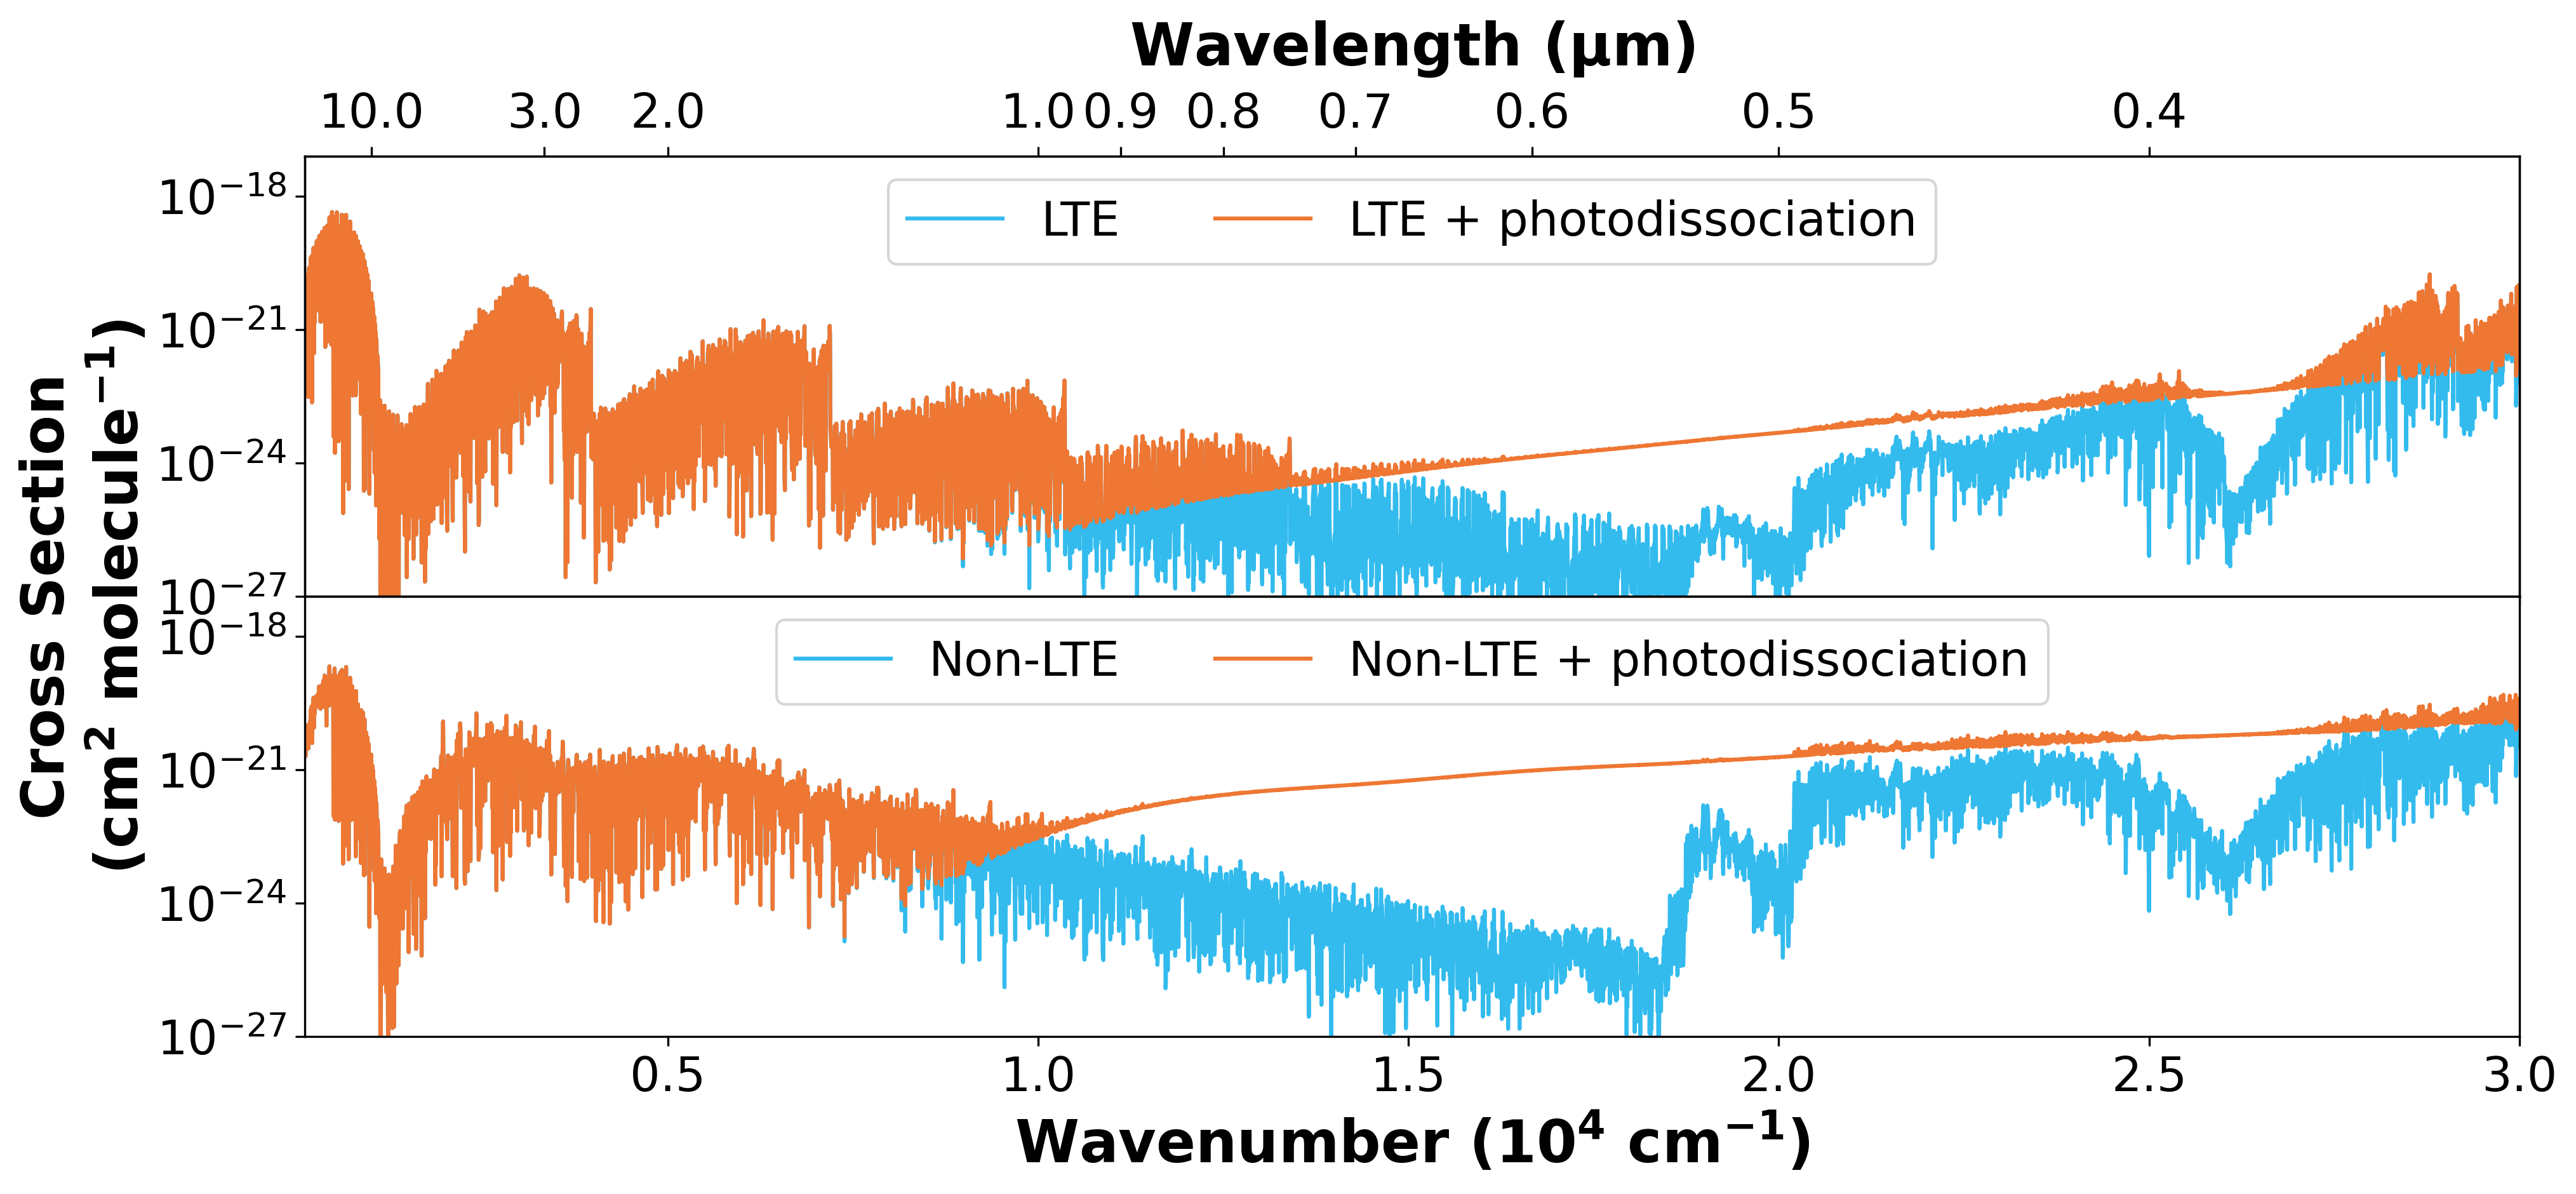

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), dpi=300)
plt.subplots_adjust(hspace=0, wspace=0)
label_fontsize = 22
tick_fontsize = 18

ax1.plot(wn_grid / 10000, lte_abs_xsec, label="LTE", color="#33BBEE")
ax1.plot(wn_grid / 10000, lte_full_xsec, label="LTE + photodissociation", color="#EE7733")
# ax1.text(0.1, 0.9, "LTE", ha="left", va="center", transform=ax1.transAxes, fontsize=label_size)
ax1.set_xlim(left=wn_grid[0] / 10000, right=wn_grid[-1] / 10000)
ax1.set_ylim(bottom=1e-27, top=8e-18)
ax1.set_yscale("log")
ax1.set_ylabel(ylabel="Cross Section\n(cm$^\\mathbf{2}$ molecule$^\\mathbf{-1}$)", fontsize=label_fontsize,
               fontweight="bold")
ax1.yaxis.set_label_coords(x=-0.07, y=0.0)
ax1.legend(loc="upper center", ncols=2, fontsize=tick_fontsize)
ax1.tick_params(axis="x", which="both", labelbottom=False)
ax1.tick_params(axis="y", which="both", labelsize=tick_fontsize)

ax_wl = ax1.twiny()
ax_wl.set_xlim(ax1.get_xlim())
wl_tick_vals = [10.0, 3.0, 2.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]  # nanometer tick marks
new_tick_locations = [microns_to_wavenumbers(x) / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel(r"Wavelength ($\mathbf{\mu}$m)", fontsize=label_fontsize, fontweight="bold", labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

ax2.plot(wn_grid / 10000, nlte_abs_xsec, label="Non-LTE", color="#33BBEE")
ax2.plot(wn_grid / 10000, nlte_full_xsec, label="Non-LTE + photodissociation", color="#EE7733")
# ax2.text(0.1, 0.9, "Non-LTE", ha="left", va="center", transform=ax2.transAxes, fontsize=label_size)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(r"Wavenumber (10$^\mathbf{4}$ cm$^\mathbf{-1}$)", fontsize=label_fontsize, fontweight="bold")
ax2.set_ylim(ax1.get_ylim())
ax2.set_yscale("log")
ax2.legend(loc="upper center", ncols=2, fontsize=tick_fontsize)
ax2.tick_params(labelsize=tick_fontsize)

# plt.tight_layout()
plt.savefig(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_TOA_spectra.png", dpi=600, transparent=True)
plt.show()

In [45]:
converged_pops = np.loadtxt(r"/mnt/c/PhD/NLTE/Models/KELT-20b/KELT-20b_nLTE_cont_L45_converged_pops.txt")
continuum_rates = {
    0:  2.636972e+10,
    1:  6.031791e+10,
    2:  1.789482e+11,
    3:  4.833220e+11,
    4:  1.233343e+12,
    5:  2.185756e+12,
    6:  3.224898e+12,
    7:  3.049117e+12,
    8:  2.684556e+12,
    9:  2.408450e+12,
    10:  1.601170e+12,
}
print(converged_pops[-1, :11])
cont_rates = np.array(list(continuum_rates.values()))
cont_rates_total = sum(cont_rates)
cont_bic_xic = np.array([17.820132949469826, 45.23538837949524, 142.33392775959481, 406.19287586257644, 1106.9405369041722,
                2141.236574845147, 4830.4801204409805, 9541.92297074601, 14107.730697916106, 15588.189105527257, 12000.678569814947])
print(cont_bic_xic / cont_bic_xic.sum())

[0.20684287 0.17638754 0.14741703 0.119892   0.09529657 0.07400378
 0.05648977 0.0430992  0.03288243 0.02598233 0.02170442]
[0.00029736 0.00075482 0.00237505 0.00677793 0.01847094 0.0357297
 0.0806037  0.1592211  0.23540835 0.26011199 0.20024907]


In [46]:
test_rhs = np.zeros(len(cont_bic_xic) + 1)
test_rhs[-1] = 1
print(test_rhs)
test_y = np.vstack([np.diag(-cont_bic_xic), np.ones(len(cont_bic_xic))])
print(test_y)
test_x = np.linalg.pinv(test_y) @ test_rhs
print(sum(test_x))
print(test_y @ test_x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[-1.78201329e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.52353884e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.42333928e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.06192876e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.10694054e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+

In [3]:
import h5py
filepath = r"/mnt/c/Users/Charles/Downloads/31P-14N__PaiN.R15000_0.3-50mu.xsec.TauREx.h5"
filepath = pathlib.Path(filepath)
with h5py.File(filepath, "r") as f:
    species = f["mol_name"][0].decode("utf-8")
    spectral_grid = f["bin_edges"][()] << u.k
    temp_grid = f["t"][()] << u.K
    pressure_grid = f["p"][()] << u.bar
    xsec_grid = f["xsecarr"][()] << u.cm**2

In [8]:
print(pressure_grid)

[1.00000000e-06 2.15443469e-06 4.64158883e-06 1.00000000e-05
 2.15443469e-05 4.64158883e-05 1.00000000e-04 2.15443469e-04
 4.64158883e-04 1.00000000e-03 2.15443469e-03 4.64158883e-03
 1.00000000e-02 2.15443469e-02 4.64158883e-02 1.00000000e-01
 2.15443469e-01 4.64158883e-01 1.00000000e+00 2.15443469e+00
 4.64158883e+00 1.00000000e+01 2.15443469e+01 4.64158883e+01
 1.00000000e+02] bar


In [10]:
np.logspace(np.log10(1e-9), np.log10(1e2), 34)

array([1.00000000e-09, 2.15443469e-09, 4.64158883e-09, 1.00000000e-08,
       2.15443469e-08, 4.64158883e-08, 1.00000000e-07, 2.15443469e-07,
       4.64158883e-07, 1.00000000e-06, 2.15443469e-06, 4.64158883e-06,
       1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02, 2.15443469e-02, 4.64158883e-02,
       1.00000000e-01, 2.15443469e-01, 4.64158883e-01, 1.00000000e+00,
       2.15443469e+00, 4.64158883e+00, 1.00000000e+01, 2.15443469e+01,
       4.64158883e+01, 1.00000000e+02])

[10.85318201  0.07698117  0.22226477  1.08446326  0.75324367  0.32675227
  0.31166817  0.85072999]
[ 5.23045482  0.54313901  0.47385897 38.00137148  1.70709724  0.96622439
  0.7912397   0.21256618]
[0.39064311 1.59229359 0.07151145 0.25135114 4.33804409 0.34335937
 0.86788707 0.45703714]
[0.74523082 0.44768209 0.70736328 0.37716261 0.6284994  0.52976372
 0.59815043 0.33611663]
[0.64138555 3.03544926 0.72785865 0.01137382 0.16731628 1.03147773
 0.76294715 0.76730851]
